# 계절

In [38]:
import json
import os
import re
import pandas as pd

folder_path = r"\Users\kyn03\OneDrive\바탕 화면\project_file\output\워드클라우드_json\계절"

# 제거할 불용어 리스트 정의
stopwords = ["있어요", "합니다", "입니다", "같아요", "있는", "않고","맞는", "뿌리면","뿌리고","뿌리는","뭐가","좋은","좋아요","좋고","뿌려주면","뿌리기",
             "않아요","좋아서","않아서","하고","좋습니다","거","구매했어요","아니라","하고","정말","많은","뿌려주고","좋았어요", "뿌려주기", "뿌려도",
             "안되고","있습니다","줄","샀어요","구매해서","사서","샀습니다","피부에","피부가","꽤","가격이","가격은","100","피부에","피부","후","해서",
             "가격도","구매했습니다","얼굴에", "가격에","300", "없고","없이","피부에는","넘"]  # 필요에 따라 불용어 추가

# 데이터를 담을 딕셔너리 생성
data = {}
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        filename = filename.replace(" ", "")  # 파일 이름에서 공백 제거
        path = os.path.join(folder_path, filename)

        with open(path, "r", encoding="utf-8") as file:
            # 파일 이름에서 브랜드, 카테고리, 감정 추출
            match = re.match(r"^([가-힣]+)_[가-힣]+_((?:[\w가-힣]+_?)+)_(positive|negative).*\.json$", filename)
            if match:
                brand = match.group(1)       # 첫 번째 그룹: 브랜드명
                category = match.group(2)    # 두 번째 그룹: 속성명 (다중 언더스코어 포함 가능)
                sentiment = match.group(3)   # 세 번째 그룹: 긍정/부정

                # JSON 파일에서 단어 데이터를 읽어와서 리스트로 저장
                words = json.load(file)
                for word, count in words.items():
                    # 불용어 필터링
                    if word not in stopwords:
                        data.setdefault((brand, category, sentiment), []).append((word, count))
            else:
                print(f"파일명 형식이 맞지 않음: {filename}")

# 데이터를 DataFrame으로 변환
df = pd.DataFrame(columns=["Brand", "Category", "Sentiment", "Word", "Frequency"])

# 데이터프레임에 데이터 추가
rows = []
for (brand, category, sentiment), words in data.items():
    # 빈도수가 높은 순서대로 정렬
    sorted_words = sorted(words, key=lambda x: x[1], reverse=True)
    for word, count in sorted_words:
        rows.append({
            "Brand": brand,
            "Category": category,
            "Sentiment": sentiment,
            "Word": word,
            "Frequency": count
        })

# DataFrame에 데이터를 추가
df = pd.DataFrame(rows)

# Frequency를 숫자형으로 변환
df['Frequency'] = pd.to_numeric(df['Frequency'], errors='coerce')

# 결과 출력
print(df)

      Brand  Category Sentiment    Word  Frequency
0        가을        가격  negative     편이라          3
1        가을        가격  negative      가격          3
2        가을        가격  negative     비싸서          2
3        가을        가격  negative    비싸지만          2
4        가을        가격  negative     가격만          2
...     ...       ...       ...     ...        ...
26925    여름  효과_성능_기능  positive      끊을          1
26926    여름  효과_성능_기능  positive   찰떡이에요          1
26927    여름  효과_성능_기능  positive      충전          1
26928    여름  효과_성능_기능  positive   공급용으로          1
26929    여름  효과_성능_기능  positive  드시나봅니다          1

[26930 rows x 5 columns]


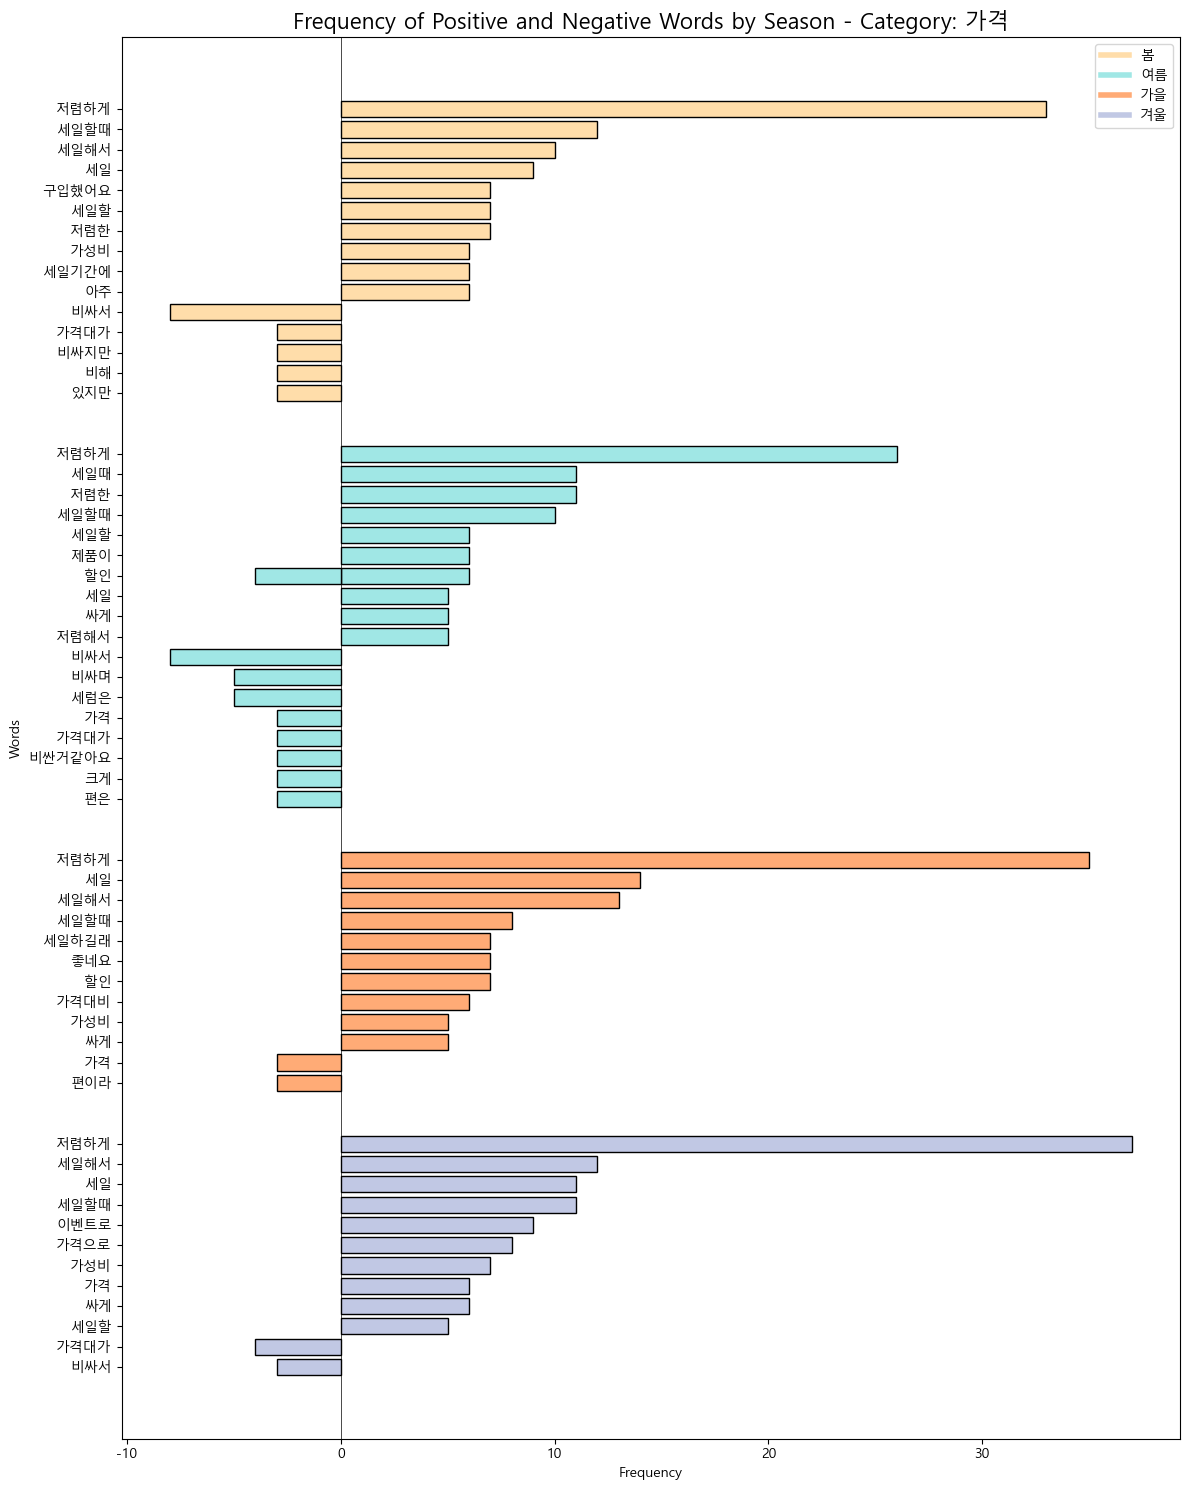

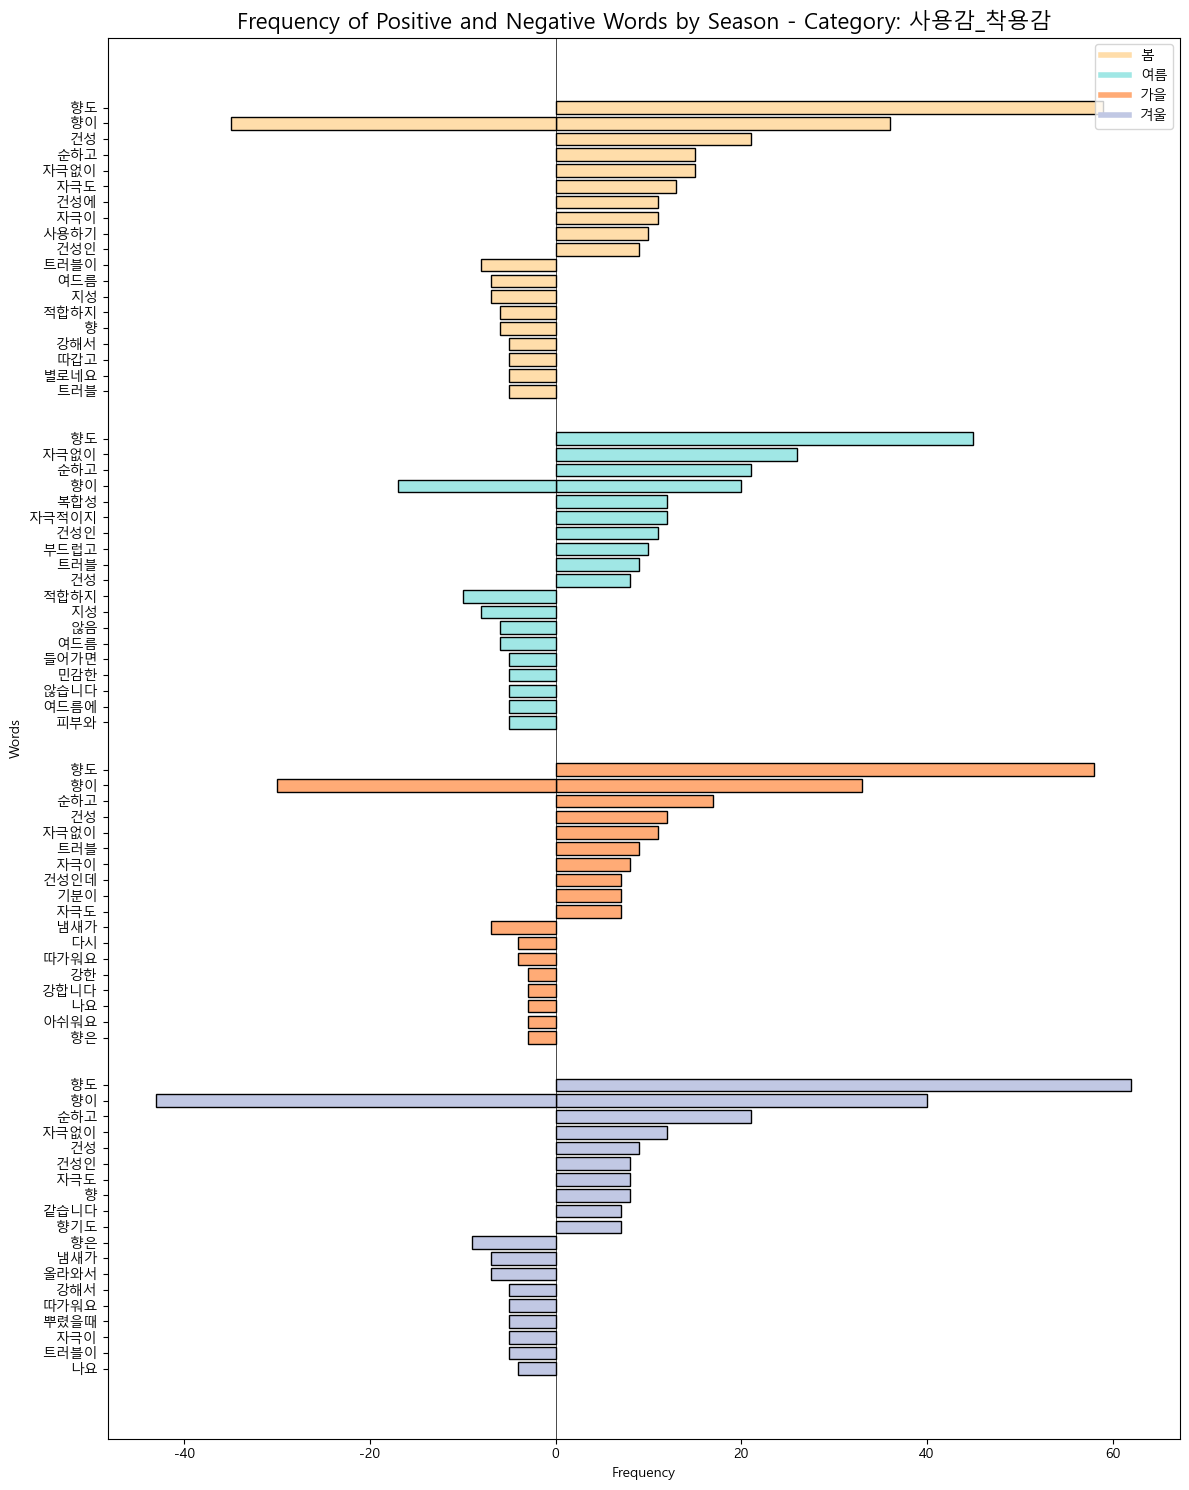

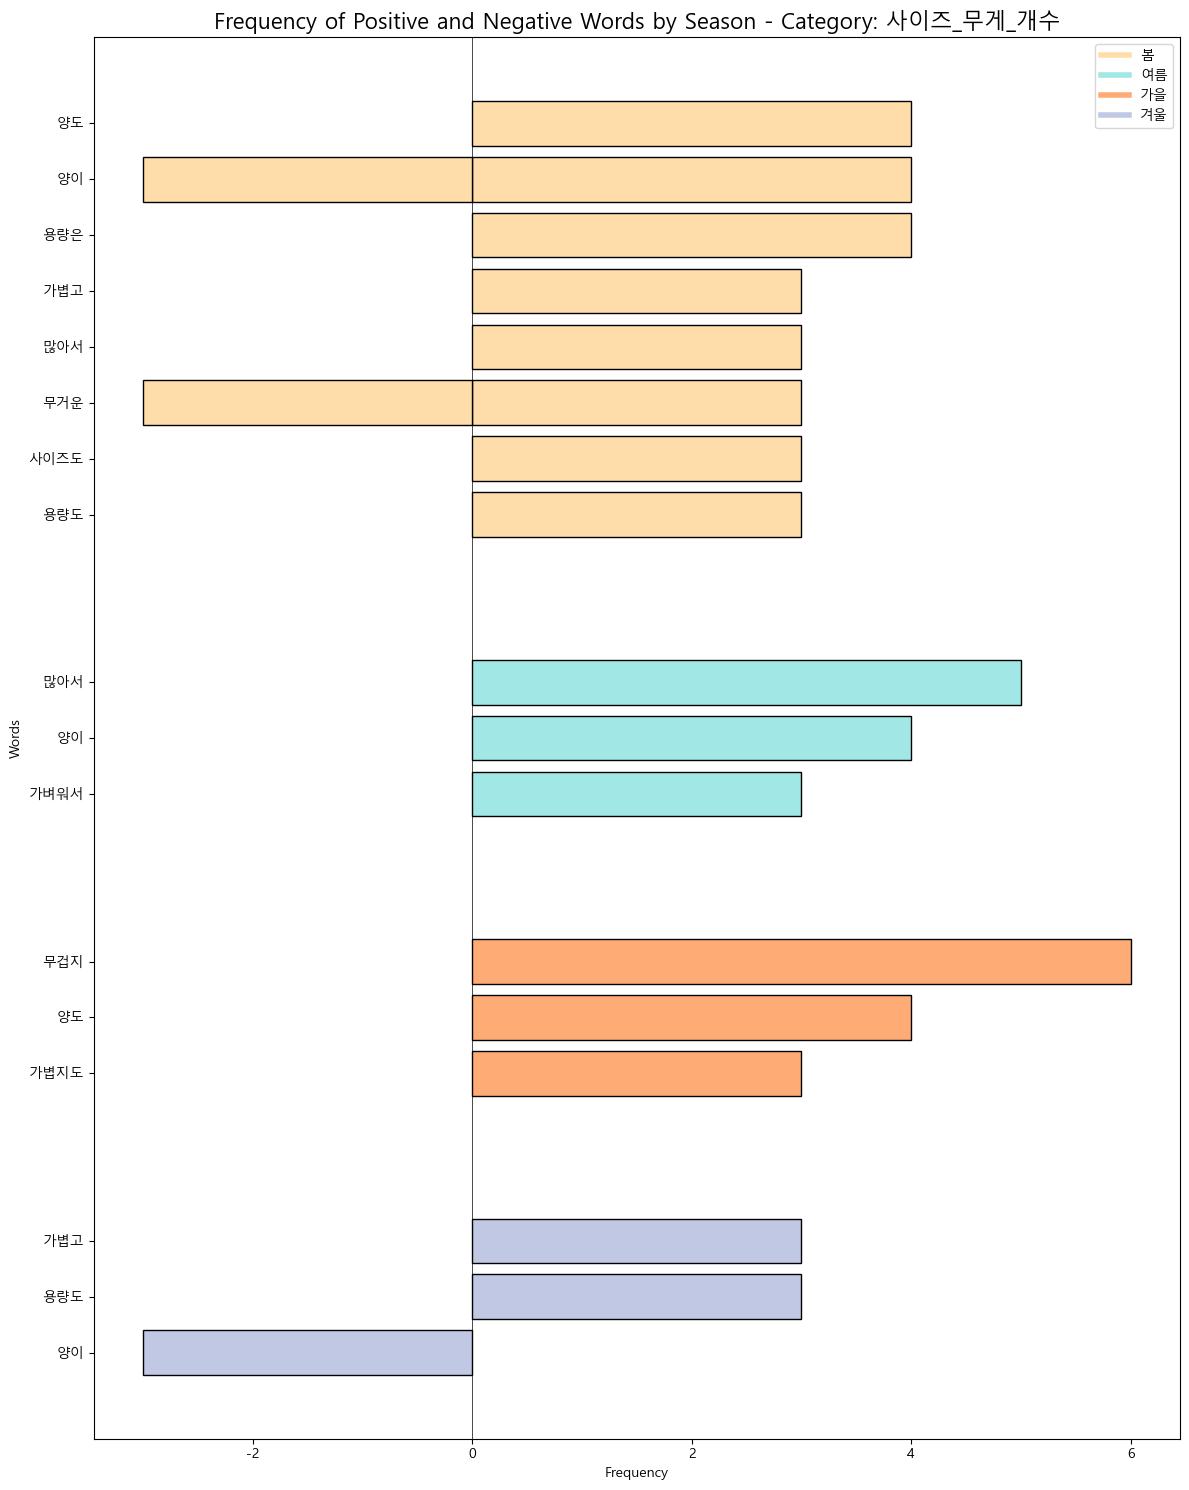

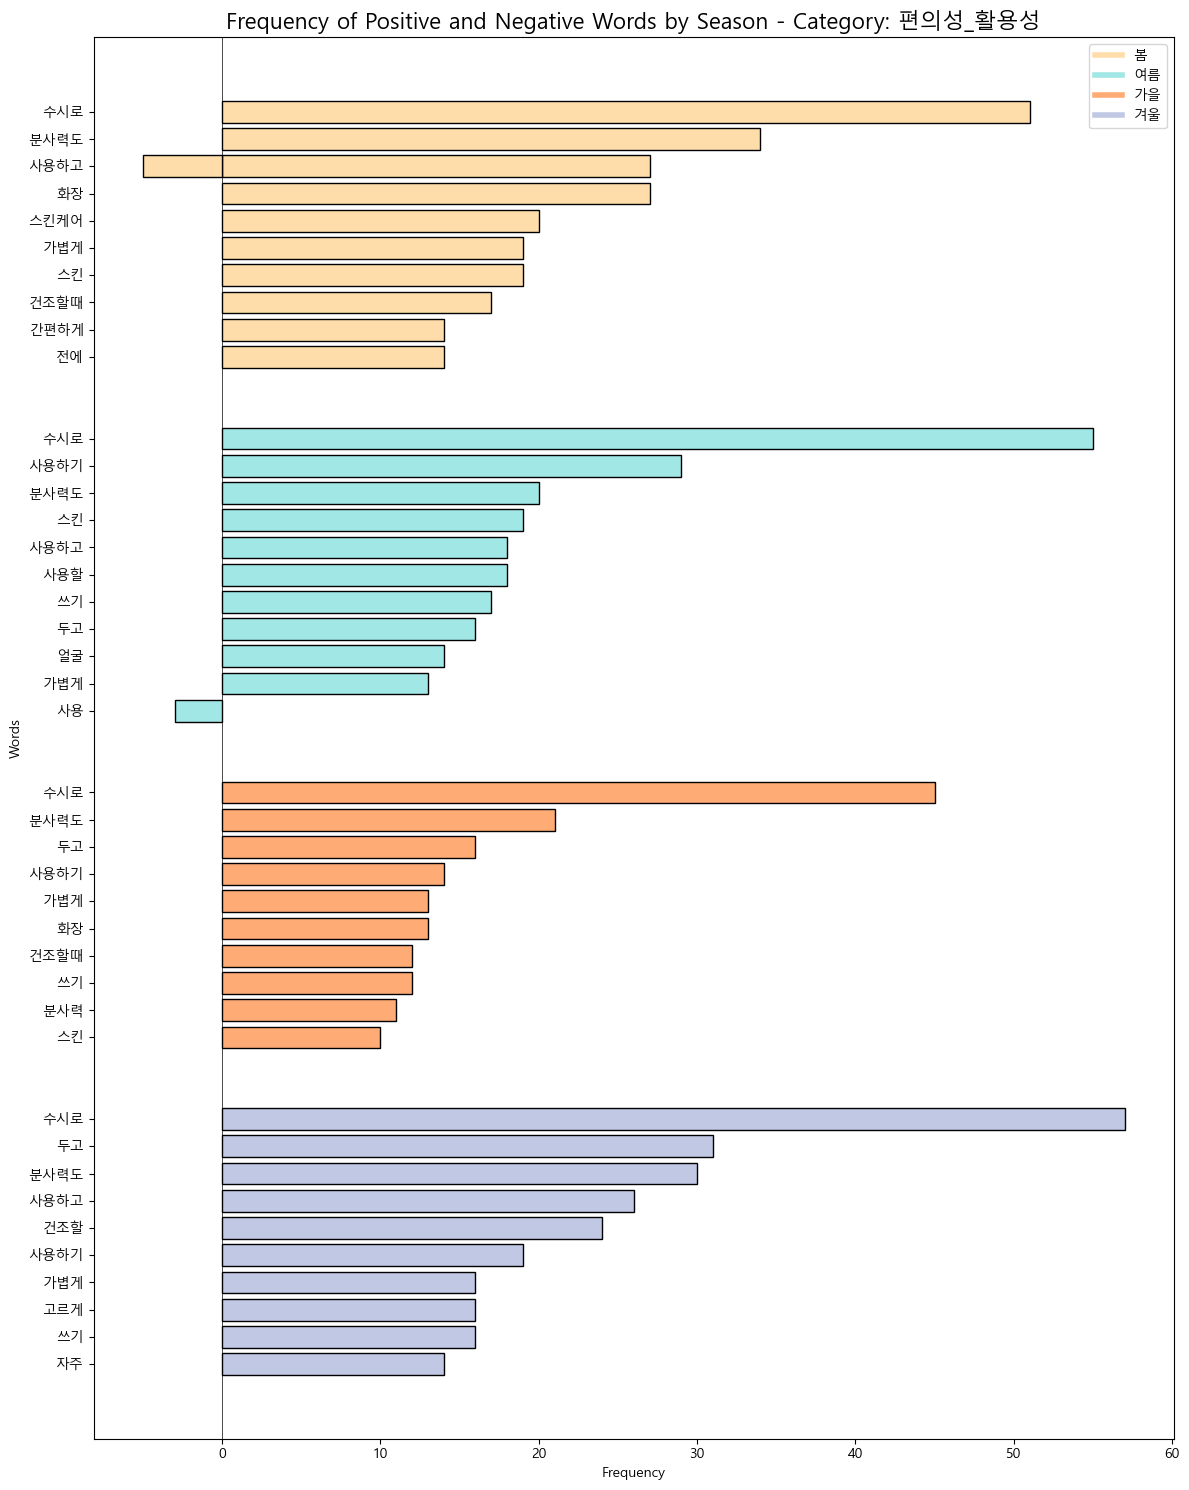

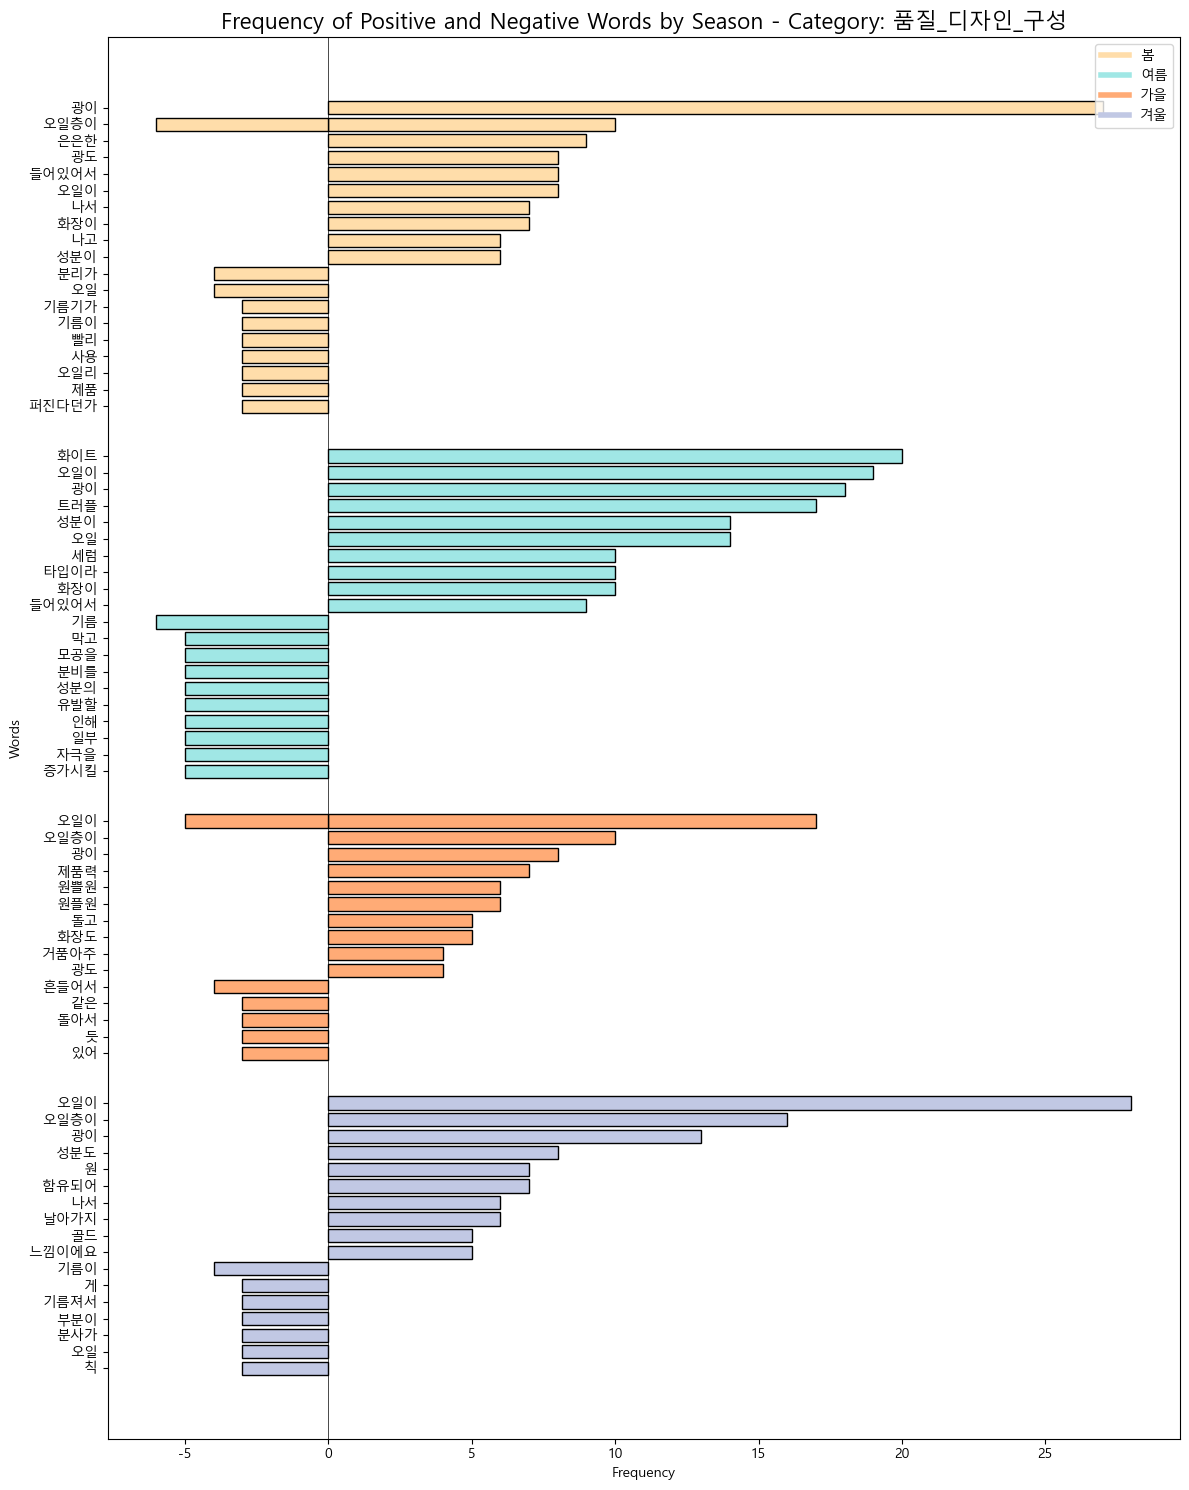

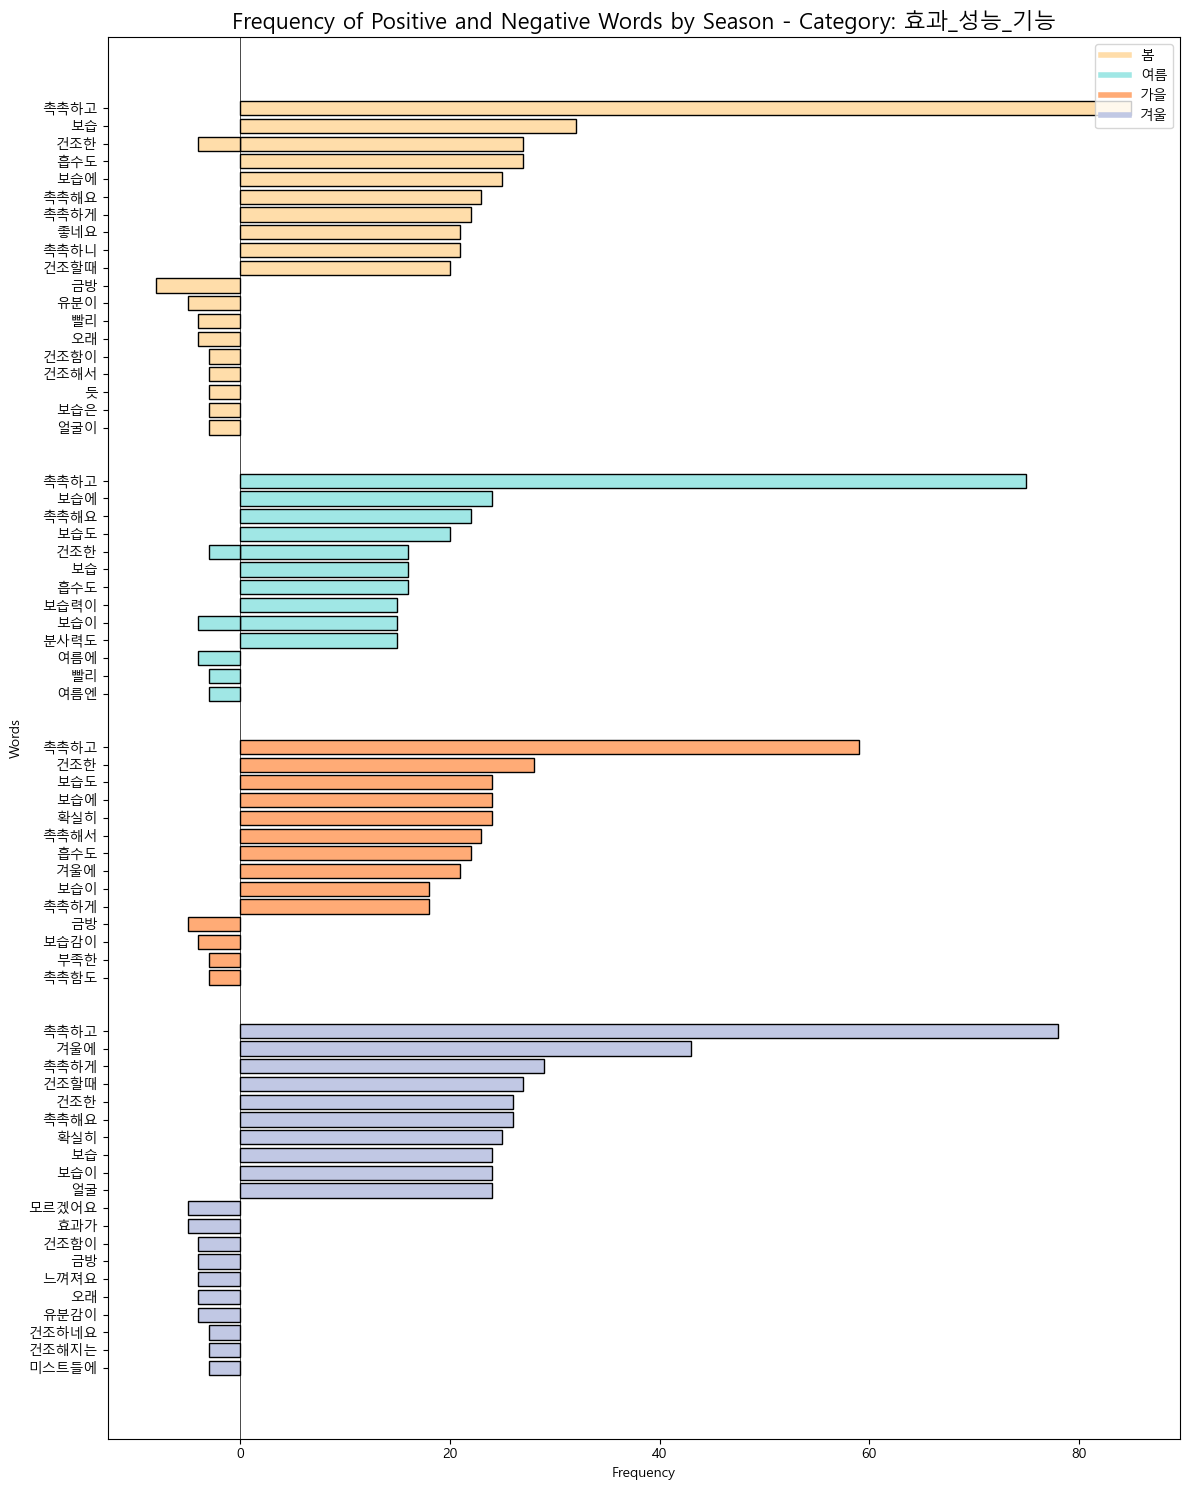

In [39]:
import matplotlib.pyplot as plt
import unicodedata
import pandas as pd
from matplotlib import font_manager, rc


# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


# Unicode 정규화 함수 정의
def normalize_text(text):
    return unicodedata.normalize('NFC', text)

# 브랜드 색상 설정 (정규화 적용 - 파스텔 톤)
brand_colors = {
    normalize_text('봄'): '#FFDDAA',  # 따뜻하고 부드러운 살구색 (봄의 밝고 상쾌한 느낌)
    normalize_text('여름'): '#A0E7E5',  # 청량한 민트 블루 (여름의 시원함과 상쾌함)
    normalize_text('가을'): '#FFAB76',  # 따뜻한 복숭아색 (가을의 포근함과 풍요로움)
    normalize_text('겨울'): '#C1C8E4',  # 차분한 연보라색 (겨울의 차가움과 고요함)
}


# 데이터 정규화 (모든 문자열 필드에 정규화 적용)
df['Brand'] = df['Brand'].apply(normalize_text)
df['Category'] = df['Category'].apply(normalize_text)
df['Sentiment'] = df['Sentiment'].apply(normalize_text)
df['Word'] = df['Word'].apply(normalize_text)

# 빈도수 5 이상인 데이터만 필터링
filtered_df = df[df['Frequency'] >= 3]

# 중복 단어 제거: 같은 브랜드 내에서 동일한 단어의 긍정/부정 빈도를 합산
filtered_df = filtered_df.groupby(['Brand', 'Category', 'Word', 'Sentiment'], as_index=False)['Frequency'].sum()

# 카테고리별로 그래프 그리기
for category in filtered_df['Category'].unique():
    # 카테고리별 데이터 필터링
    category_data = filtered_df[filtered_df['Category'] == normalize_text(category)]

    fig, ax = plt.subplots(figsize=(12, 15))
    
    ax.set_title(normalize_text(f"Frequency of Positive and Negative Words by Season - Category: {category}"), fontsize=16)

    # 단어 레이블과 위치 저장을 위한 리스트 초기화
    words = []
    y_positions = []
    offset = 0  # y축 위치 오프셋

    # 각 브랜드별로 상단부터 달바, 바이오힐보, 아벤느 순으로 정렬
    for brand in ['봄', '여름', '가을','겨울']:
        # 브랜드별 데이터 필터링
        brand_data = category_data[category_data['Brand'] == normalize_text(brand)]

        # 긍정 단어 상위 10개와 부정 단어 상위 10개 선택
        positive_words = brand_data[brand_data['Sentiment'] == 'positive'].nlargest(10, 'Frequency')
        negative_words = brand_data[brand_data['Sentiment'] == 'negative'].nlargest(10, 'Frequency')

        # 긍정 단어와 부정 단어 결합
        combined_words = pd.concat([positive_words, negative_words]).drop_duplicates(subset=['Word'], keep='first')

        # 긍정 단어 우선 정렬, 이후 남은 부정 단어 내림차순 정렬
        sorted_words = pd.concat([
            combined_words[combined_words['Sentiment'] == 'positive'].sort_values(by='Frequency', ascending=False),
            combined_words[(combined_words['Sentiment'] == 'negative') & (~combined_words['Word'].isin(positive_words['Word']))].sort_values(by='Frequency', ascending=False)
        ])

        # 단어별로 긍정/부정 데이터를 결합하여 표시
        for _, row in sorted_words.iterrows():
            word = row['Word']
            pos_data = positive_words[positive_words['Word'] == word]
            neg_data = negative_words[negative_words['Word'] == word]

            # y축 위치 설정
            y_pos = offset
            words.append(word)
            y_positions.append(y_pos)

            # 긍정 단어가 있는 경우 막대 그리기 (오른쪽 방향)
            if not pos_data.empty:
                pos_frequency = pos_data['Frequency'].sum()
                ax.barh(y_pos, pos_frequency, height=0.8, color=brand_colors[brand], edgecolor='black')

            # 부정 단어가 있는 경우 막대 그리기 (왼쪽 방향)
            if not neg_data.empty:
                neg_frequency = neg_data['Frequency'].sum()
                ax.barh(y_pos, -neg_frequency, height=0.8, color=brand_colors[brand], edgecolor='black')

            # 다음 단어로 이동
            offset += 1

        # 브랜드 간 여백 추가
        offset += 2  # 각 브랜드 사이에 여백을 추가

    # y축 레이블 설정 및 축 반전
    ax.set_yticks(y_positions)
    ax.set_yticklabels(words, fontsize=10)
    plt.gca().invert_yaxis()  # y축을 반전시켜 긍정 단어가 상단에 위치하도록 설정

    # 축 및 레이블 설정
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')
    
    ax.axvline(0, color='black', linewidth=0.5)  # 중앙 기준선 추가

    # 범례 추가 (브랜드별 색상만 표시)
    brand_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in brand_colors.values()]
    brand_labels = list(brand_colors.keys())
    ax.legend(brand_handles, brand_labels, loc="upper right")

    plt.tight_layout()
    plt.show()


# 성별

In [1]:
import json
import os
import re
import pandas as pd

folder_path = r"\Users\kyn03\OneDrive\바탕 화면\project_file\이탈\워드클라우드_json\성별"

# 제거할 불용어 리스트 정의
stopwords = ["있어요", "합니다", "입니다", "같아요", "있는", "않고","맞는", "뿌리면","뿌리고","뿌리는","뭐가","좋은","좋아요","좋고","뿌려주면","뿌리기",
             "않아요","좋아서","않아서","하고","좋습니다","거","구매했어요","아니라","하고","정말","많은","뿌려주고","좋았어요", "뿌려주기", "뿌려도",
             "안되고","있습니다","줄","샀어요","구매해서","사서","샀습니다","피부에","피부가","꽤","가격이","가격은","100","피부에","피부","후","해서",
             "가격도","구매했습니다","얼굴에", "가격에","300", "없고","없이","피부에는","넘"]  # 필요에 따라 불용어 추가

# 데이터를 담을 딕셔너리 생성
data = {}
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        filename = filename.replace(" ", "")  # 파일 이름에서 공백 제거
        path = os.path.join(folder_path, filename)

        with open(path, "r", encoding="utf-8") as file:
            # 파일 이름에서 브랜드, 카테고리, 감정 추출
            match = re.match(r"^[가-힣]+_([a-z])+_((?:[\w가-힣]+_?)+)_(positive|negative).*\.json$", filename)
            if match:
                brand = match.group(1)       # 첫 번째 그룹: 브랜드명
                category = match.group(2)    # 두 번째 그룹: 속성명 (다중 언더스코어 포함 가능)
                sentiment = match.group(3)   # 세 번째 그룹: 긍정/부정

                # JSON 파일에서 단어 데이터를 읽어와서 리스트로 저장
                words = json.load(file)
                for word, count in words.items():
                    # 불용어 필터링
                    if word not in stopwords:
                        data.setdefault((brand, category, sentiment), []).append((word, count))
            else:
                print(f"파일명 형식이 맞지 않음: {filename}")

# 데이터를 DataFrame으로 변환
df = pd.DataFrame(columns=["Brand", "Category", "Sentiment", "Word", "Frequency"])

# 데이터프레임에 데이터 추가
rows = []
for (brand, category, sentiment), words in data.items():
    # 빈도수가 높은 순서대로 정렬
    sorted_words = sorted(words, key=lambda x: x[1], reverse=True)
    for word, count in sorted_words:
        rows.append({
            "Brand": brand,
            "Category": category,
            "Sentiment": sentiment,
            "Word": word,
            "Frequency": count
        })

# DataFrame에 데이터를 추가
df = pd.DataFrame(rows)

# Frequency를 숫자형으로 변환
df['Frequency'] = pd.to_numeric(df['Frequency'], errors='coerce')

# 결과 출력
print(df)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: '\\Users\\kyn03\\OneDrive\\바탕 화면\\project_file\\이탈\\워드클라우드_json\\성별'

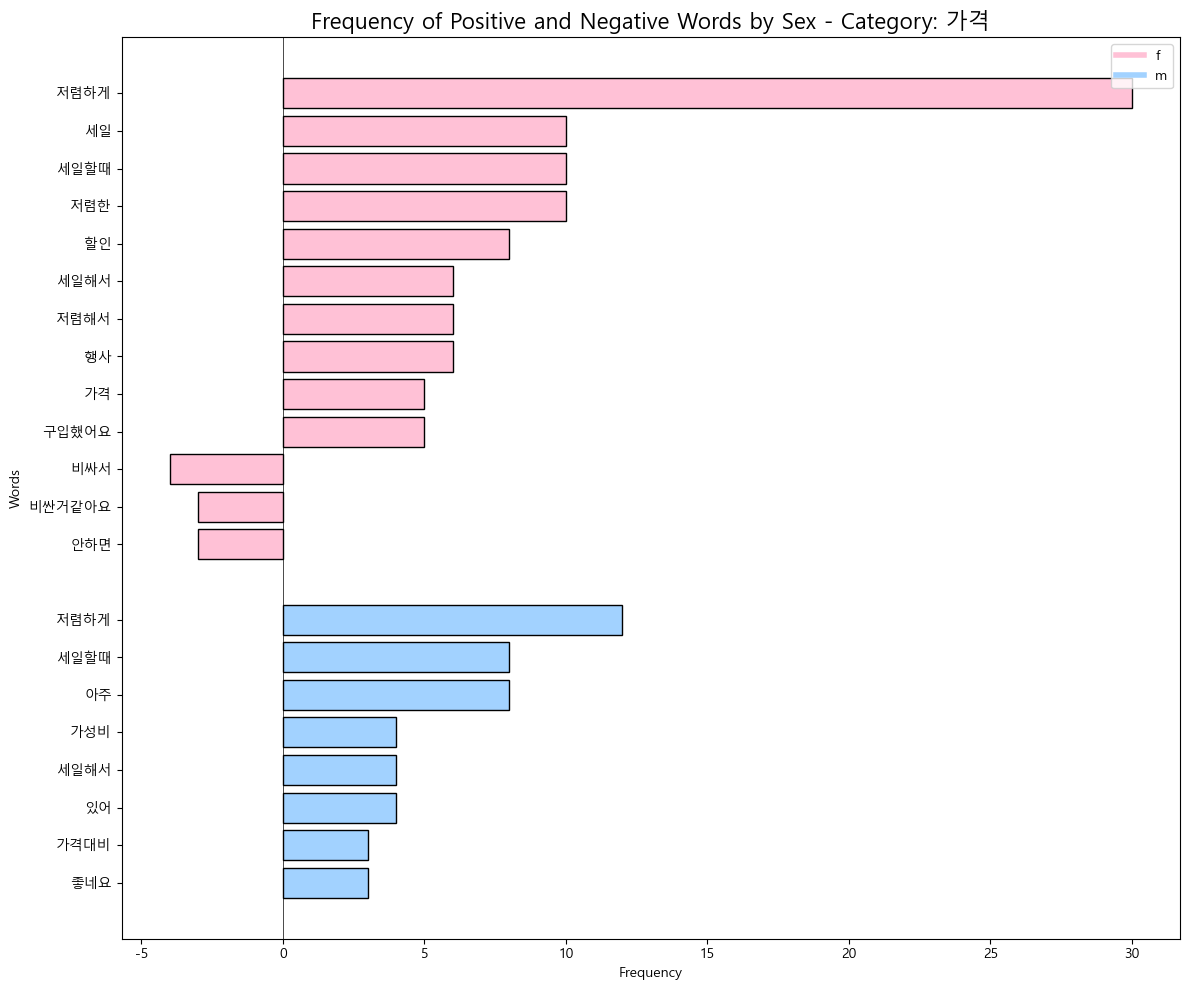

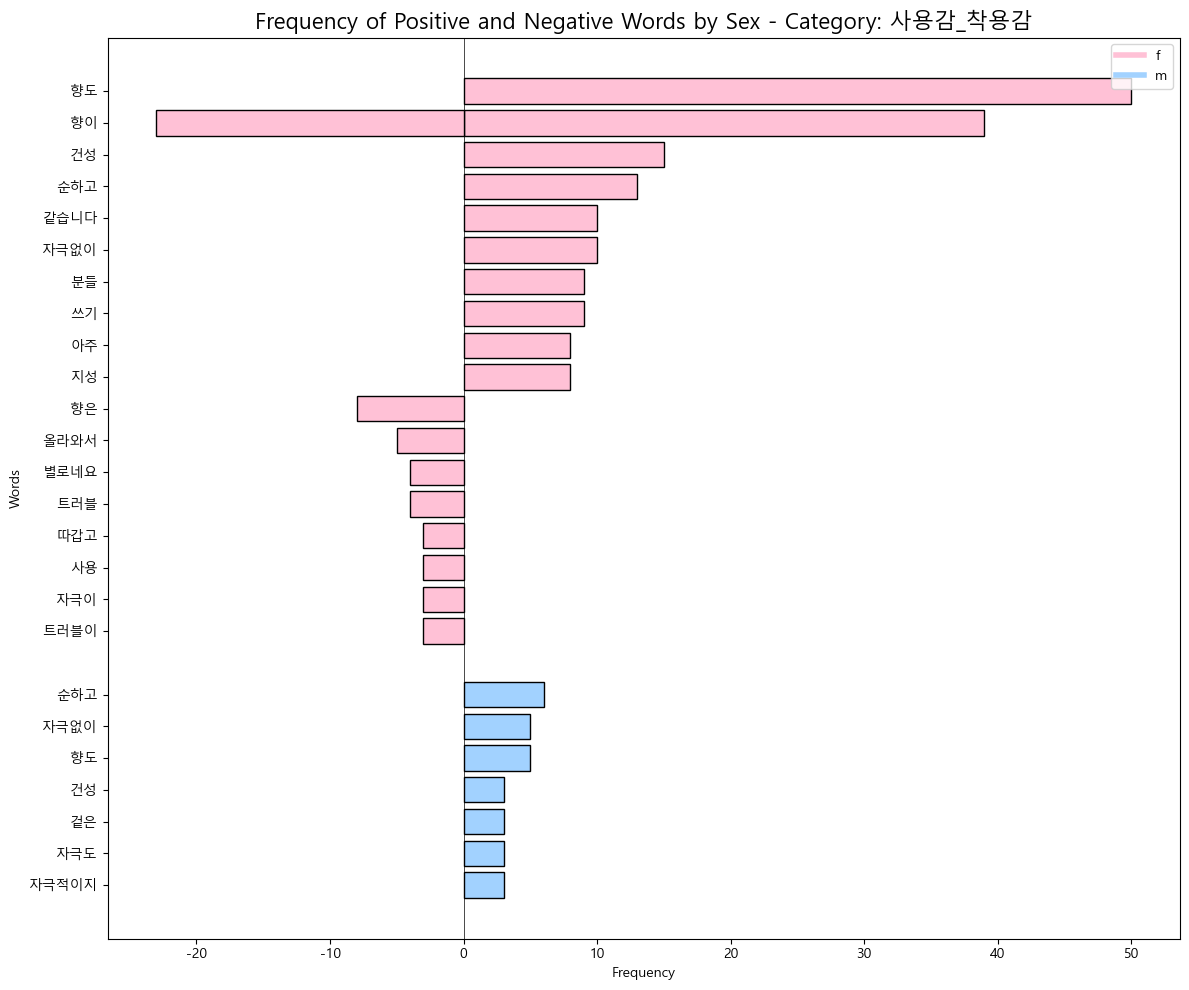

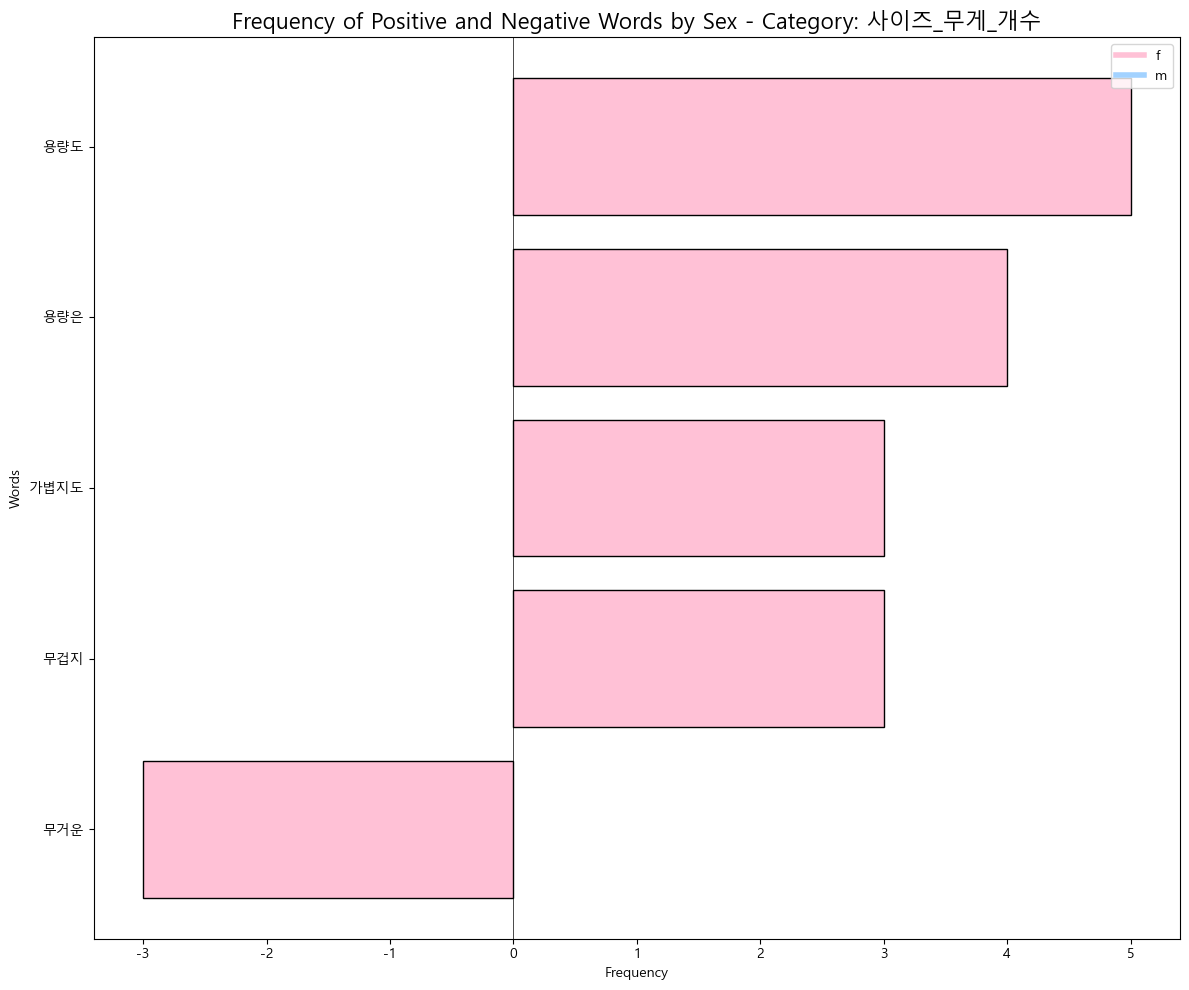

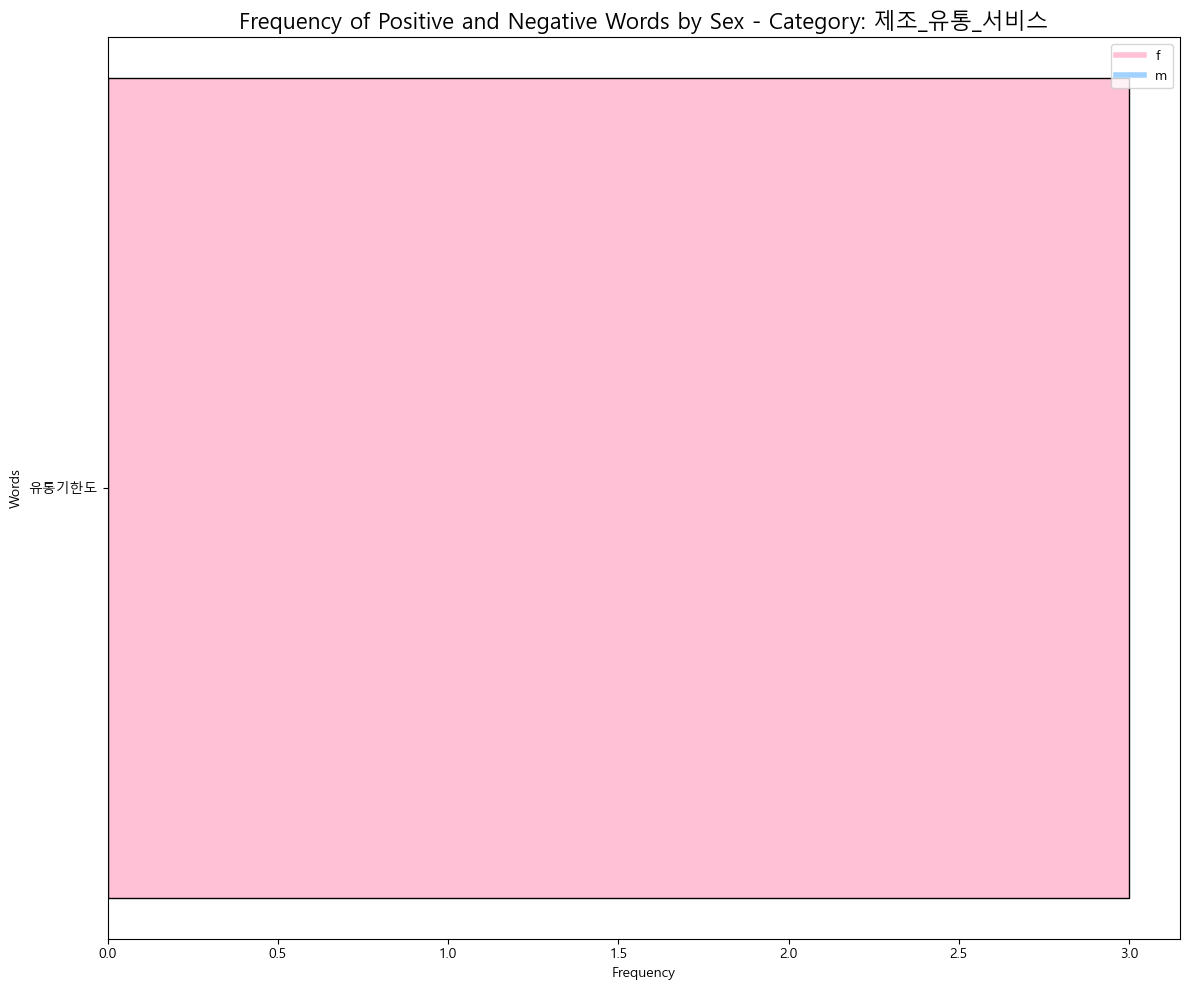

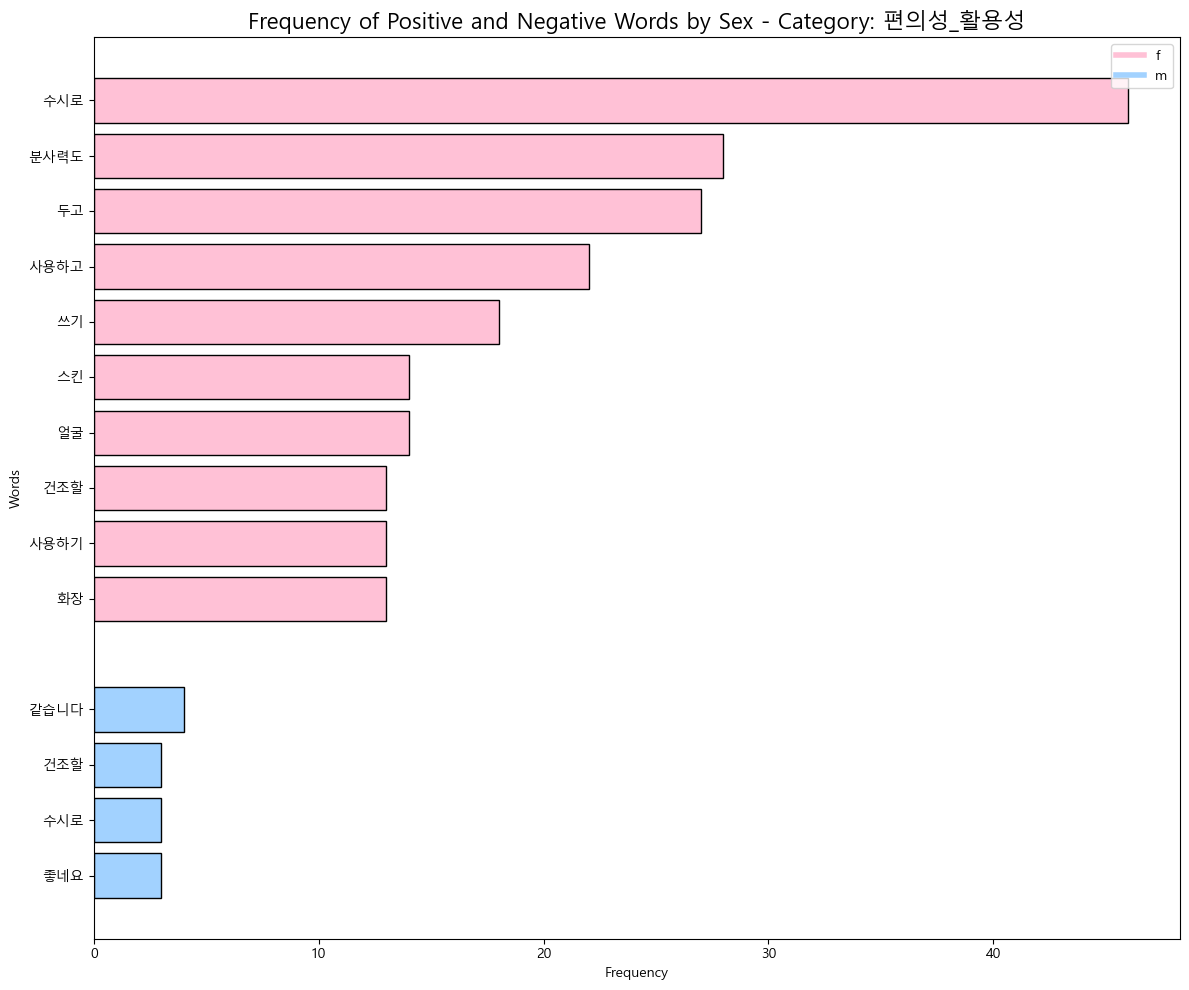

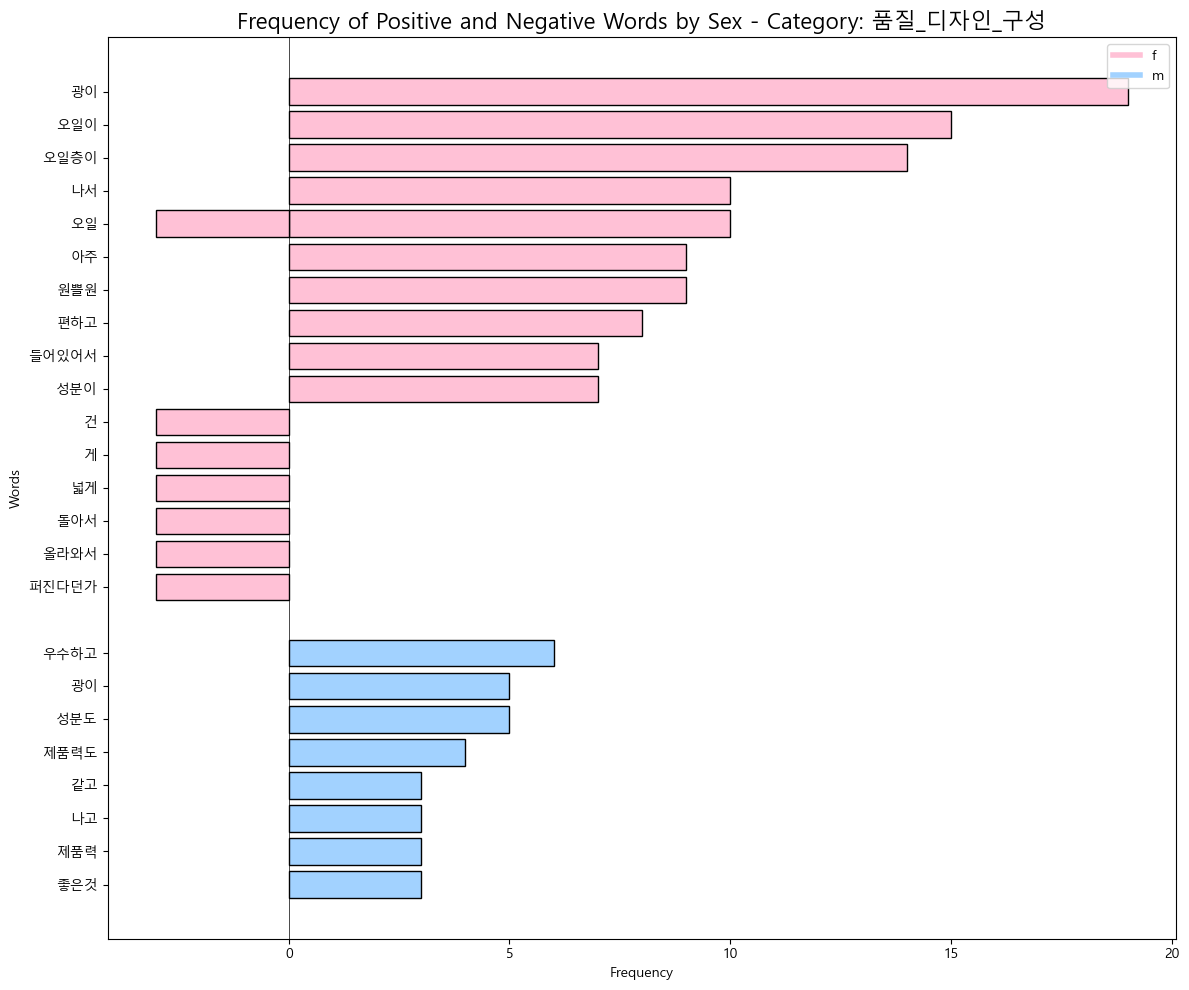

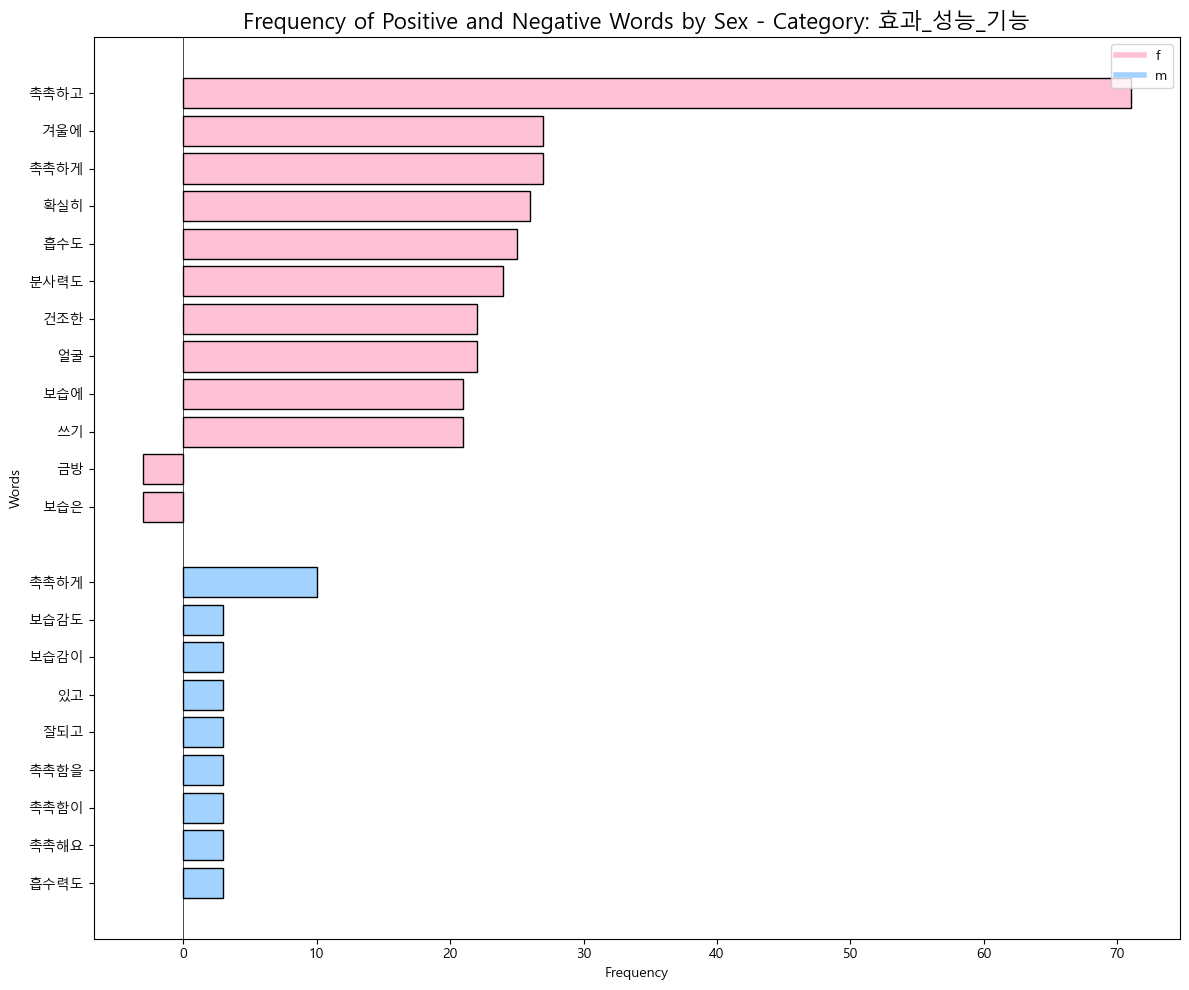

In [12]:
import matplotlib.pyplot as plt
import unicodedata
import pandas as pd
from matplotlib import font_manager, rc


# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


# Unicode 정규화 함수 정의
def normalize_text(text):
    return unicodedata.normalize('NFC', text)

# 브랜드 색상 설정 (정규화 적용 - 성별 파스텔 톤)
brand_colors = {
    normalize_text('f'): '#FFC1D6',  # 부드러운 핑크톤 (여성의 우아하고 따뜻한 느낌)
    normalize_text('m'): '#A2D2FF',  # 차분한 파스텔 블루 (남성의 안정감과 청량함)
}


# 데이터 정규화 (모든 문자열 필드에 정규화 적용)
df['Brand'] = df['Brand'].apply(normalize_text)
df['Category'] = df['Category'].apply(normalize_text)
df['Sentiment'] = df['Sentiment'].apply(normalize_text)
df['Word'] = df['Word'].apply(normalize_text)

# 빈도수 5 이상인 데이터만 필터링
filtered_df = df[df['Frequency'] >= 3]

# 중복 단어 제거: 같은 브랜드 내에서 동일한 단어의 긍정/부정 빈도를 합산
filtered_df = filtered_df.groupby(['Brand', 'Category', 'Word', 'Sentiment'], as_index=False)['Frequency'].sum()

# 카테고리별로 그래프 그리기
for category in filtered_df['Category'].unique():
    # 카테고리별 데이터 필터링
    category_data = filtered_df[filtered_df['Category'] == normalize_text(category)]

    fig, ax = plt.subplots(figsize=(12, 10))
    
    ax.set_title(normalize_text(f"Frequency of Positive and Negative Words by Sex - Category: {category}"), fontsize=16)

    # 단어 레이블과 위치 저장을 위한 리스트 초기화
    words = []
    y_positions = []
    offset = 0  # y축 위치 오프셋

    # 각 브랜드별로 상단부터 달바, 바이오힐보, 아벤느 순으로 정렬
    for brand in ['f','m']:
        # 브랜드별 데이터 필터링
        brand_data = category_data[category_data['Brand'] == normalize_text(brand)]

        # 긍정 단어 상위 10개와 부정 단어 상위 10개 선택
        positive_words = brand_data[brand_data['Sentiment'] == 'positive'].nlargest(10, 'Frequency')
        negative_words = brand_data[brand_data['Sentiment'] == 'negative'].nlargest(10, 'Frequency')

        # 긍정 단어와 부정 단어 결합
        combined_words = pd.concat([positive_words, negative_words]).drop_duplicates(subset=['Word'], keep='first')

        # 긍정 단어 우선 정렬, 이후 남은 부정 단어 내림차순 정렬
        sorted_words = pd.concat([
            combined_words[combined_words['Sentiment'] == 'positive'].sort_values(by='Frequency', ascending=False),
            combined_words[(combined_words['Sentiment'] == 'negative') & (~combined_words['Word'].isin(positive_words['Word']))].sort_values(by='Frequency', ascending=False)
        ])

        # 단어별로 긍정/부정 데이터를 결합하여 표시
        for _, row in sorted_words.iterrows():
            word = row['Word']
            pos_data = positive_words[positive_words['Word'] == word]
            neg_data = negative_words[negative_words['Word'] == word]

            # y축 위치 설정
            y_pos = offset
            words.append(word)
            y_positions.append(y_pos)

            # 긍정 단어가 있는 경우 막대 그리기 (오른쪽 방향)
            if not pos_data.empty:
                pos_frequency = pos_data['Frequency'].sum()
                ax.barh(y_pos, pos_frequency, height=0.8, color=brand_colors[brand], edgecolor='black')

            # 부정 단어가 있는 경우 막대 그리기 (왼쪽 방향)
            if not neg_data.empty:
                neg_frequency = neg_data['Frequency'].sum()
                ax.barh(y_pos, -neg_frequency, height=0.8, color=brand_colors[brand], edgecolor='black')

            # 다음 단어로 이동
            offset += 1

        # 브랜드 간 여백 추가
        offset += 1  # 각 브랜드 사이에 여백을 추가

    # y축 레이블 설정 및 축 반전
    ax.set_yticks(y_positions)
    ax.set_yticklabels(words, fontsize=10)
    plt.gca().invert_yaxis()  # y축을 반전시켜 긍정 단어가 상단에 위치하도록 설정

    # 축 및 레이블 설정
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')
    
    ax.axvline(0, color='black', linewidth=0.5)  # 중앙 기준선 추가

    # 범례 추가 (브랜드별 색상만 표시)
    brand_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in brand_colors.values()]
    brand_labels = list(brand_colors.keys())
    ax.legend(brand_handles, brand_labels, loc="upper right")

    plt.tight_layout()
    plt.show()


# 년도

In [46]:
import json
import os
import re
import pandas as pd

folder_path = r"\Users\kyn03\OneDrive\바탕 화면\project_file\output\워드클라우드_json\연도"

# 제거할 불용어 리스트 정의
stopwords = ["있어요", "합니다", "입니다", "같아요", "있는", "않고","맞는", "뿌리면","뿌리고","뿌리는","뭐가","좋은","좋아요","좋고","뿌려주면","뿌리기",
             "않아요","좋아서","않아서","하고","좋습니다","거","구매했어요","아니라","하고","정말","많은","뿌려주고","좋았어요", "뿌려주기", "뿌려도",
             "안되고","있습니다","줄","샀어요","구매해서","사서","샀습니다","피부에","피부가","꽤","가격이","가격은","100","피부에","피부","후","해서",
             "가격도","구매했습니다","얼굴에", "가격에","300", "없고","없이","피부에는","넘"]  # 필요에 따라 불용어 추가

# 데이터를 담을 딕셔너리 생성
data = {}
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        filename = filename.replace(" ", "")  # 파일 이름에서 공백 제거
        path = os.path.join(folder_path, filename)

        with open(path, "r", encoding="utf-8") as file:
            # 파일 이름에서 브랜드, 카테고리, 감정 추출
            match = re.match(r"^([\d{4}]+)_[가-힣]+_((?:[\w가-힣]+_?)+)_(positive|negative).*\.json$", filename)
            if match:
                brand = match.group(1)       # 첫 번째 그룹: 브랜드명
                category = match.group(2)    # 두 번째 그룹: 속성명 (다중 언더스코어 포함 가능)
                sentiment = match.group(3)   # 세 번째 그룹: 긍정/부정

                # JSON 파일에서 단어 데이터를 읽어와서 리스트로 저장
                words = json.load(file)
                for word, count in words.items():
                    # 불용어 필터링
                    if word not in stopwords:
                        data.setdefault((brand, category, sentiment), []).append((word, count))
            else:
                print(f"파일명 형식이 맞지 않음: {filename}")

# 데이터를 DataFrame으로 변환
df = pd.DataFrame(columns=["Brand", "Category", "Sentiment", "Word", "Frequency"])

# 데이터프레임에 데이터 추가
rows = []
for (brand, category, sentiment), words in data.items():
    # 빈도수가 높은 순서대로 정렬
    sorted_words = sorted(words, key=lambda x: x[1], reverse=True)
    for word, count in sorted_words:
        rows.append({
            "Brand": brand,
            "Category": category,
            "Sentiment": sentiment,
            "Word": word,
            "Frequency": count
        })

# DataFrame에 데이터를 추가
df = pd.DataFrame(rows)

# Frequency를 숫자형으로 변환
df['Frequency'] = pd.to_numeric(df['Frequency'], errors='coerce')

# 결과 출력
print(df)

      Brand  Category Sentiment    Word  Frequency
0      2022        가격  negative      다시          2
1      2022        가격  negative    양에비해          1
2      2022        가격  negative      행사          1
3      2022        가격  negative     단점은          1
4      2022        가격  negative    가격뿐인          1
...     ...       ...       ...     ...        ...
24653  2024  효과_성능_기능  positive     좋기도          1
24654  2024  효과_성능_기능  positive      끊을          1
24655  2024  효과_성능_기능  positive   찰떡이에요          1
24656  2024  효과_성능_기능  positive      완존          1
24657  2024  효과_성능_기능  positive  드시나봅니다          1

[24658 rows x 5 columns]


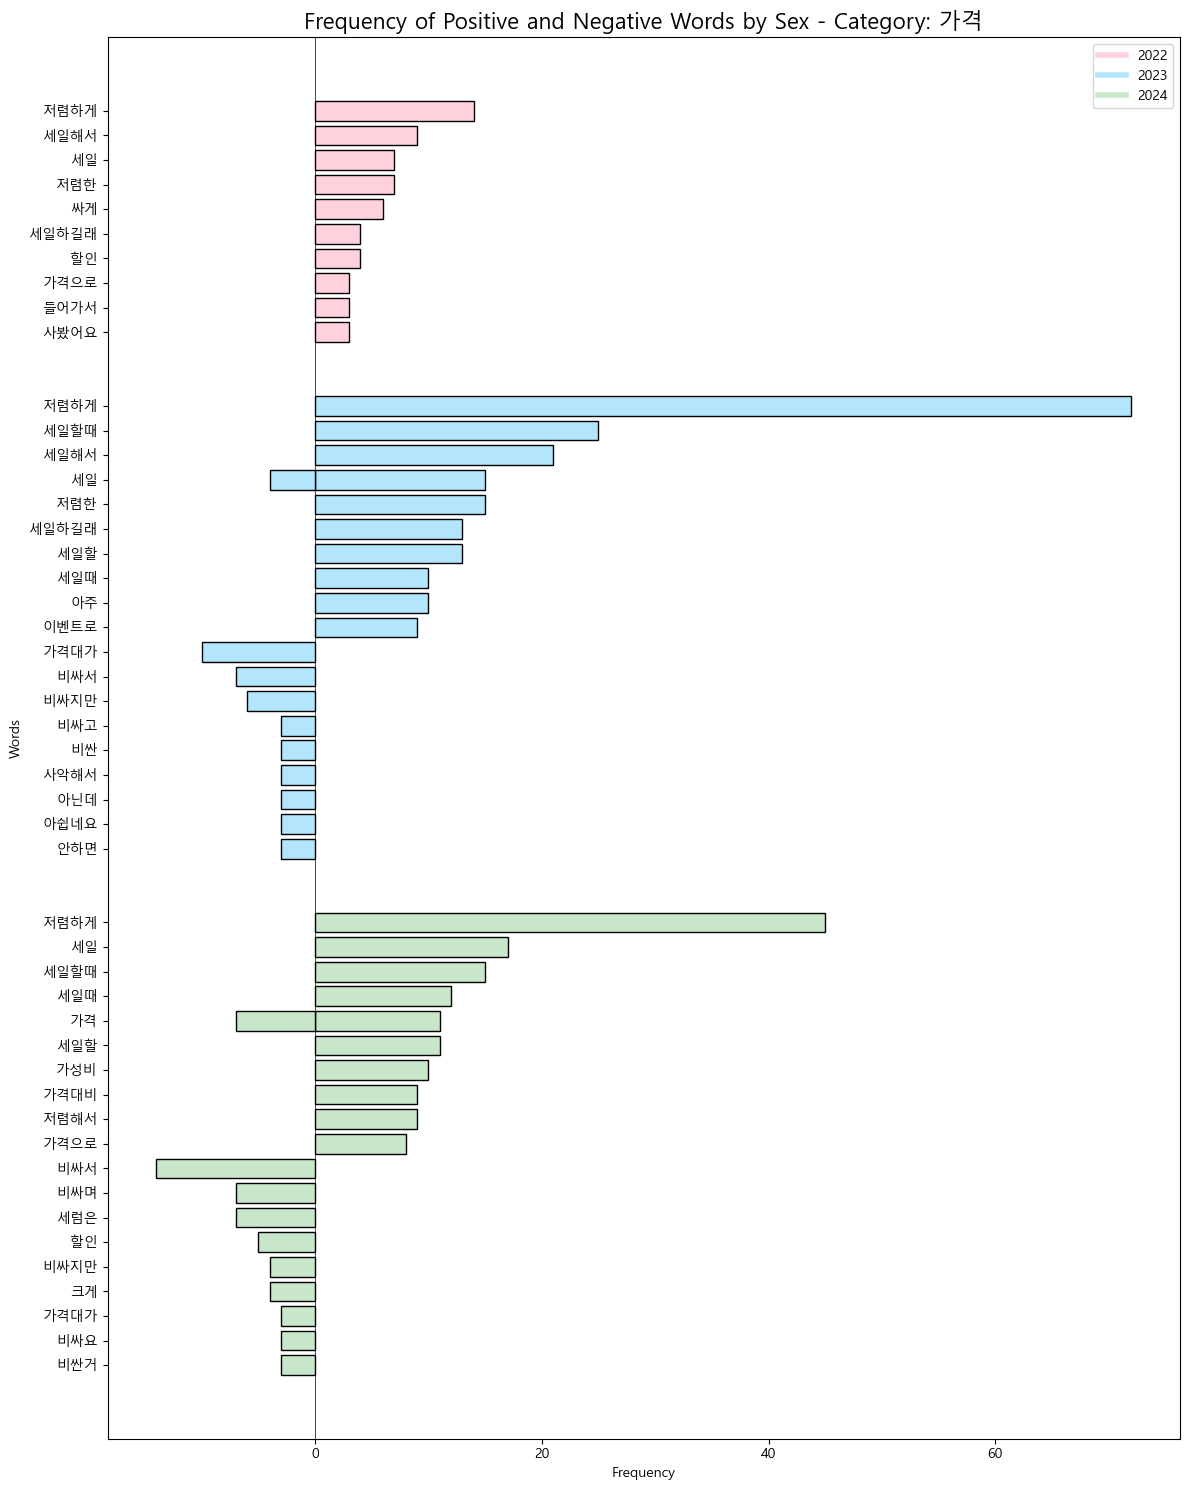

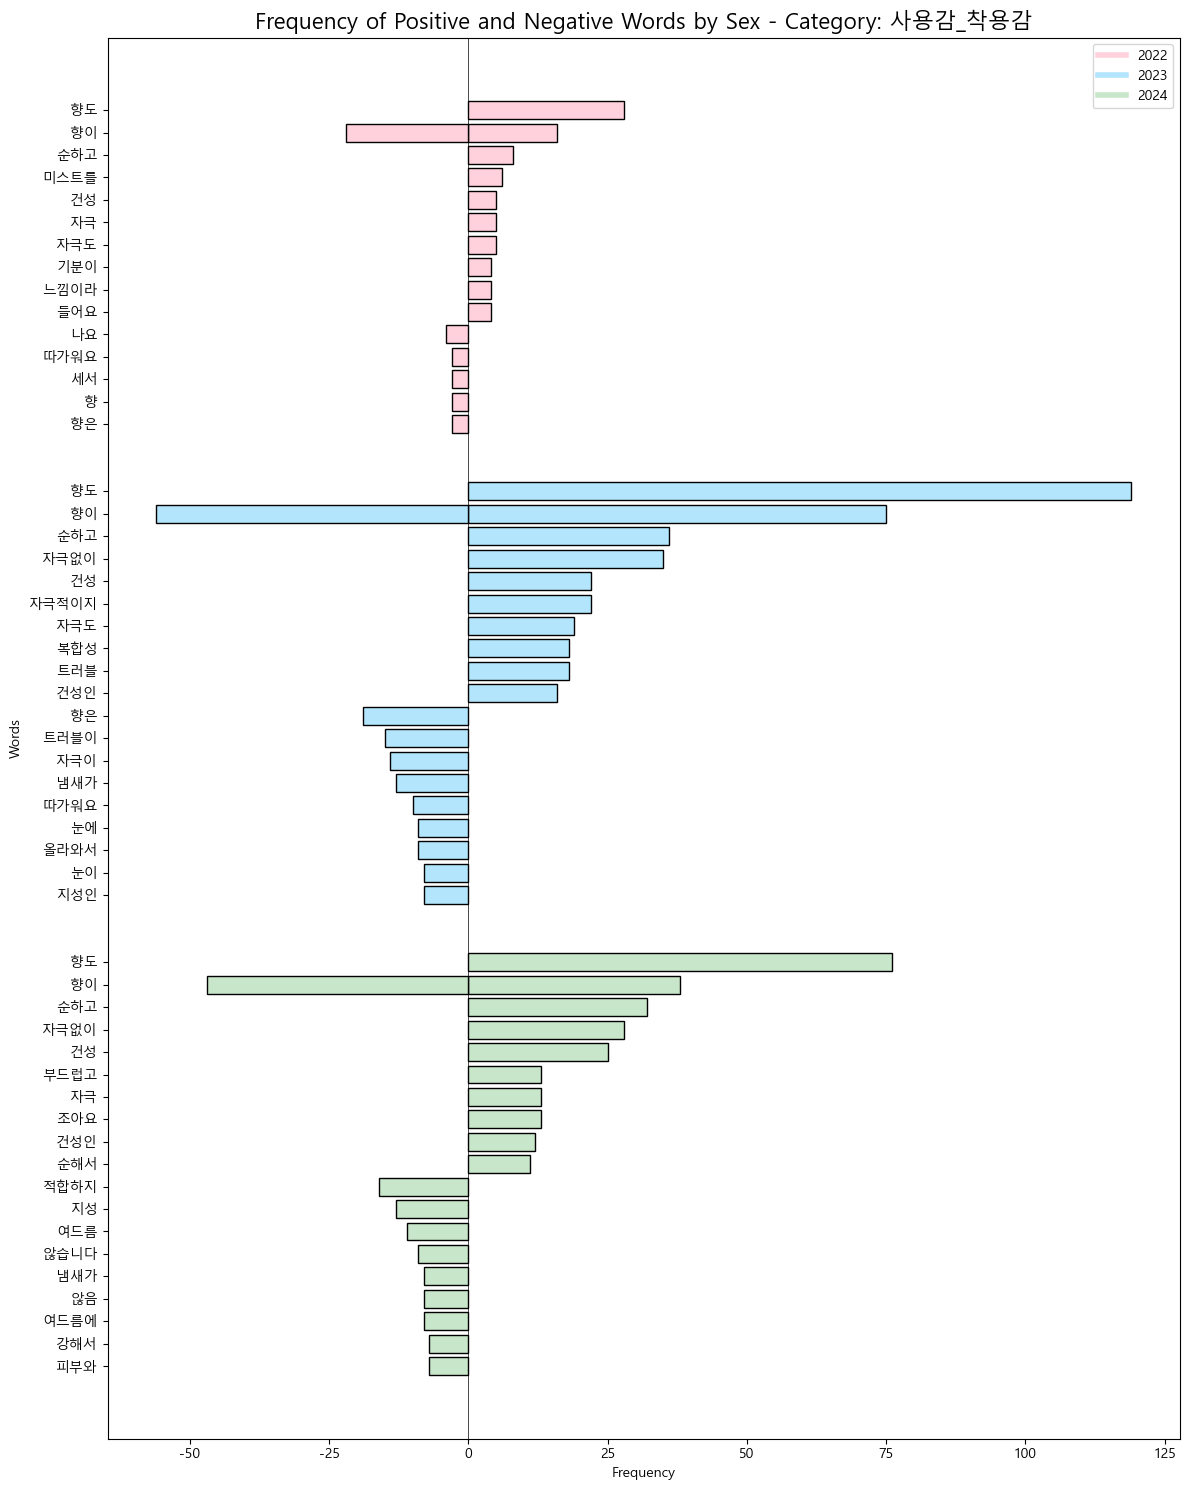

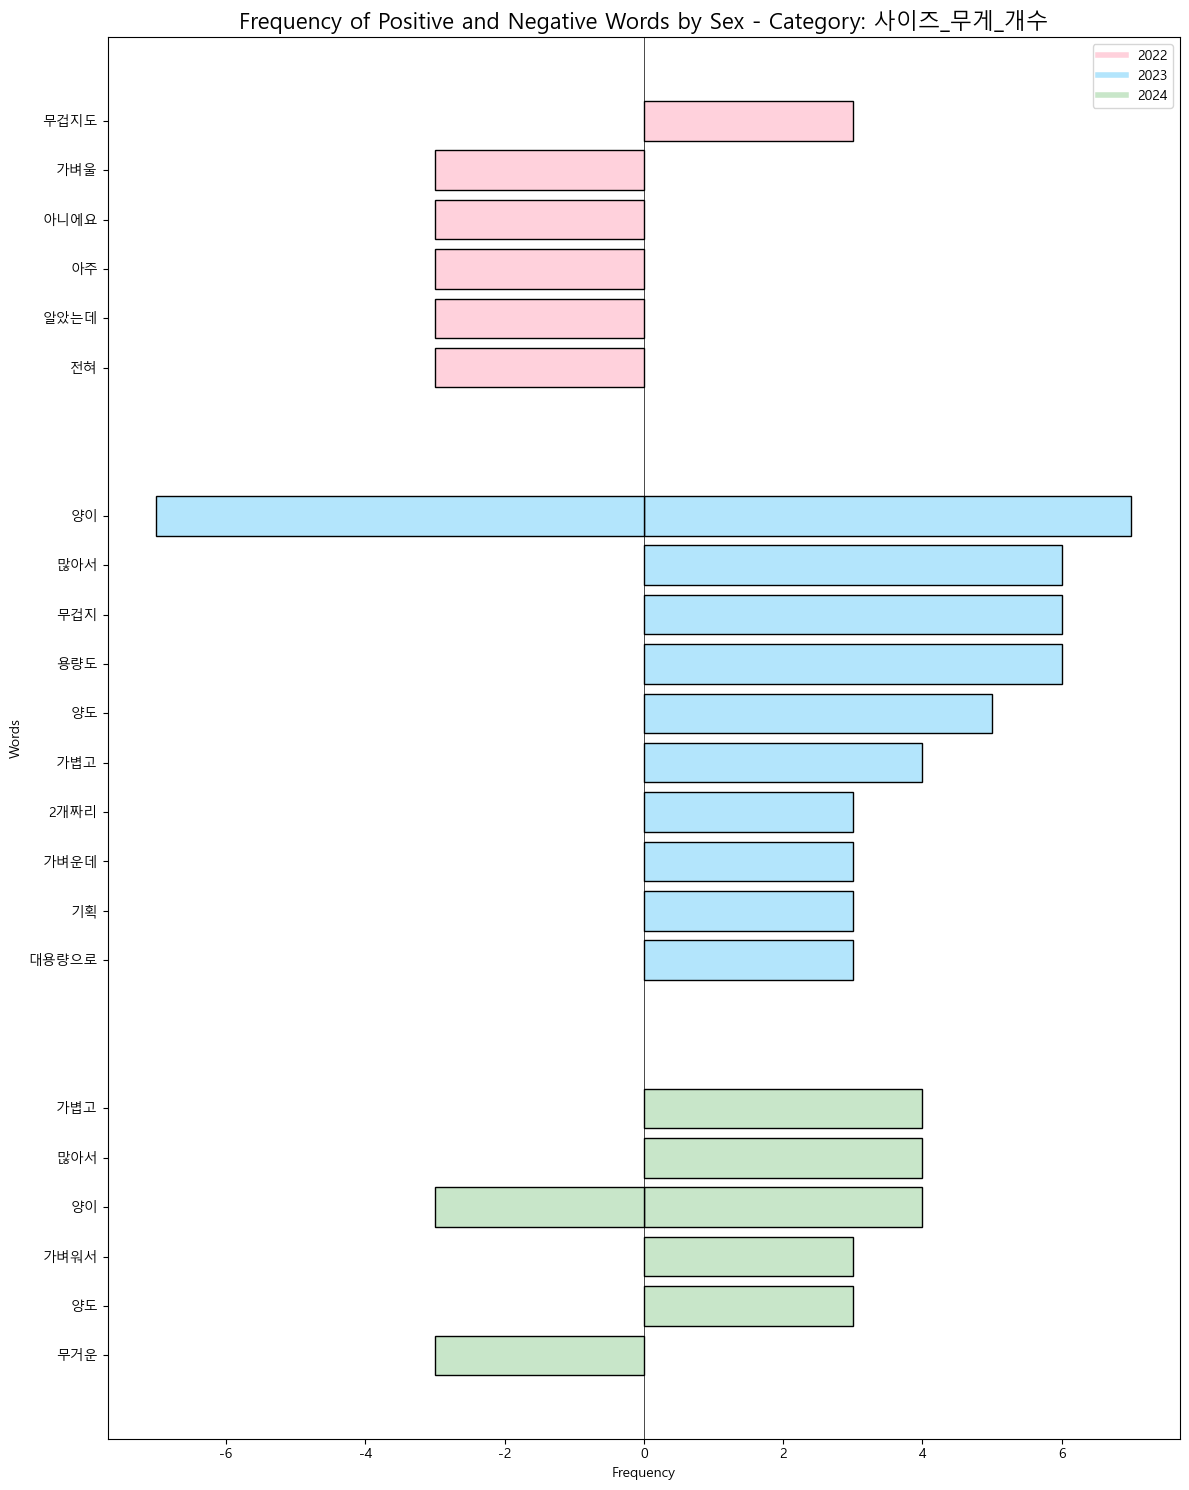

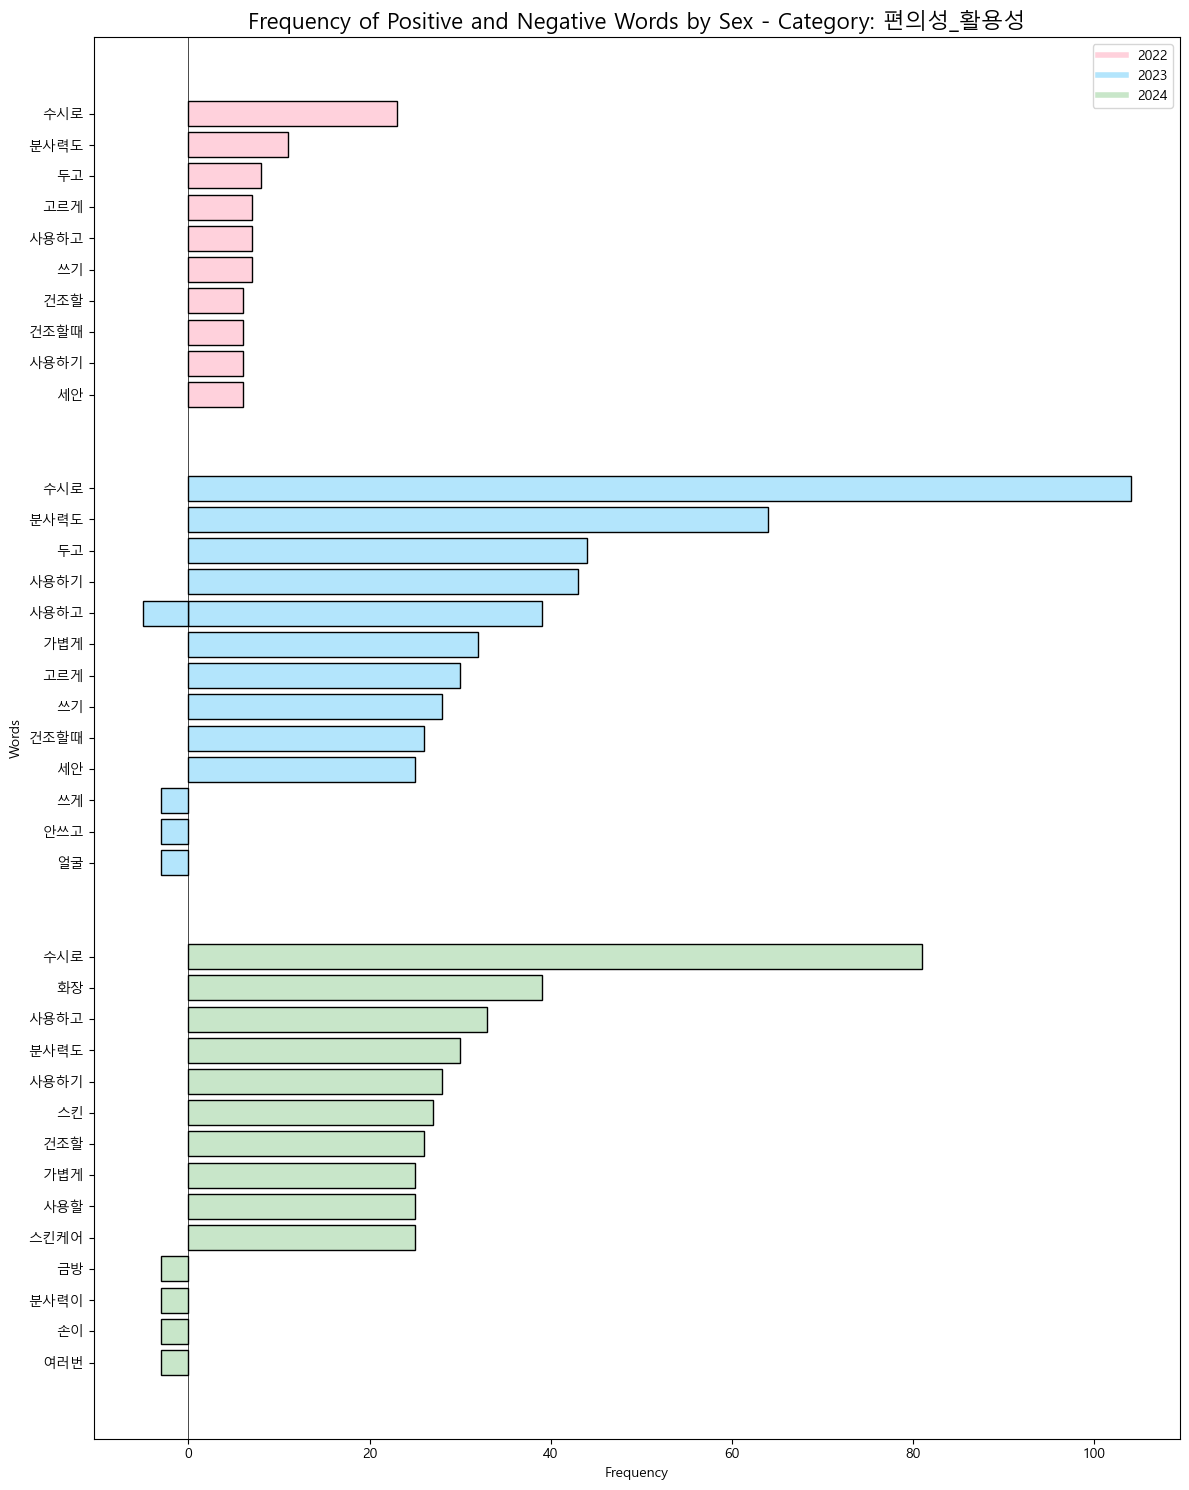

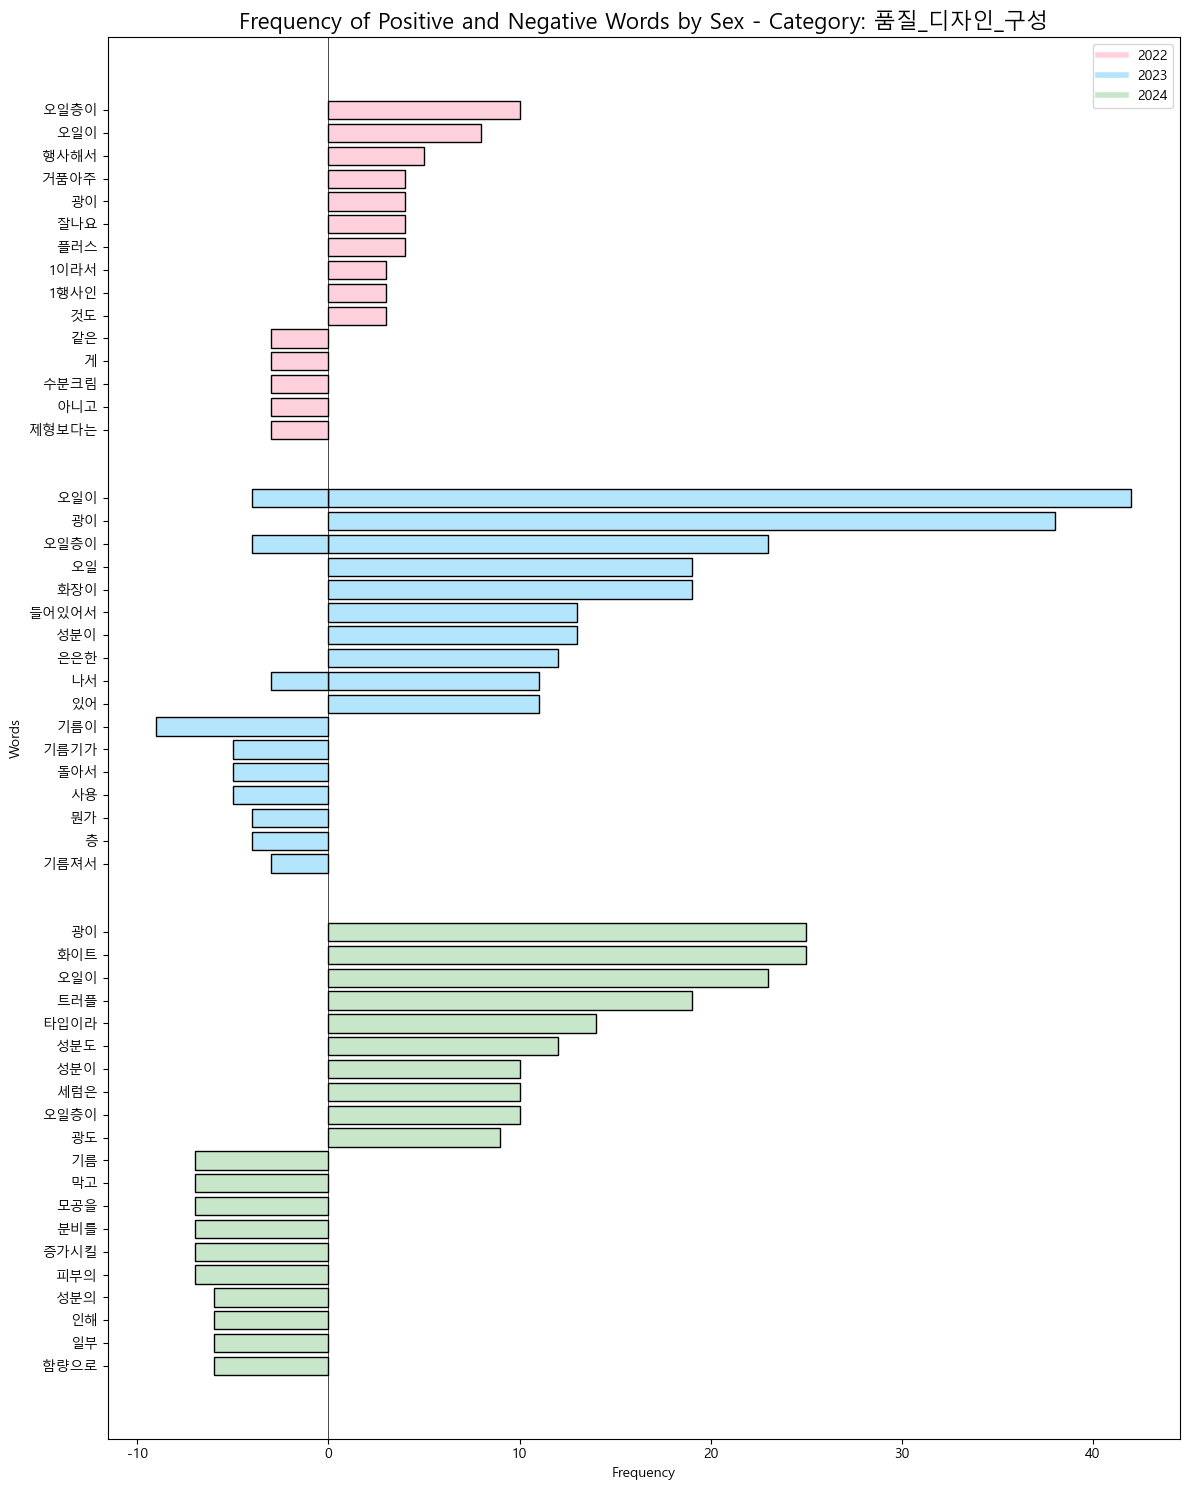

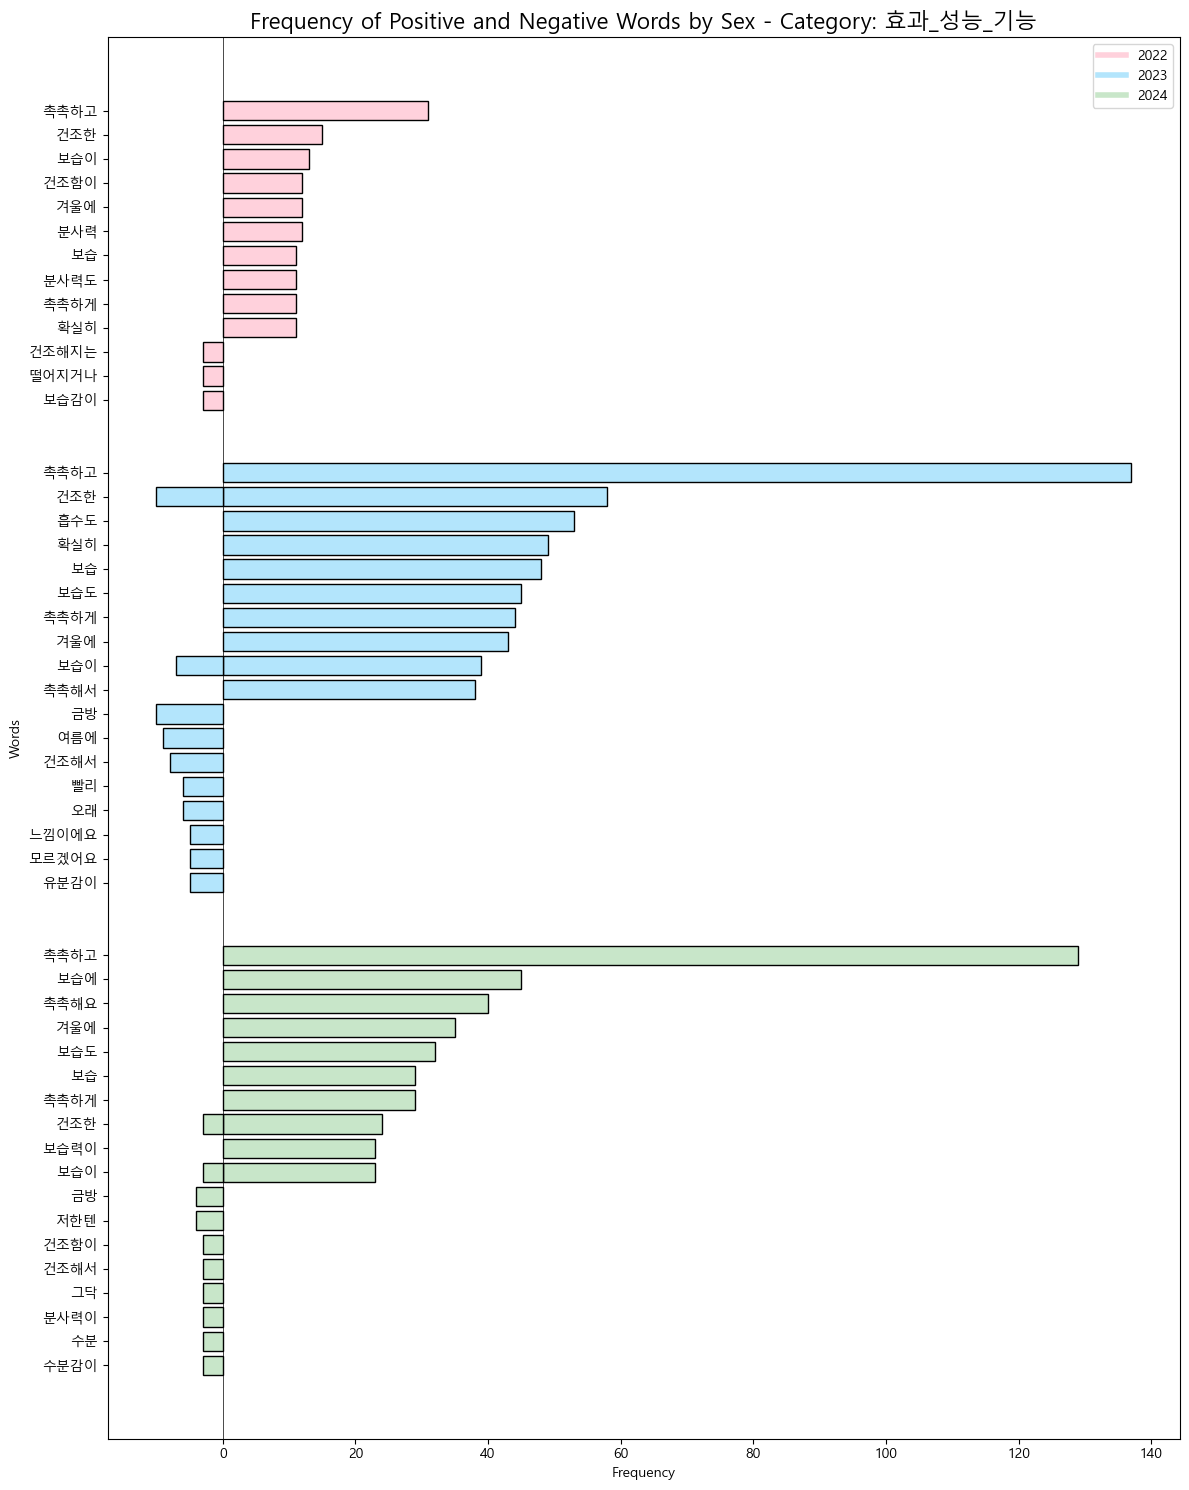

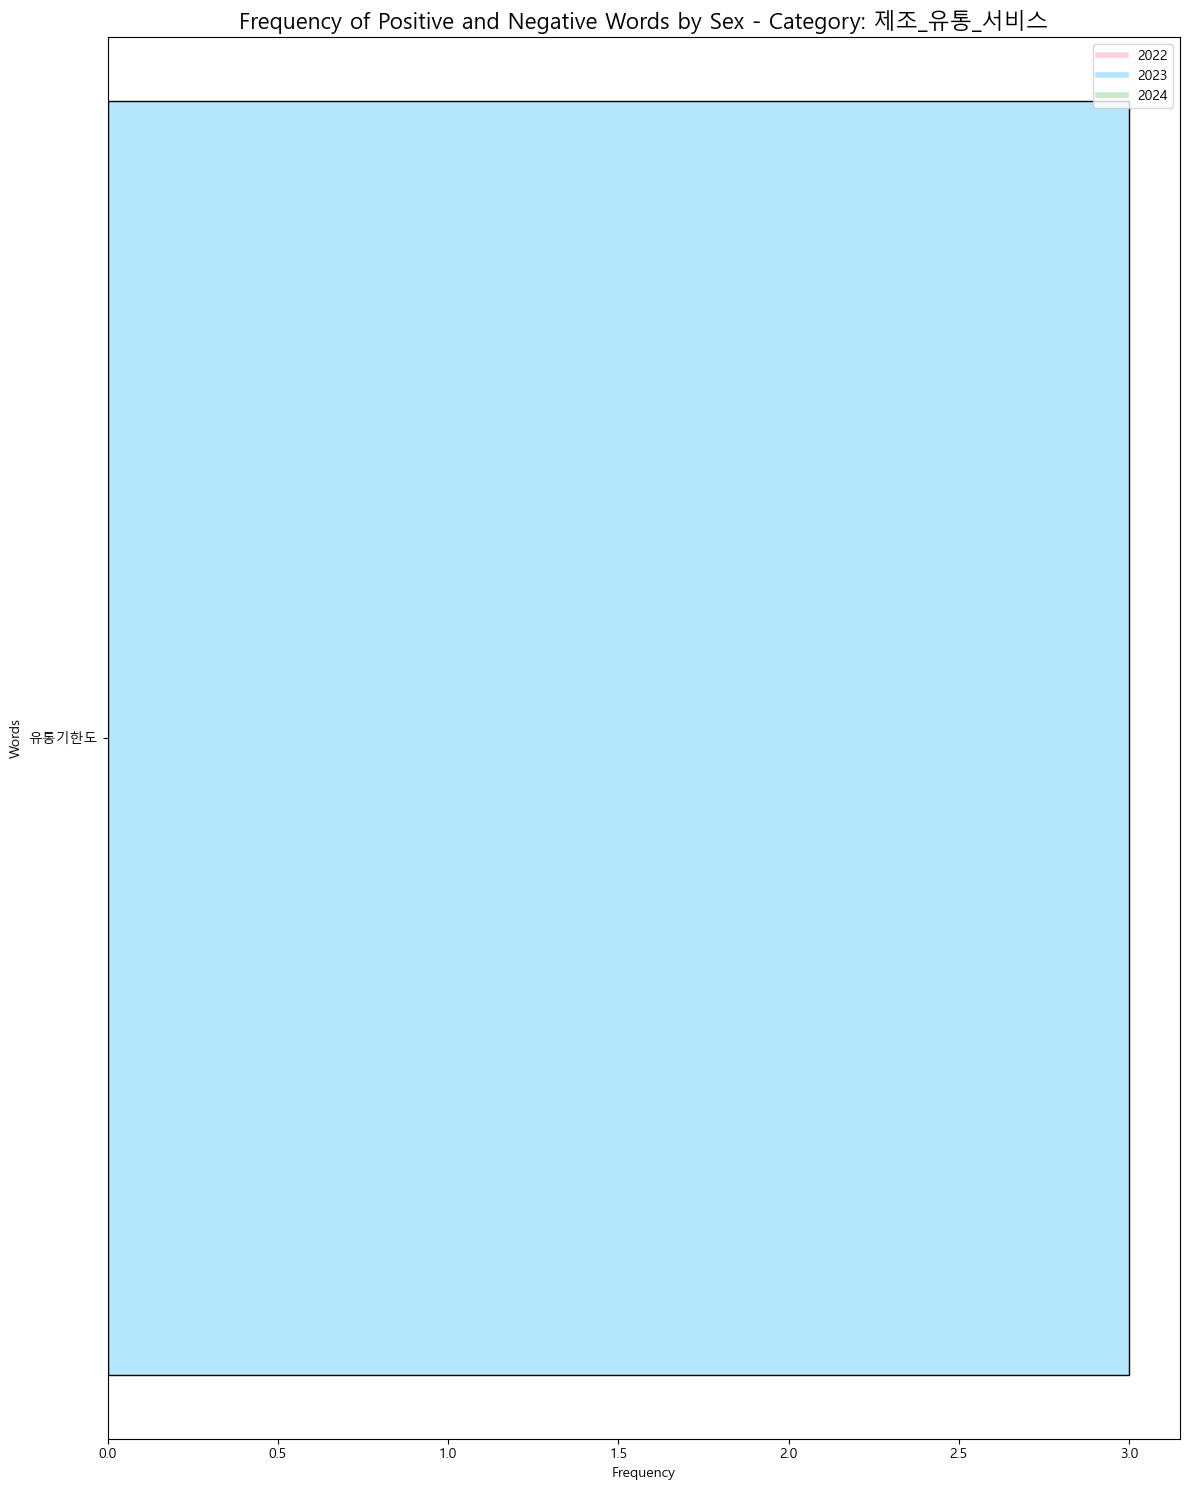

In [47]:
import matplotlib.pyplot as plt
import unicodedata
import pandas as pd
from matplotlib import font_manager, rc


# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


# Unicode 정규화 함수 정의
def normalize_text(text):
    return unicodedata.normalize('NFC', text)

# 브랜드 색상 설정 (정규화 적용 - 년도별 파스텔 톤)
brand_colors = {
    normalize_text('2022'): '#FFD1DC',  # 부드러운 파스텔 핑크 (새로운 시작과 따뜻함)
    normalize_text('2023'): '#B3E5FC',  # 맑고 시원한 하늘색 (성장과 안정)
    normalize_text('2024'): '#C8E6C9',  # 싱그러운 파스텔 그린 (새로운 도전과 활기)
}


# 데이터 정규화 (모든 문자열 필드에 정규화 적용)
df['Brand'] = df['Brand'].apply(normalize_text)
df['Category'] = df['Category'].apply(normalize_text)
df['Sentiment'] = df['Sentiment'].apply(normalize_text)
df['Word'] = df['Word'].apply(normalize_text)

# 빈도수 5 이상인 데이터만 필터링
filtered_df = df[df['Frequency'] >= 3]

# 중복 단어 제거: 같은 브랜드 내에서 동일한 단어의 긍정/부정 빈도를 합산
filtered_df = filtered_df.groupby(['Brand', 'Category', 'Word', 'Sentiment'], as_index=False)['Frequency'].sum()

# 카테고리별로 그래프 그리기
for category in filtered_df['Category'].unique():
    # 카테고리별 데이터 필터링
    category_data = filtered_df[filtered_df['Category'] == normalize_text(category)]

    fig, ax = plt.subplots(figsize=(12, 15))
    
    ax.set_title(normalize_text(f"Frequency of Positive and Negative Words by Sex - Category: {category}"), fontsize=16)

    # 단어 레이블과 위치 저장을 위한 리스트 초기화
    words = []
    y_positions = []
    offset = 0  # y축 위치 오프셋

    # 각 브랜드별로 상단부터 달바, 바이오힐보, 아벤느 순으로 정렬
    for brand in ['2022','2023','2024']:
        # 브랜드별 데이터 필터링
        brand_data = category_data[category_data['Brand'] == normalize_text(brand)]

        # 긍정 단어 상위 10개와 부정 단어 상위 10개 선택
        positive_words = brand_data[brand_data['Sentiment'] == 'positive'].nlargest(10, 'Frequency')
        negative_words = brand_data[brand_data['Sentiment'] == 'negative'].nlargest(10, 'Frequency')

        # 긍정 단어와 부정 단어 결합
        combined_words = pd.concat([positive_words, negative_words]).drop_duplicates(subset=['Word'], keep='first')

        # 긍정 단어 우선 정렬, 이후 남은 부정 단어 내림차순 정렬
        sorted_words = pd.concat([
            combined_words[combined_words['Sentiment'] == 'positive'].sort_values(by='Frequency', ascending=False),
            combined_words[(combined_words['Sentiment'] == 'negative') & (~combined_words['Word'].isin(positive_words['Word']))].sort_values(by='Frequency', ascending=False)
        ])

        # 단어별로 긍정/부정 데이터를 결합하여 표시
        for _, row in sorted_words.iterrows():
            word = row['Word']
            pos_data = positive_words[positive_words['Word'] == word]
            neg_data = negative_words[negative_words['Word'] == word]

            # y축 위치 설정
            y_pos = offset
            words.append(word)
            y_positions.append(y_pos)

            # 긍정 단어가 있는 경우 막대 그리기 (오른쪽 방향)
            if not pos_data.empty:
                pos_frequency = pos_data['Frequency'].sum()
                ax.barh(y_pos, pos_frequency, height=0.8, color=brand_colors[brand], edgecolor='black')

            # 부정 단어가 있는 경우 막대 그리기 (왼쪽 방향)
            if not neg_data.empty:
                neg_frequency = neg_data['Frequency'].sum()
                ax.barh(y_pos, -neg_frequency, height=0.8, color=brand_colors[brand], edgecolor='black')

            # 다음 단어로 이동
            offset += 1

        # 브랜드 간 여백 추가
        offset += 2  # 각 브랜드 사이에 여백을 추가

    # y축 레이블 설정 및 축 반전
    ax.set_yticks(y_positions)
    ax.set_yticklabels(words, fontsize=10)
    plt.gca().invert_yaxis()  # y축을 반전시켜 긍정 단어가 상단에 위치하도록 설정

    # 축 및 레이블 설정
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')
    
    ax.axvline(0, color='black', linewidth=0.5)  # 중앙 기준선 추가

    # 범례 추가 (브랜드별 색상만 표시)
    brand_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in brand_colors.values()]
    brand_labels = list(brand_colors.keys())
    ax.legend(brand_handles, brand_labels, loc="upper right")

    plt.tight_layout()
    plt.show()


# 연령

In [ ]:
import json
import os
import re
import pandas as pd

folder_path = r"\Users\kyn03\OneDrive\바탕 화면\project_file\이탈\워드클라우드_json\연령대"

# 제거할 불용어 리스트 정의
stopwords = ["있어요", "합니다", "입니다", "같아요", "있는", "않고","맞는", "뿌리면","뿌리고","뿌리는","뭐가","좋은","좋아요","좋고","뿌려주면","뿌리기",
             "않아요","좋아서","않아서","하고","좋습니다","거","구매했어요","아니라","하고","정말","많은","뿌려주고","좋았어요", "뿌려주기", "뿌려도",
             "안되고","있습니다","줄","샀어요","구매해서","사서","샀습니다","피부에","피부가","꽤","가격이","가격은","100","피부에","피부","후","해서",
             "가격도","구매했습니다","얼굴에", "가격에","300", "없고","없이","피부에는","넘"]  # 필요에 따라 불용어 추가

# 데이터를 담을 딕셔너리 생성
data = {}
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        filename = filename.replace(" ", "")  # 파일 이름에서 공백 제거
        path = os.path.join(folder_path, filename)

        with open(path, "r", encoding="utf-8") as file:
            # 파일 이름에서 브랜드, 카테고리, 감정 추출
            match = re.match(r"^[가-힣]+_(10대|20대|30대|40대이상)_((?:[\w가-힣]+_?)+)_(positive|negative).*\.json$", filename)
            if match:
                brand = match.group(1)       # 첫 번째 그룹: 브랜드명
                category = match.group(2)    # 두 번째 그룹: 속성명 (다중 언더스코어 포함 가능)
                sentiment = match.group(3)   # 세 번째 그룹: 긍정/부정

                # JSON 파일에서 단어 데이터를 읽어와서 리스트로 저장
                words = json.load(file)
                for word, count in words.items():
                    # 불용어 필터링
                    if word not in stopwords:
                        data.setdefault((brand, category, sentiment), []).append((word, count))
            else:
                print(f"파일명 형식이 맞지 않음: {filename}")

# 데이터를 DataFrame으로 변환
df = pd.DataFrame(columns=["Brand", "Category", "Sentiment", "Word", "Frequency"])

# 데이터프레임에 데이터 추가
rows = []
for (brand, category, sentiment), words in data.items():
    # 빈도수가 높은 순서대로 정렬
    sorted_words = sorted(words, key=lambda x: x[1], reverse=True)
    for word, count in sorted_words:
        rows.append({
            "Brand": brand,
            "Category": category,
            "Sentiment": sentiment,
            "Word": word,
            "Frequency": count
        })

# DataFrame에 데이터를 추가
df = pd.DataFrame(rows)

# Frequency를 숫자형으로 변환
df['Frequency'] = pd.to_numeric(df['Frequency'], errors='coerce')

# 결과 출력
print(df)

       Brand  Category Sentiment   Word  Frequency
0        10대        가격  negative     비싼          1
1        10대        가격  negative    사주께          1
2        10대        가격  positive   세일하는          1
3        10대        가격  positive   세일할때          1
4        10대        가격  positive  할인중이라          1
...      ...       ...       ...    ...        ...
13270  40대이상  효과_성능_기능  positive   보충돼서          1
13271  40대이상  효과_성능_기능  positive   수분감도          1
13272  40대이상  효과_성능_기능  positive   미스트에          1
13273  40대이상  효과_성능_기능  positive    비해서          1
13274  40대이상  효과_성능_기능  positive    보습력          1

[13275 rows x 5 columns]


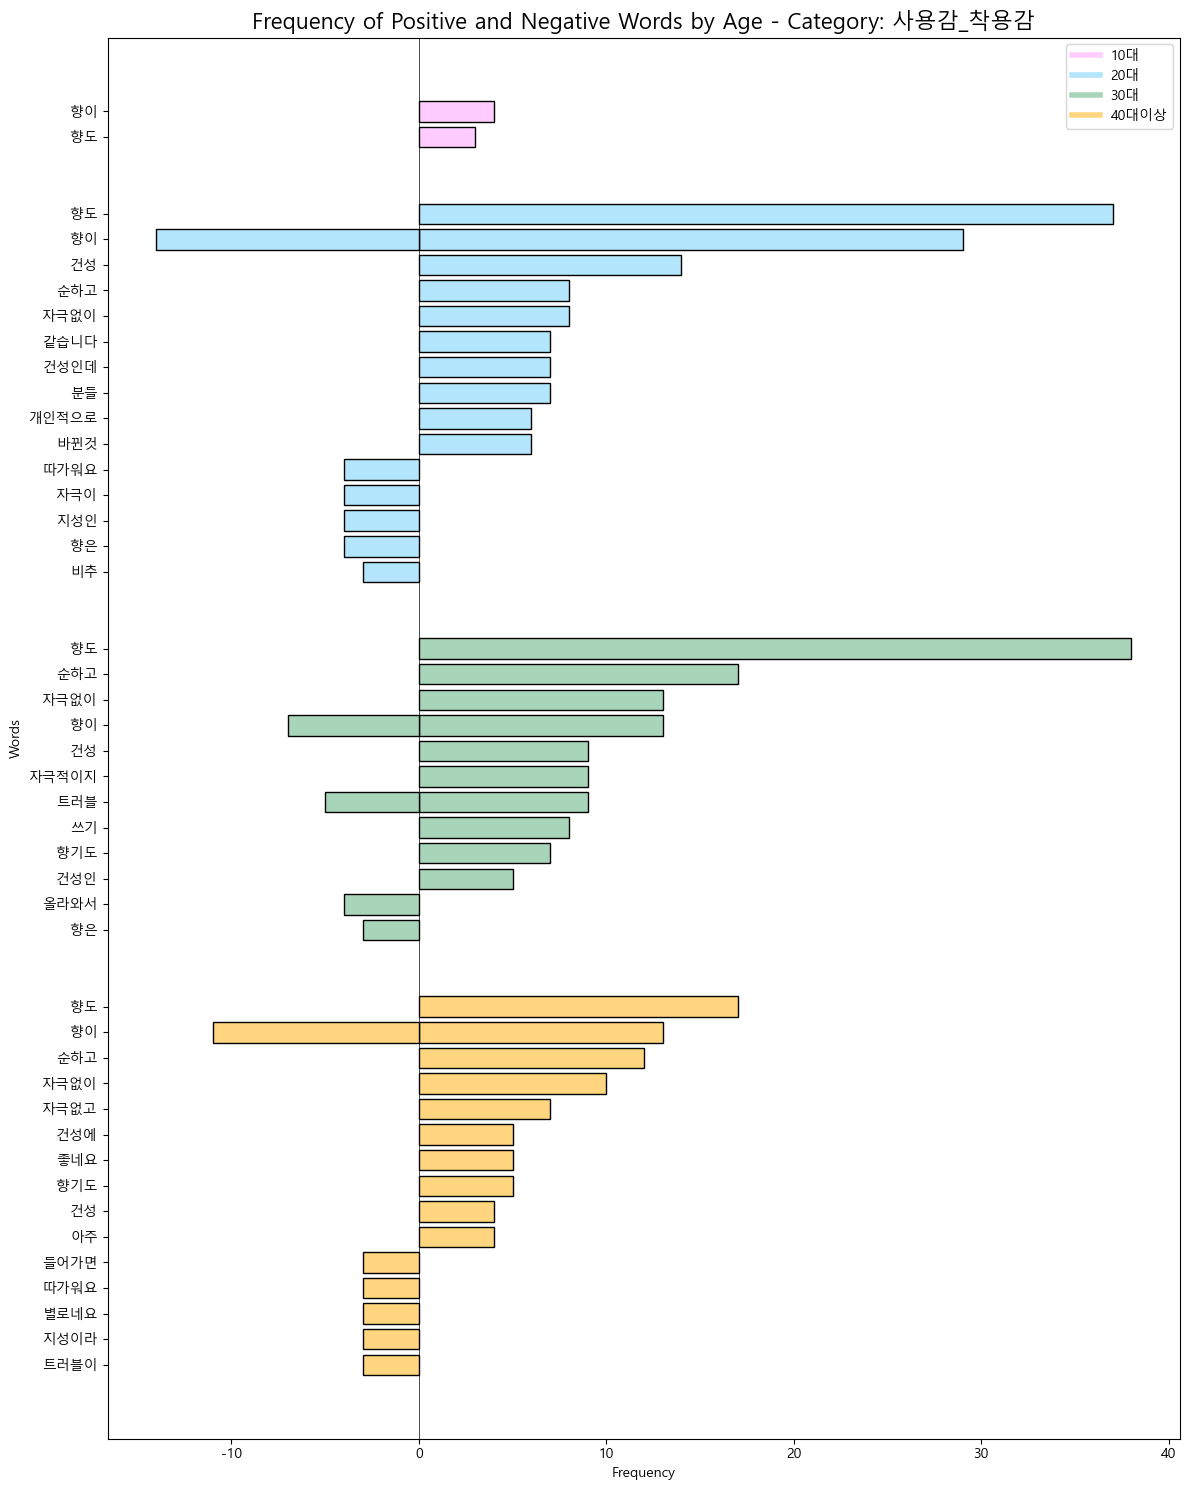

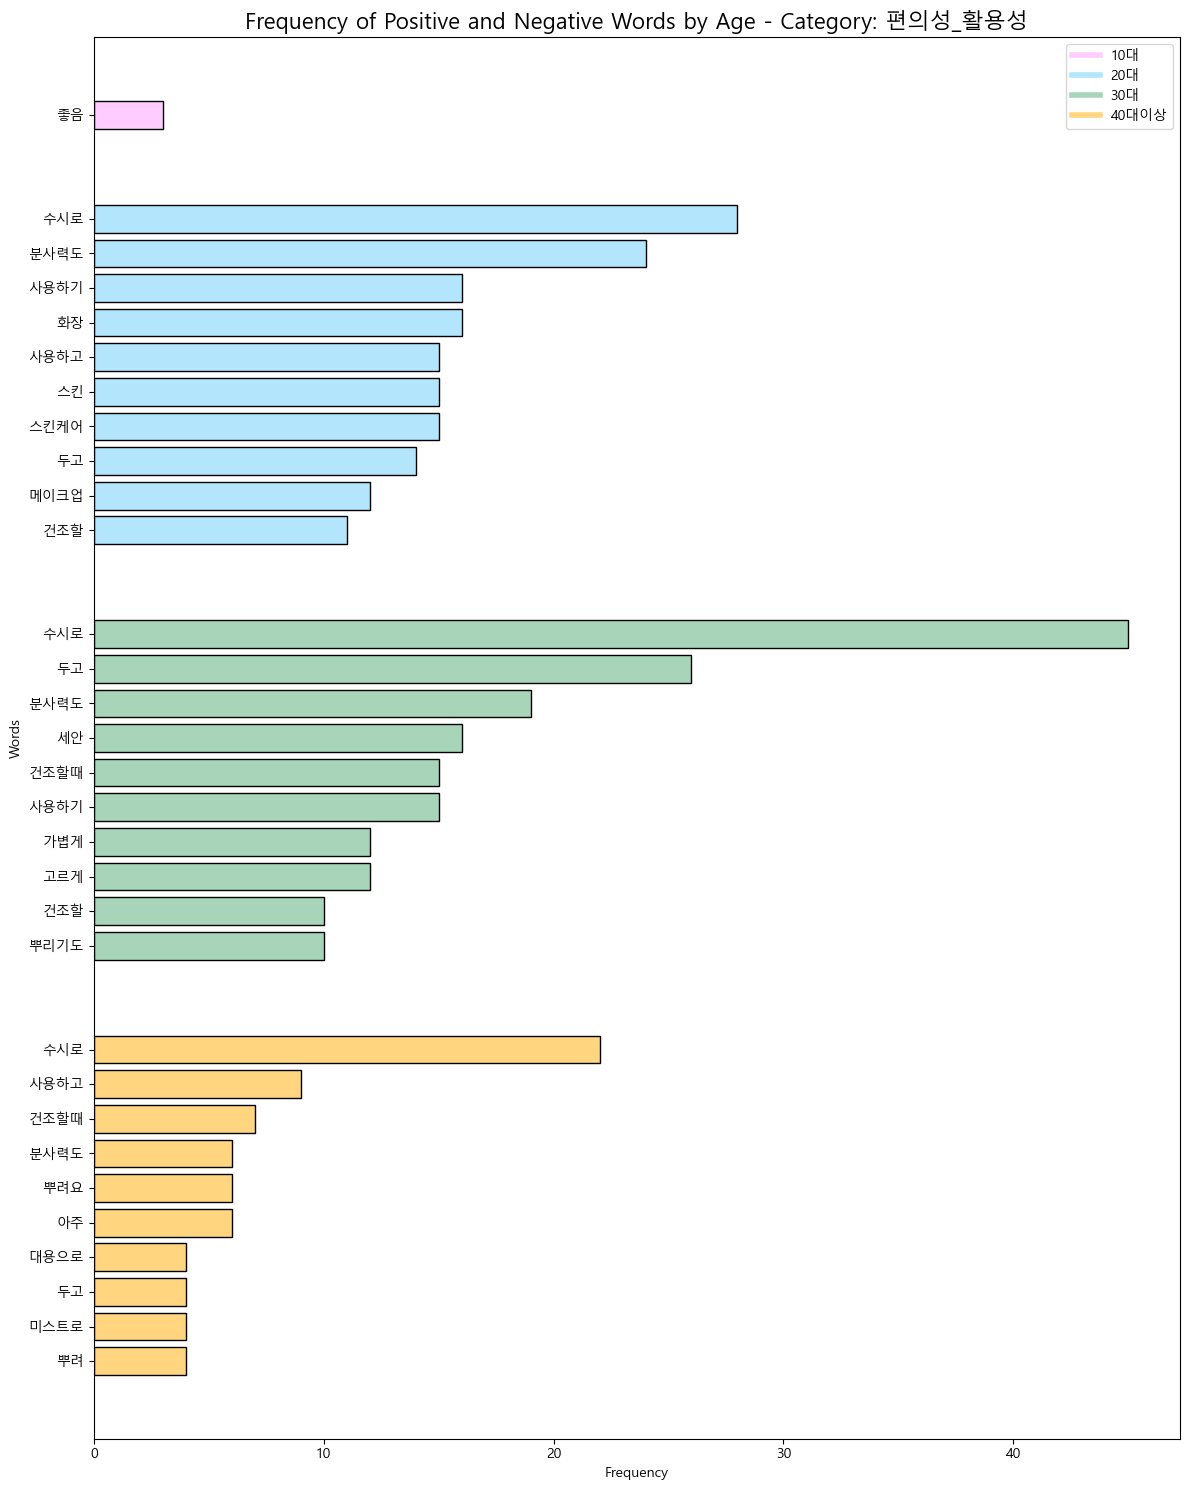

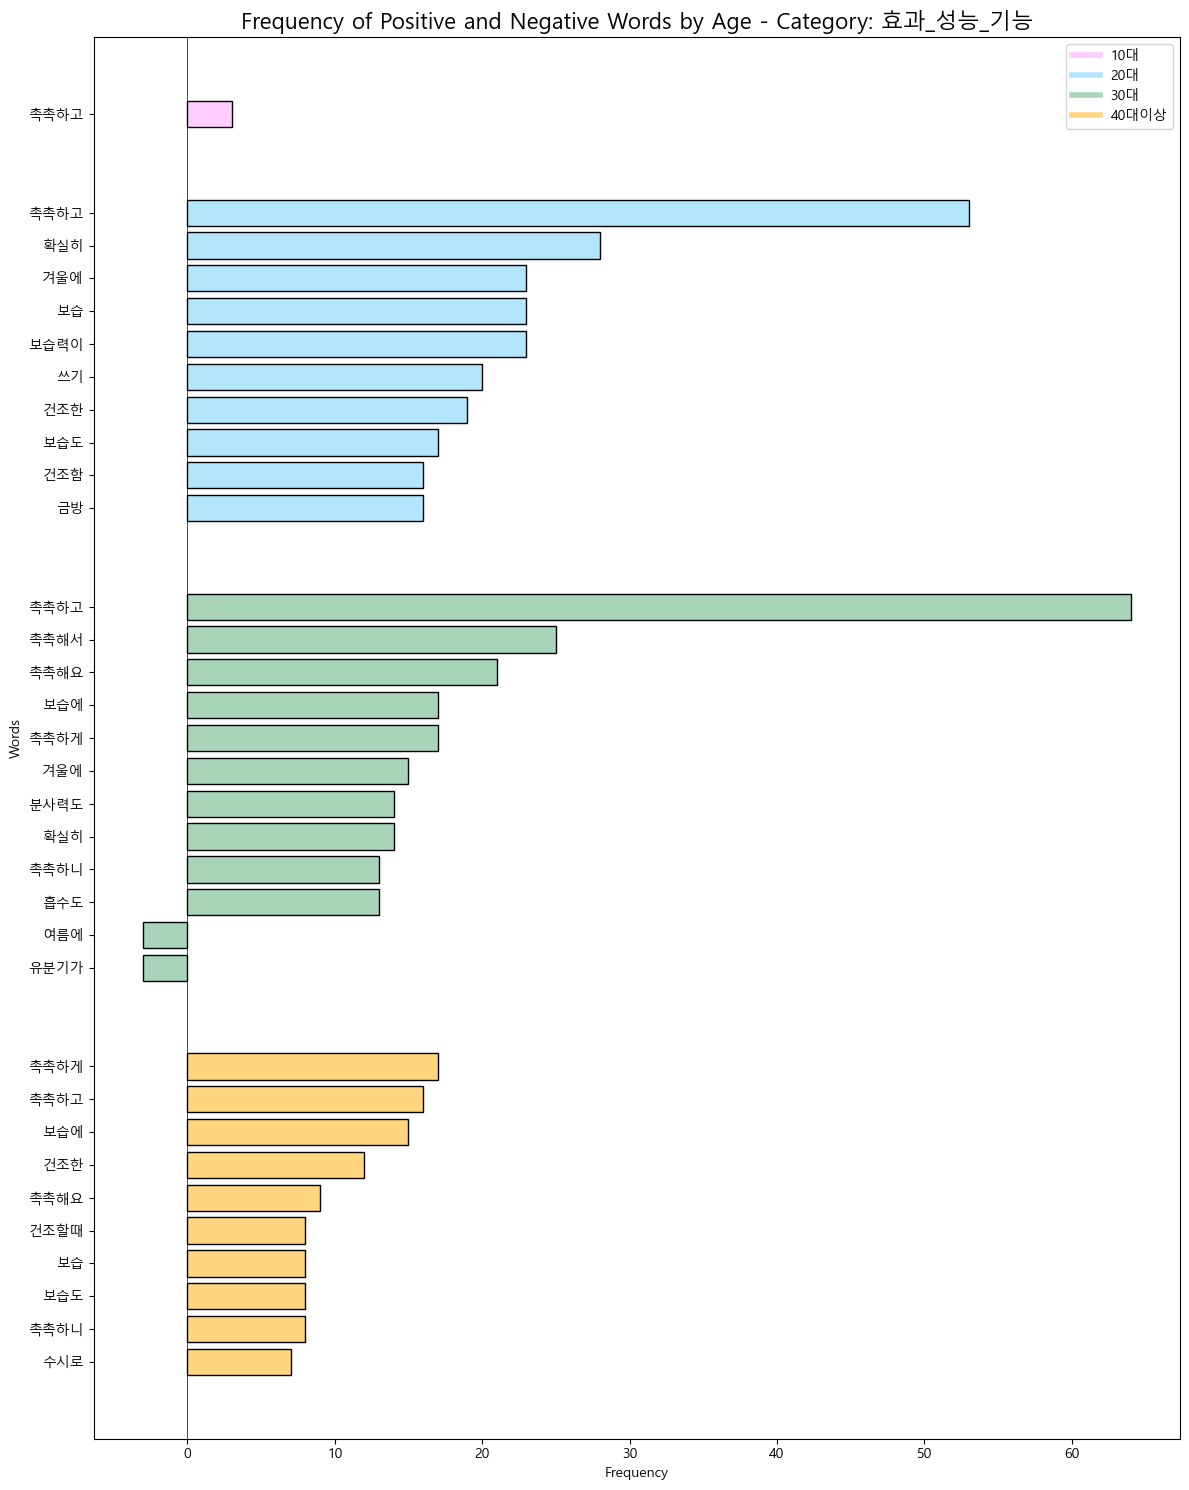

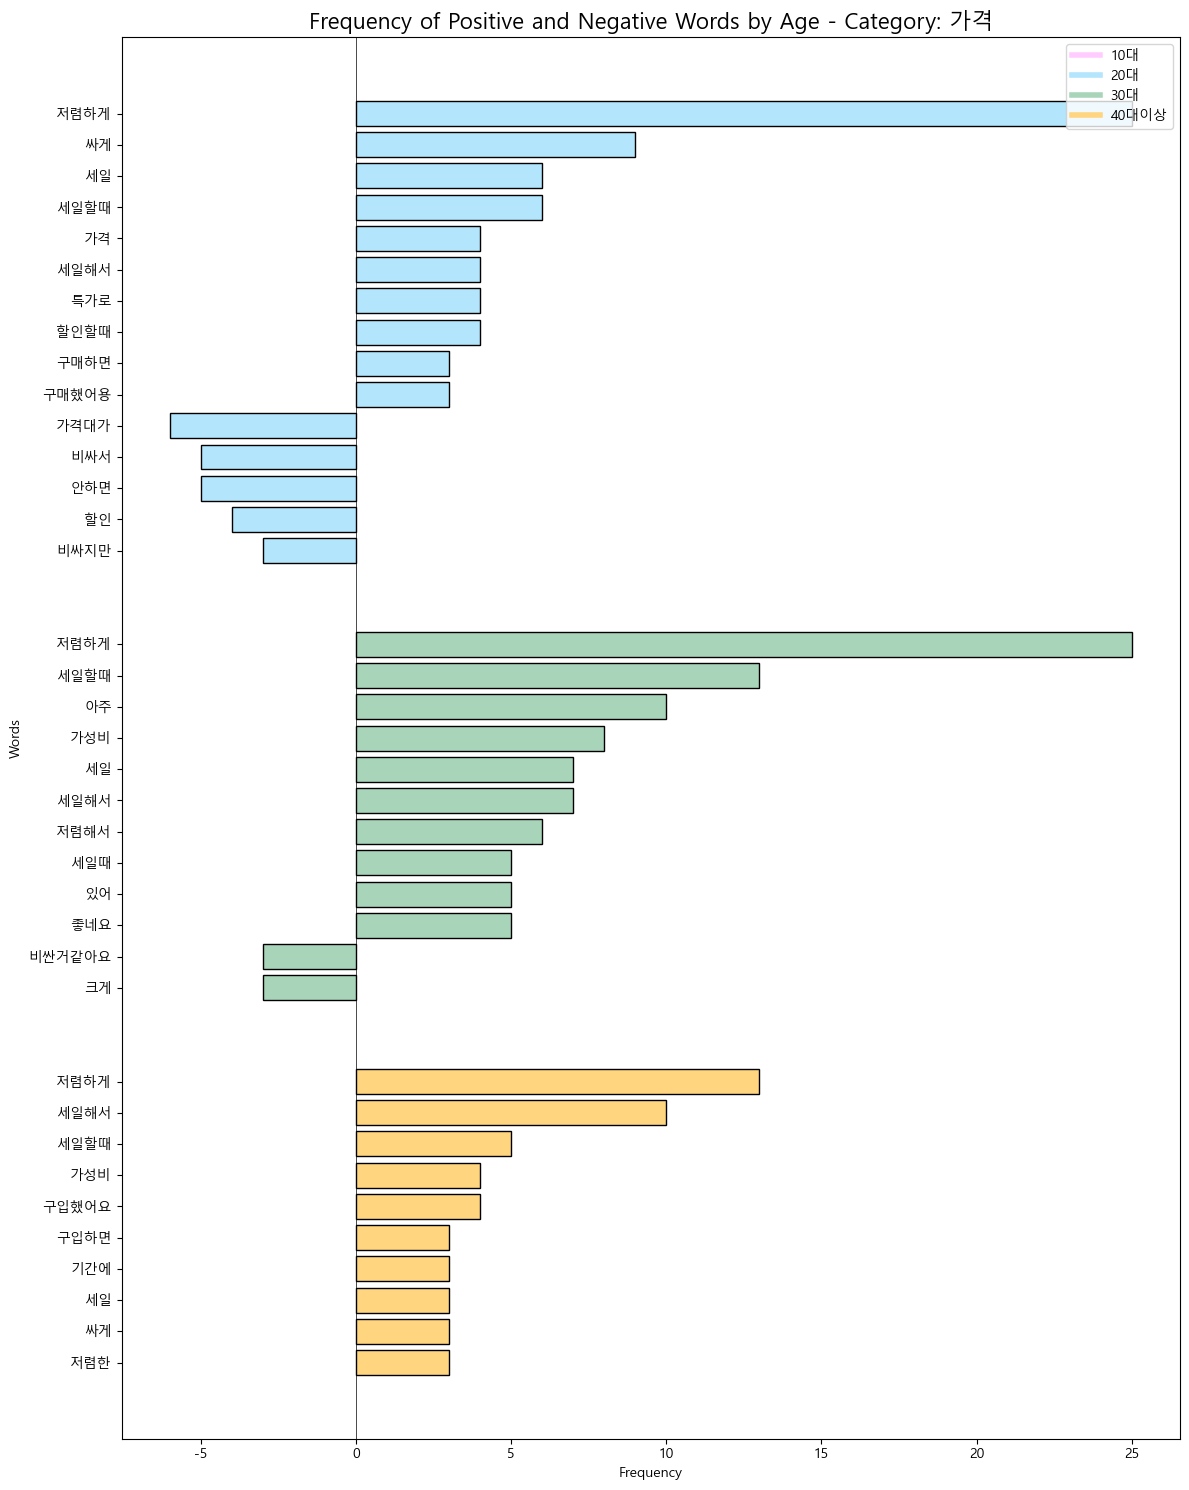

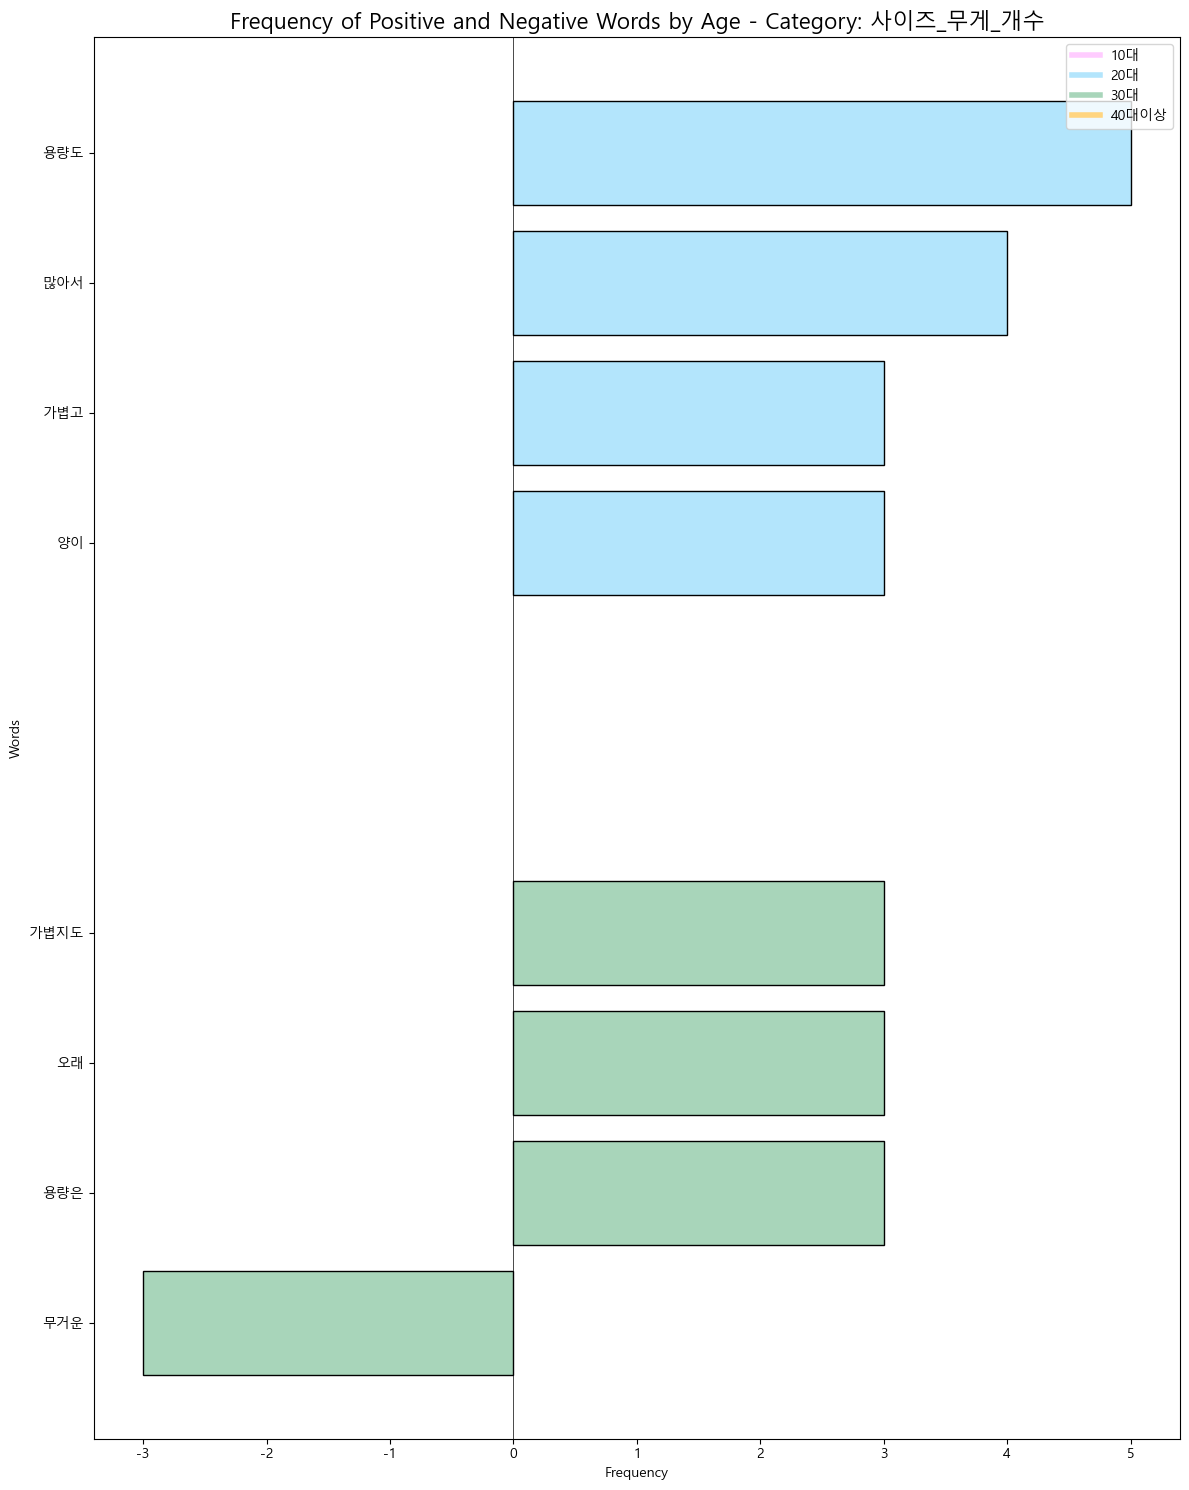

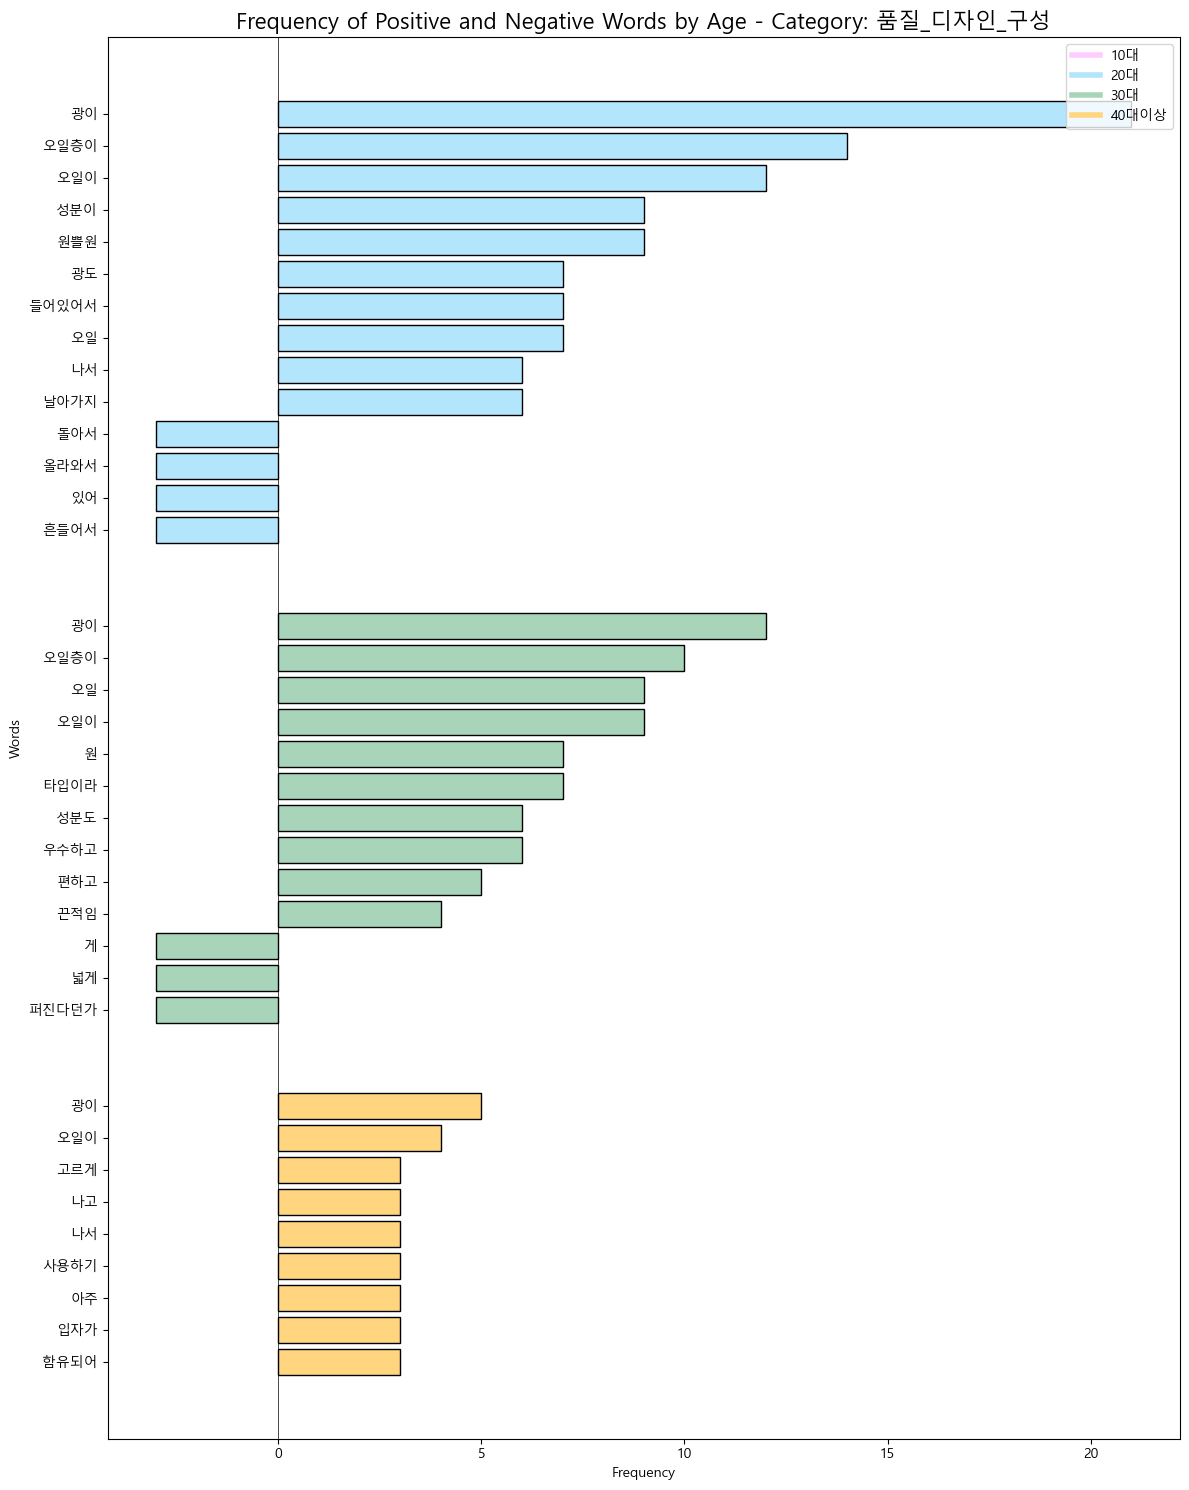

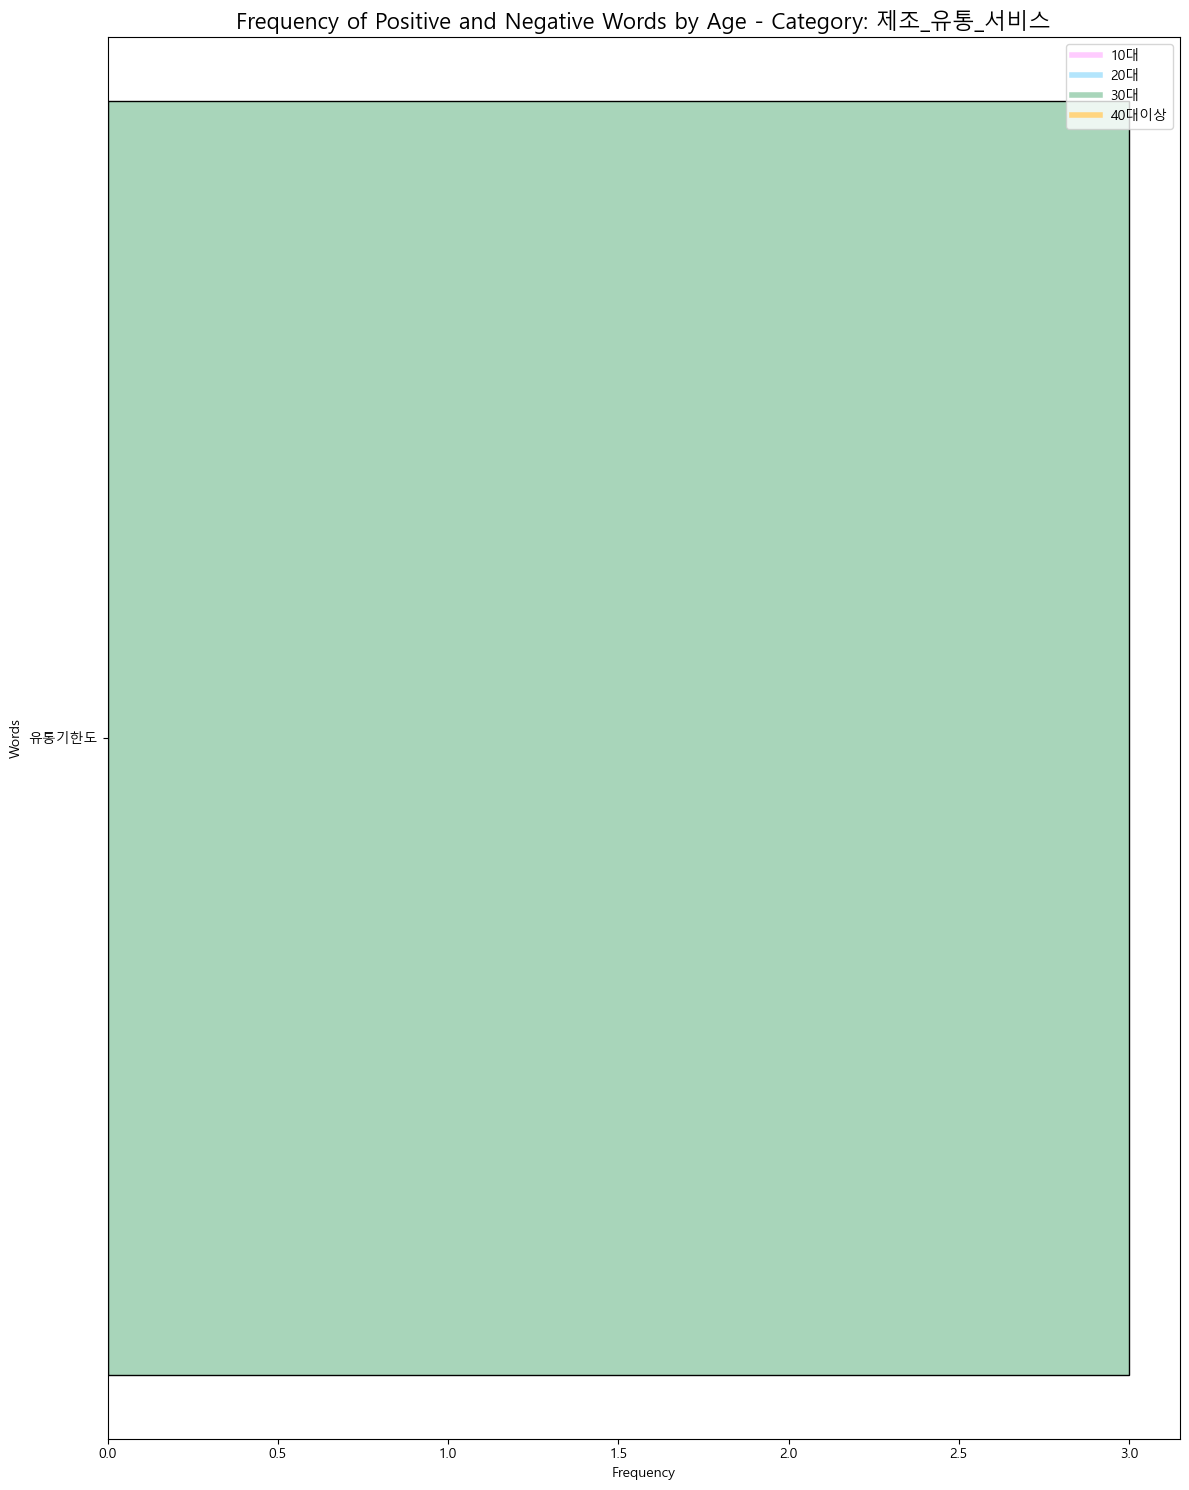

In [ ]:
import matplotlib.pyplot as plt
import unicodedata
import pandas as pd
from matplotlib import font_manager, rc


# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


# Unicode 정규화 함수 정의
def normalize_text(text):
    return unicodedata.normalize('NFC', text)

# 브랜드 색상 설정 (정규화 적용 - 나이대별 파스텔 톤)
brand_colors = {
    normalize_text('10대'): '#FFCCFF',  # 부드러운 라벤더 핑크 (발랄하고 생기 넘치는 느낌)
    normalize_text('20대'): '#B3E5FC',  # 청량한 하늘색 (자유롭고 시원한 느낌)
    normalize_text('30대'): '#A8D5BA',  # 차분한 민트 그린 (안정적이고 세련된 느낌)
    normalize_text('40대이상'): '#FFD580',  # 따뜻한 파스텔 오렌지 (포근하고 성숙한 느낌)
}


# 데이터 정규화 (모든 문자열 필드에 정규화 적용)
df['Brand'] = df['Brand'].apply(normalize_text)
df['Category'] = df['Category'].apply(normalize_text)
df['Sentiment'] = df['Sentiment'].apply(normalize_text)
df['Word'] = df['Word'].apply(normalize_text)

# 빈도수 5 이상인 데이터만 필터링
filtered_df = df[df['Frequency'] >= 3]

# 중복 단어 제거: 같은 브랜드 내에서 동일한 단어의 긍정/부정 빈도를 합산
filtered_df = filtered_df.groupby(['Brand', 'Category', 'Word', 'Sentiment'], as_index=False)['Frequency'].sum()

# 카테고리별로 그래프 그리기
for category in filtered_df['Category'].unique():
    # 카테고리별 데이터 필터링
    category_data = filtered_df[filtered_df['Category'] == normalize_text(category)]

    fig, ax = plt.subplots(figsize=(12, 15))
    
    ax.set_title(normalize_text(f"Frequency of Positive and Negative Words by Age - Category: {category}"), fontsize=16)

    # 단어 레이블과 위치 저장을 위한 리스트 초기화
    words = []
    y_positions = []
    offset = 0  # y축 위치 오프셋

    # 각 브랜드별로 상단부터 달바, 바이오힐보, 아벤느 순으로 정렬
    for brand in ['10대','20대','30대','40대이상']:
        # 브랜드별 데이터 필터링
        brand_data = category_data[category_data['Brand'] == normalize_text(brand)]

        # 긍정 단어 상위 10개와 부정 단어 상위 10개 선택
        positive_words = brand_data[brand_data['Sentiment'] == 'positive'].nlargest(10, 'Frequency')
        negative_words = brand_data[brand_data['Sentiment'] == 'negative'].nlargest(10, 'Frequency')

        # 긍정 단어와 부정 단어 결합
        combined_words = pd.concat([positive_words, negative_words]).drop_duplicates(subset=['Word'], keep='first')

        # 긍정 단어 우선 정렬, 이후 남은 부정 단어 내림차순 정렬
        sorted_words = pd.concat([
            combined_words[combined_words['Sentiment'] == 'positive'].sort_values(by='Frequency', ascending=False),
            combined_words[(combined_words['Sentiment'] == 'negative') & (~combined_words['Word'].isin(positive_words['Word']))].sort_values(by='Frequency', ascending=False)
        ])

        # 단어별로 긍정/부정 데이터를 결합하여 표시
        for _, row in sorted_words.iterrows():
            word = row['Word']
            pos_data = positive_words[positive_words['Word'] == word]
            neg_data = negative_words[negative_words['Word'] == word]

            # y축 위치 설정
            y_pos = offset
            words.append(word)
            y_positions.append(y_pos)

            # 긍정 단어가 있는 경우 막대 그리기 (오른쪽 방향)
            if not pos_data.empty:
                pos_frequency = pos_data['Frequency'].sum()
                ax.barh(y_pos, pos_frequency, height=0.8, color=brand_colors[brand], edgecolor='black')

            # 부정 단어가 있는 경우 막대 그리기 (왼쪽 방향)
            if not neg_data.empty:
                neg_frequency = neg_data['Frequency'].sum()
                ax.barh(y_pos, -neg_frequency, height=0.8, color=brand_colors[brand], edgecolor='black')

            # 다음 단어로 이동
            offset += 1

        # 브랜드 간 여백 추가
        offset += 2  # 각 브랜드 사이에 여백을 추가

    # y축 레이블 설정 및 축 반전
    ax.set_yticks(y_positions)
    ax.set_yticklabels(words, fontsize=10)
    plt.gca().invert_yaxis()  # y축을 반전시켜 긍정 단어가 상단에 위치하도록 설정

    # 축 및 레이블 설정
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')
    
    ax.axvline(0, color='black', linewidth=0.5)  # 중앙 기준선 추가

    # 범례 추가 (브랜드별 색상만 표시)
    brand_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in brand_colors.values()]
    brand_labels = list(brand_colors.keys())
    ax.legend(brand_handles, brand_labels, loc="upper right")

    plt.tight_layout()
    plt.show()


# 월

In [33]:
import json
import os
import re
import pandas as pd

folder_path = r"\Users\kyn03\OneDrive\바탕 화면\project_file\output\워드클라우드_json\월"

# 제거할 불용어 리스트 정의
stopwords = ["있어요", "합니다", "입니다", "같아요", "있는", "않고","맞는", "뿌리면","뿌리고","뿌리는","뭐가","좋은","좋아요","좋고","뿌려주면","뿌리기",
             "않아요","좋아서","않아서","하고","좋습니다","거","구매했어요","아니라","하고","정말","많은","뿌려주고","좋았어요", "뿌려주기", "뿌려도",
             "안되고","있습니다","줄","샀어요","구매해서","사서","샀습니다","피부에","피부가","꽤","가격이","가격은","100","피부에","피부","후","해서",
             "가격도","구매했습니다","얼굴에", "가격에","300", "없고","없이","피부에는","넘"]  # 필요에 따라 불용어 추가

# 데이터를 담을 딕셔너리 생성
data = {}
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        filename = filename.replace(" ", "")  # 파일 이름에서 공백 제거
        path = os.path.join(folder_path, filename)

        with open(path, "r", encoding="utf-8") as file:
            # 파일 이름에서 브랜드, 카테고리, 감정 추출
            match = re.match(r"^[가-힣]+_(\d{1,2}월)_[가-힣]+_((?:[\w가-힣]+_?)+)_(positive|negative).*\.json$", filename)
            if match:
                brand = match.group(1)       # 첫 번째 그룹: 브랜드명
                category = match.group(2)    # 두 번째 그룹: 속성명 (다중 언더스코어 포함 가능)
                sentiment = match.group(3)   # 세 번째 그룹: 긍정/부정

                # JSON 파일에서 단어 데이터를 읽어와서 리스트로 저장
                words = json.load(file)
                for word, count in words.items():
                    # 불용어 필터링
                    if word not in stopwords:
                        data.setdefault((brand, category, sentiment), []).append((word, count))
            else:
                print(f"파일명 형식이 맞지 않음: {filename}")

# 데이터를 DataFrame으로 변환
df = pd.DataFrame(columns=["Brand", "Category", "Sentiment", "Word", "Frequency"])

# 데이터프레임에 데이터 추가
rows = []
for (brand, category, sentiment), words in data.items():
    # 빈도수가 높은 순서대로 정렬
    sorted_words = sorted(words, key=lambda x: x[1], reverse=True)
    for word, count in sorted_words:
        rows.append({
            "Brand": brand,
            "Category": category,
            "Sentiment": sentiment,
            "Word": word,
            "Frequency": count
        })

# DataFrame에 데이터를 추가
df = pd.DataFrame(rows)

# Frequency를 숫자형으로 변환
df['Frequency'] = pd.to_numeric(df['Frequency'], errors='coerce')

# 결과 출력
print(df)

      Brand  Category Sentiment     Word  Frequency
0       10월        가격  negative       평소          1
1       10월        가격  negative    사악하지만          1
2       10월        가격  negative     비싼감이          1
3       10월        가격  negative      이렇게          1
4       10월        가격  negative      비싼데          1
...     ...       ...       ...      ...        ...
32303    9월  효과_성능_기능  positive    좋아지는게          1
32304    9월  효과_성능_기능  positive       눈에          1
32305    9월  효과_성능_기능  positive  사용가능합니다          1
32306    9월  효과_성능_기능  positive       완존          1
32307    9월  효과_성능_기능  positive    쫀쫀해져요          1

[32308 rows x 5 columns]


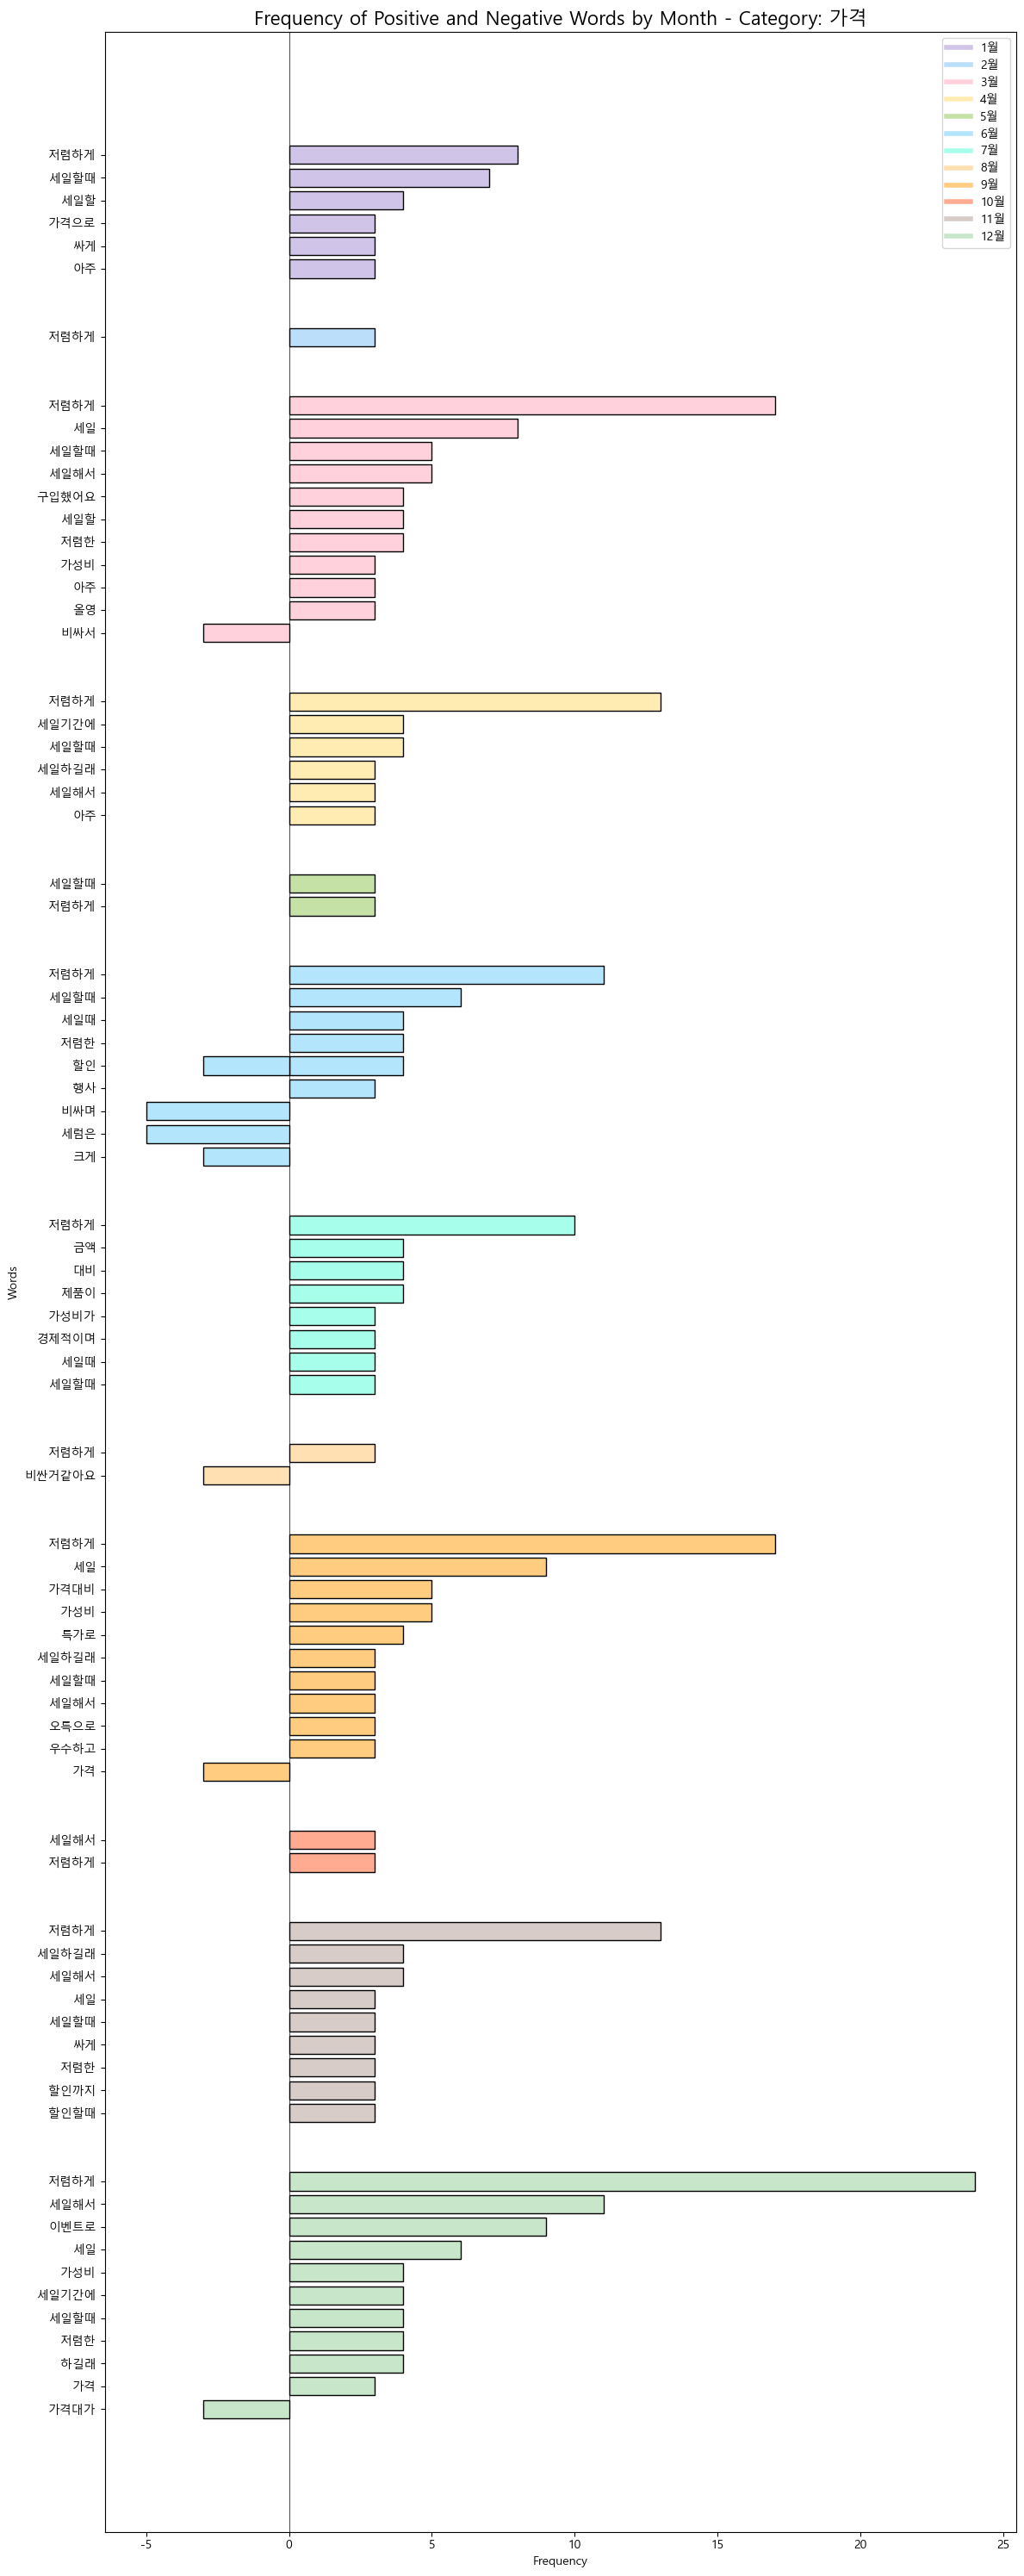

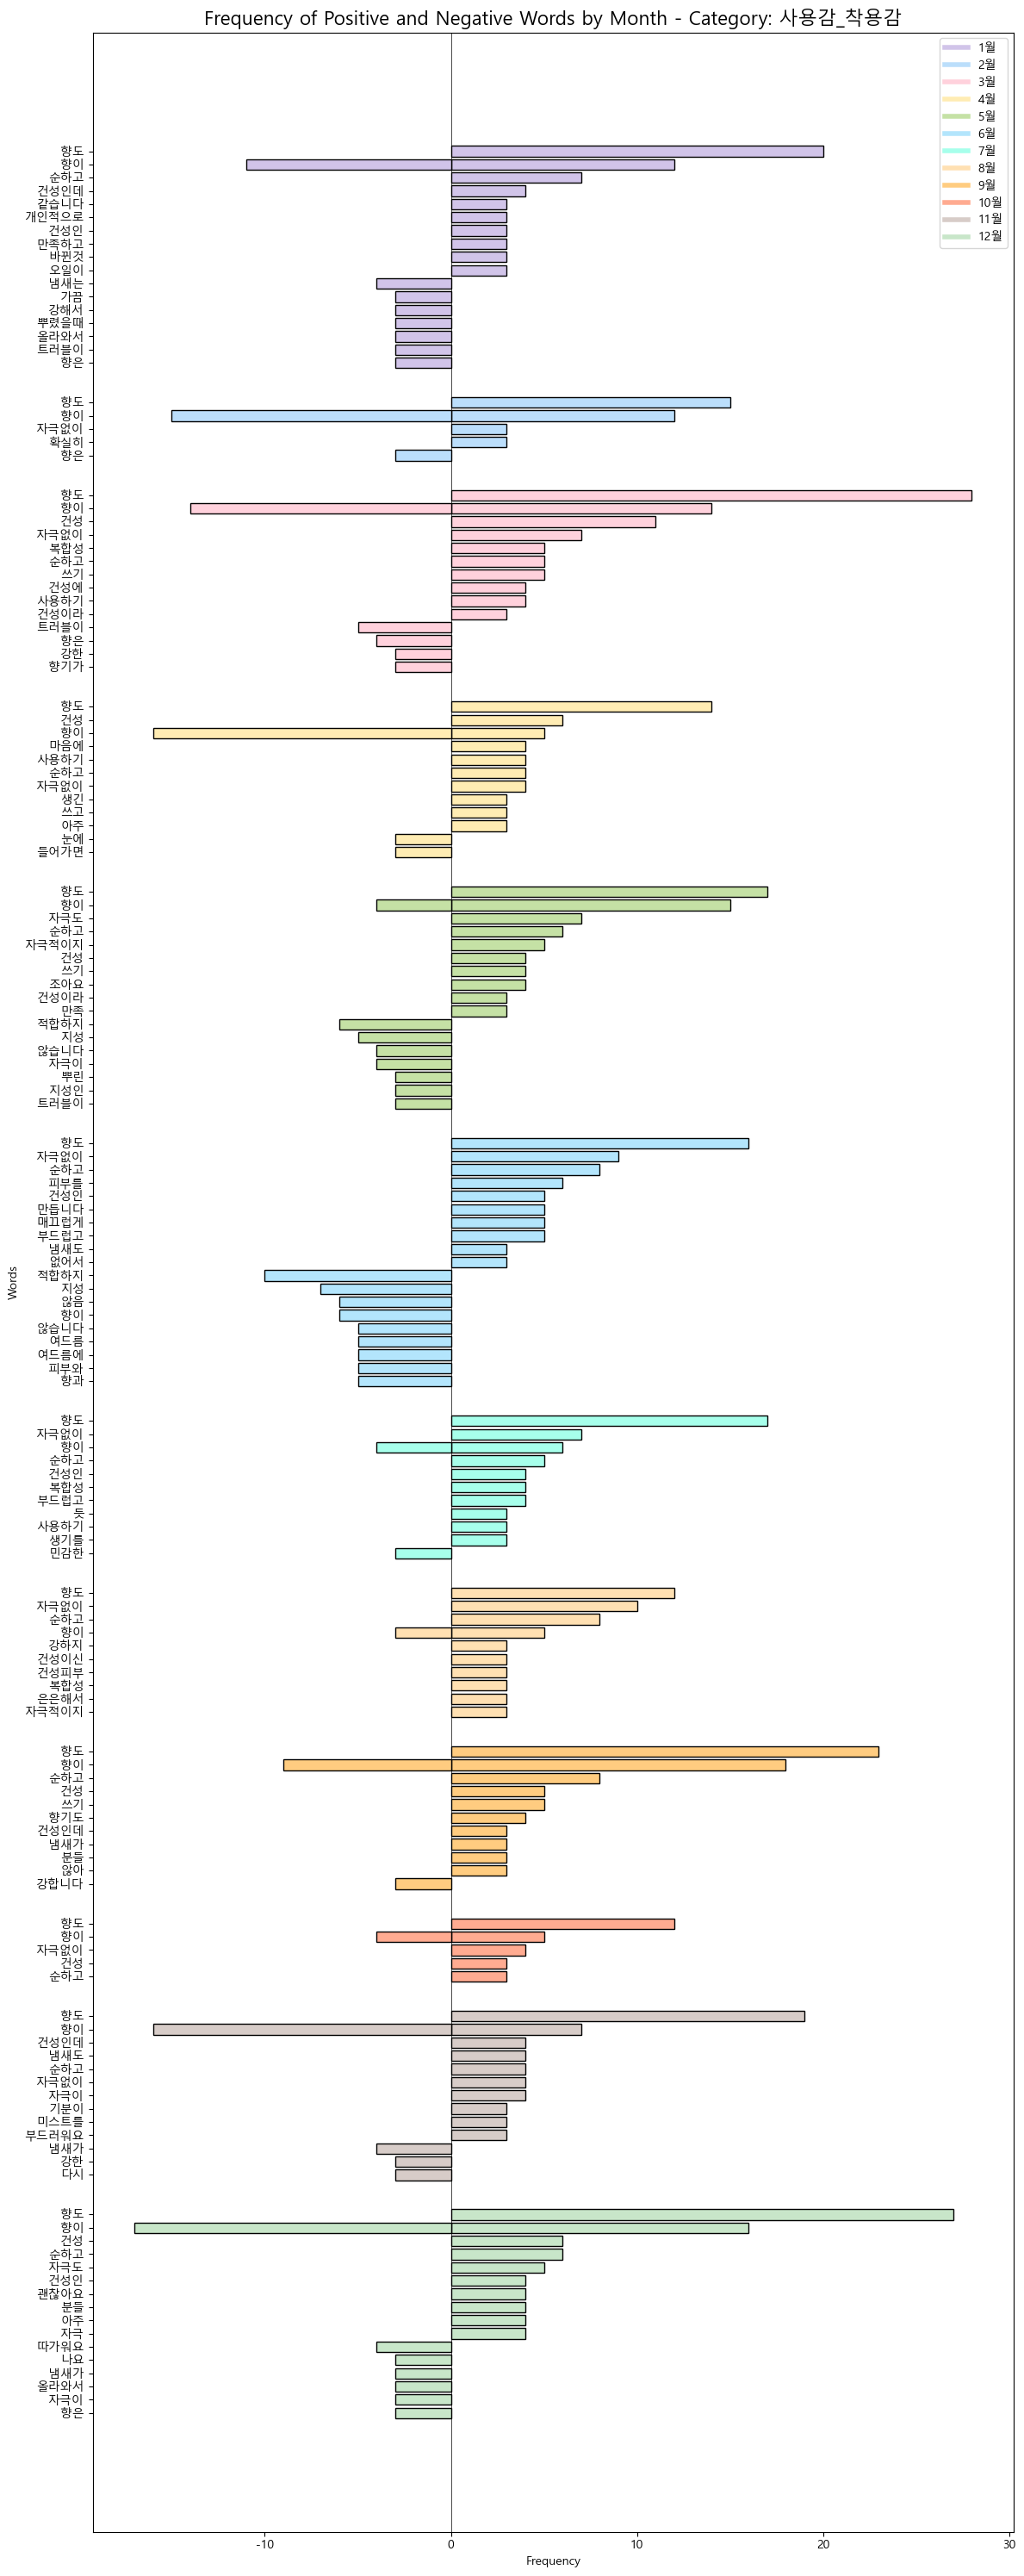

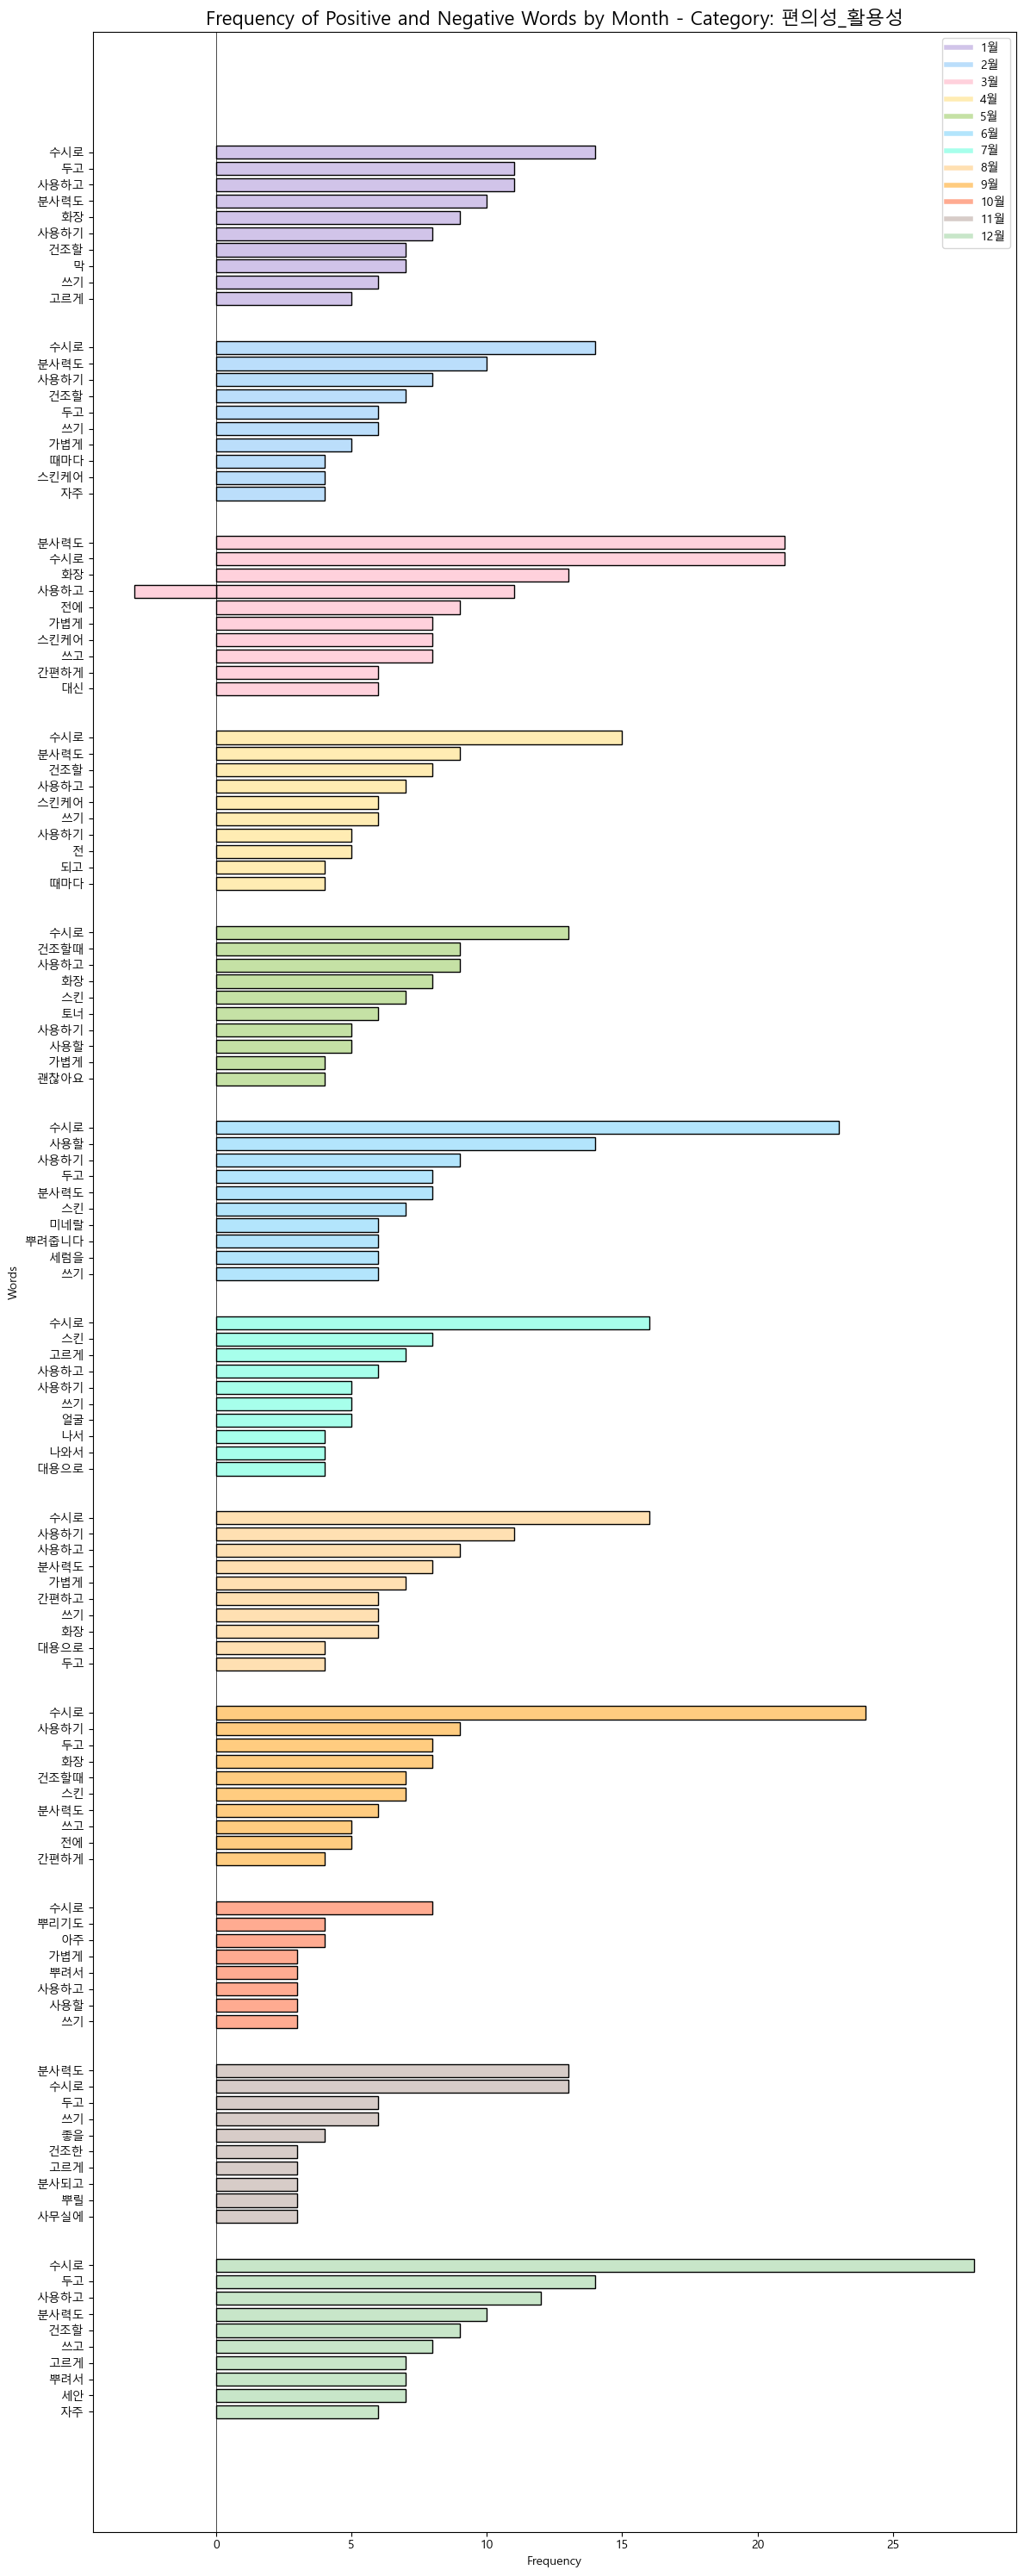

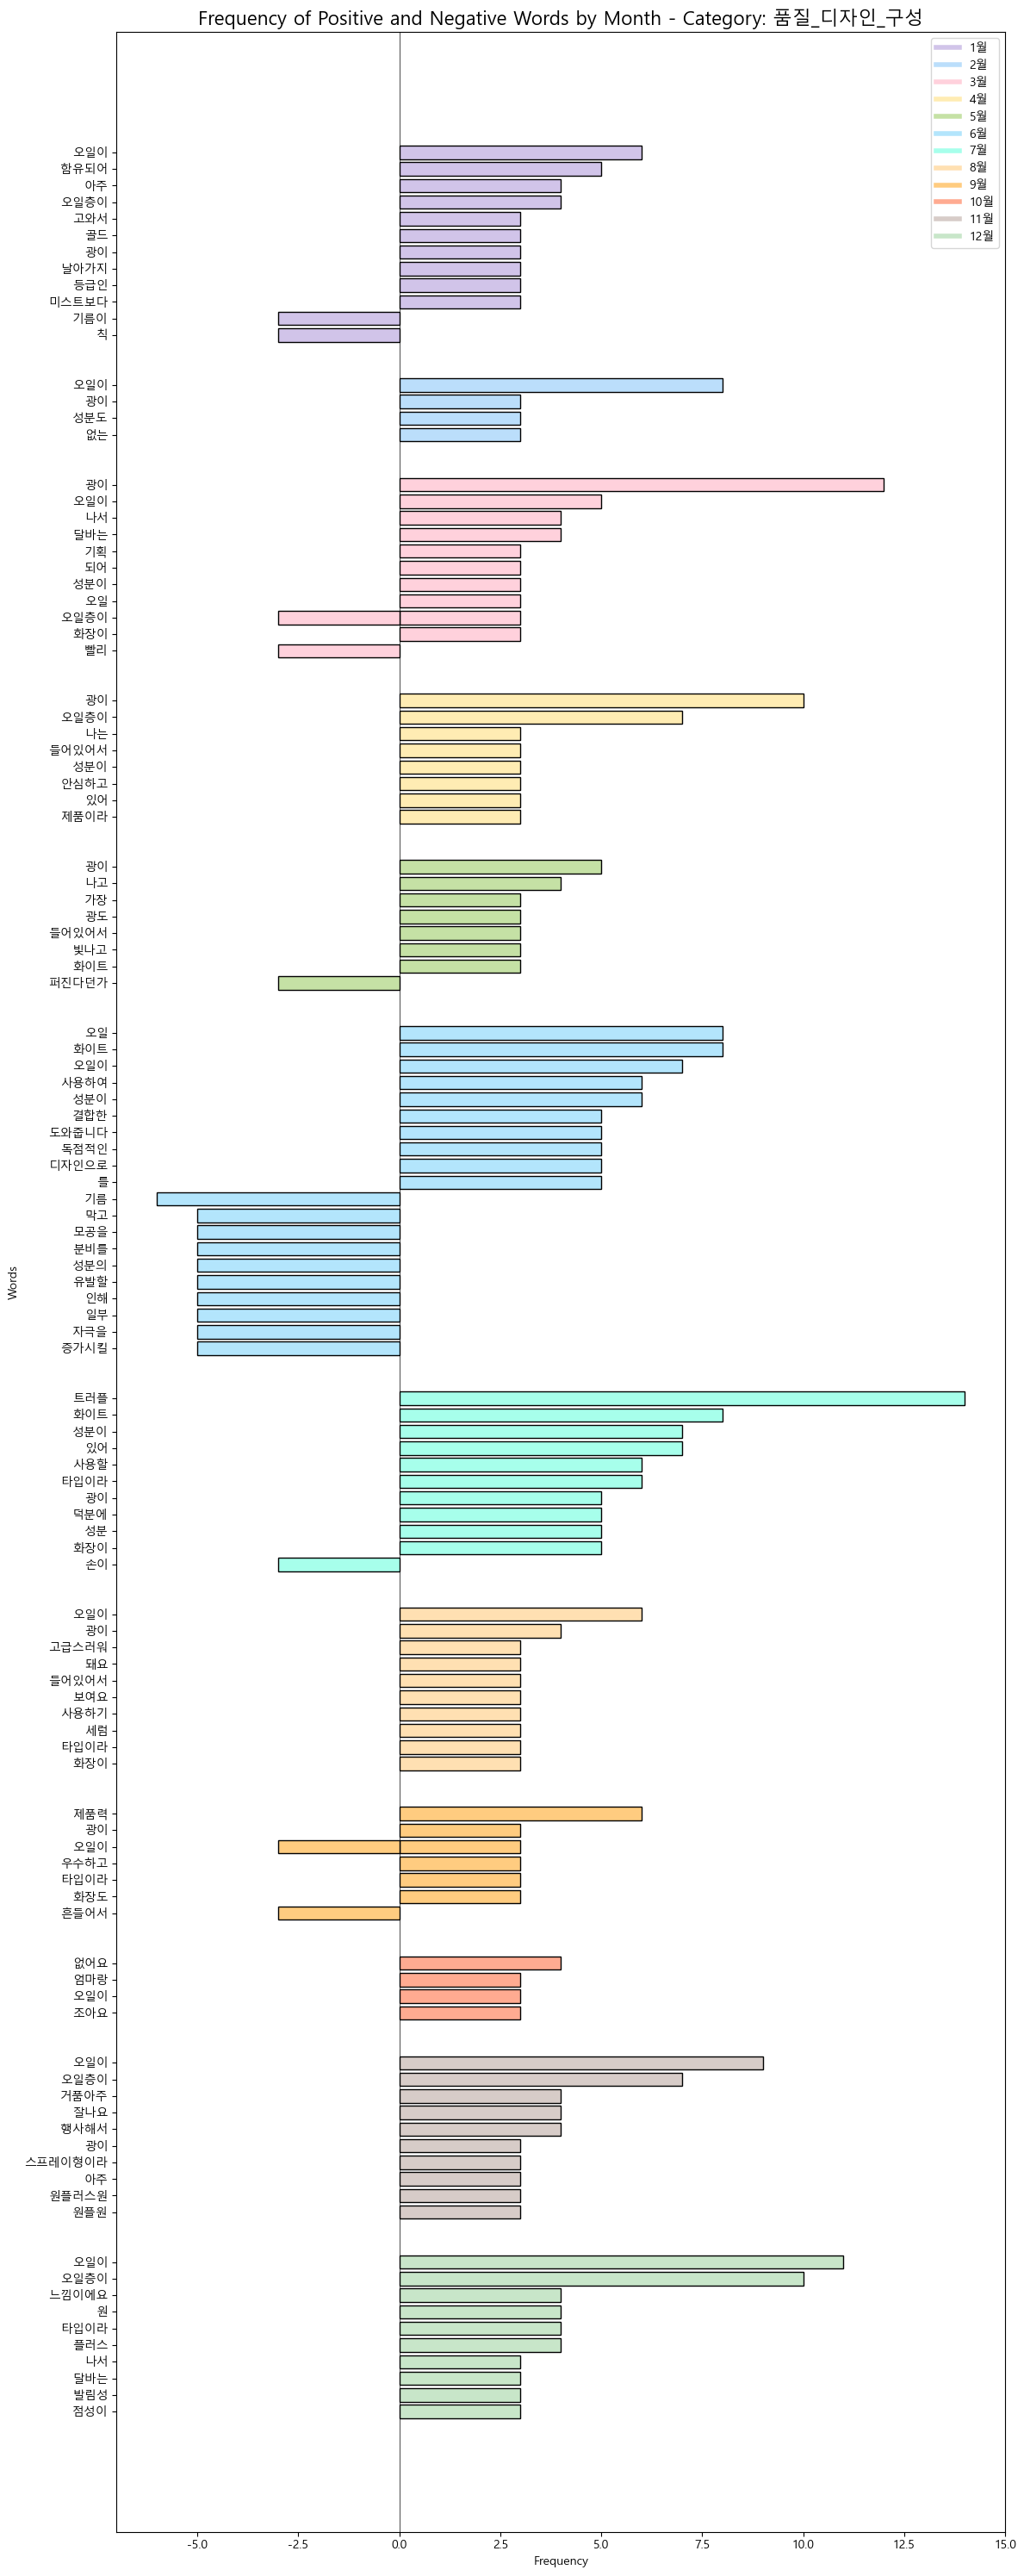

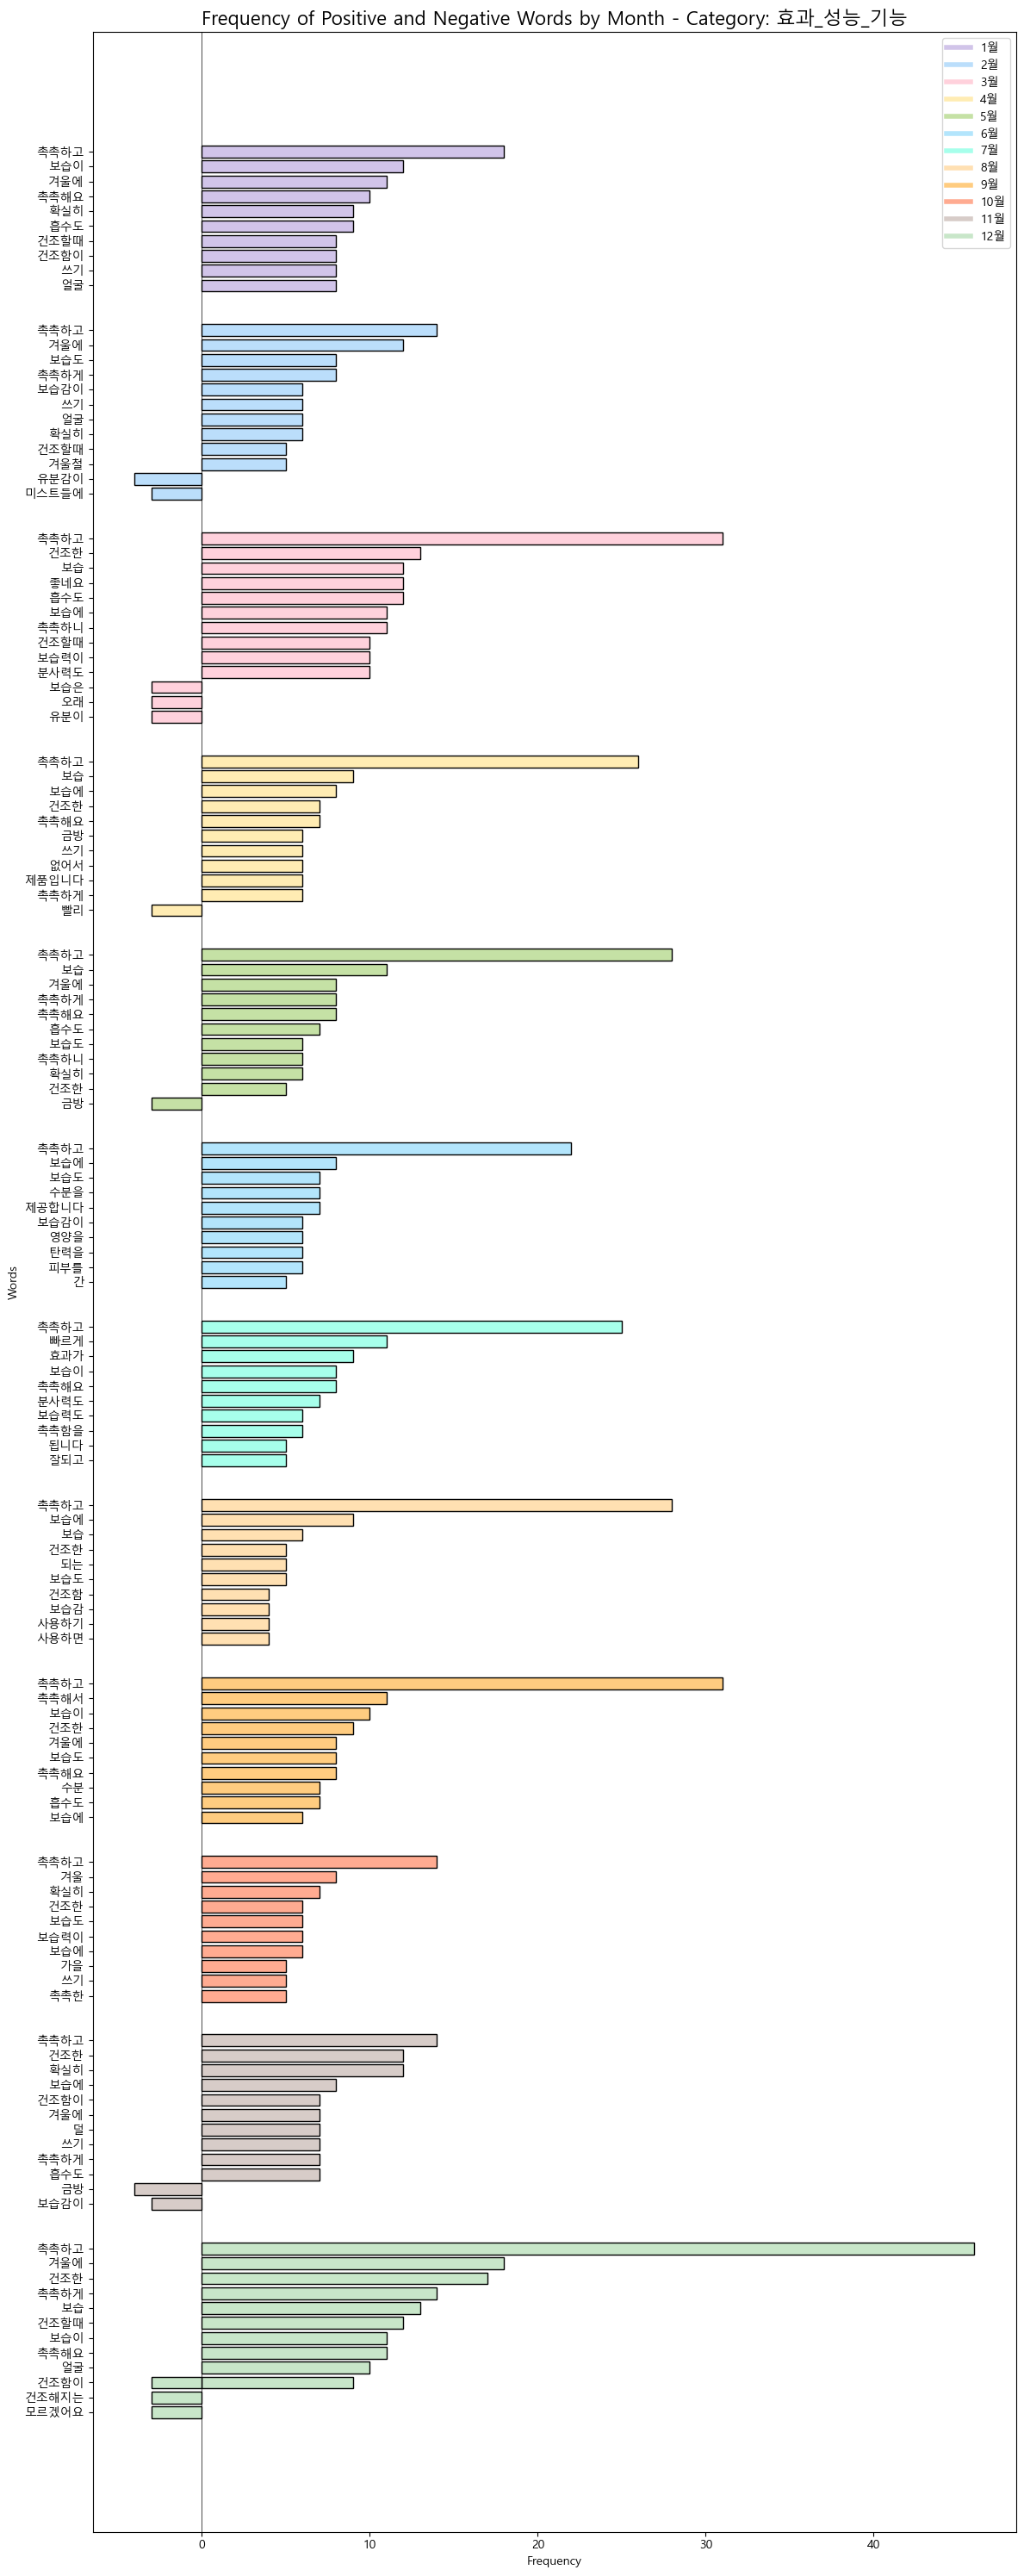

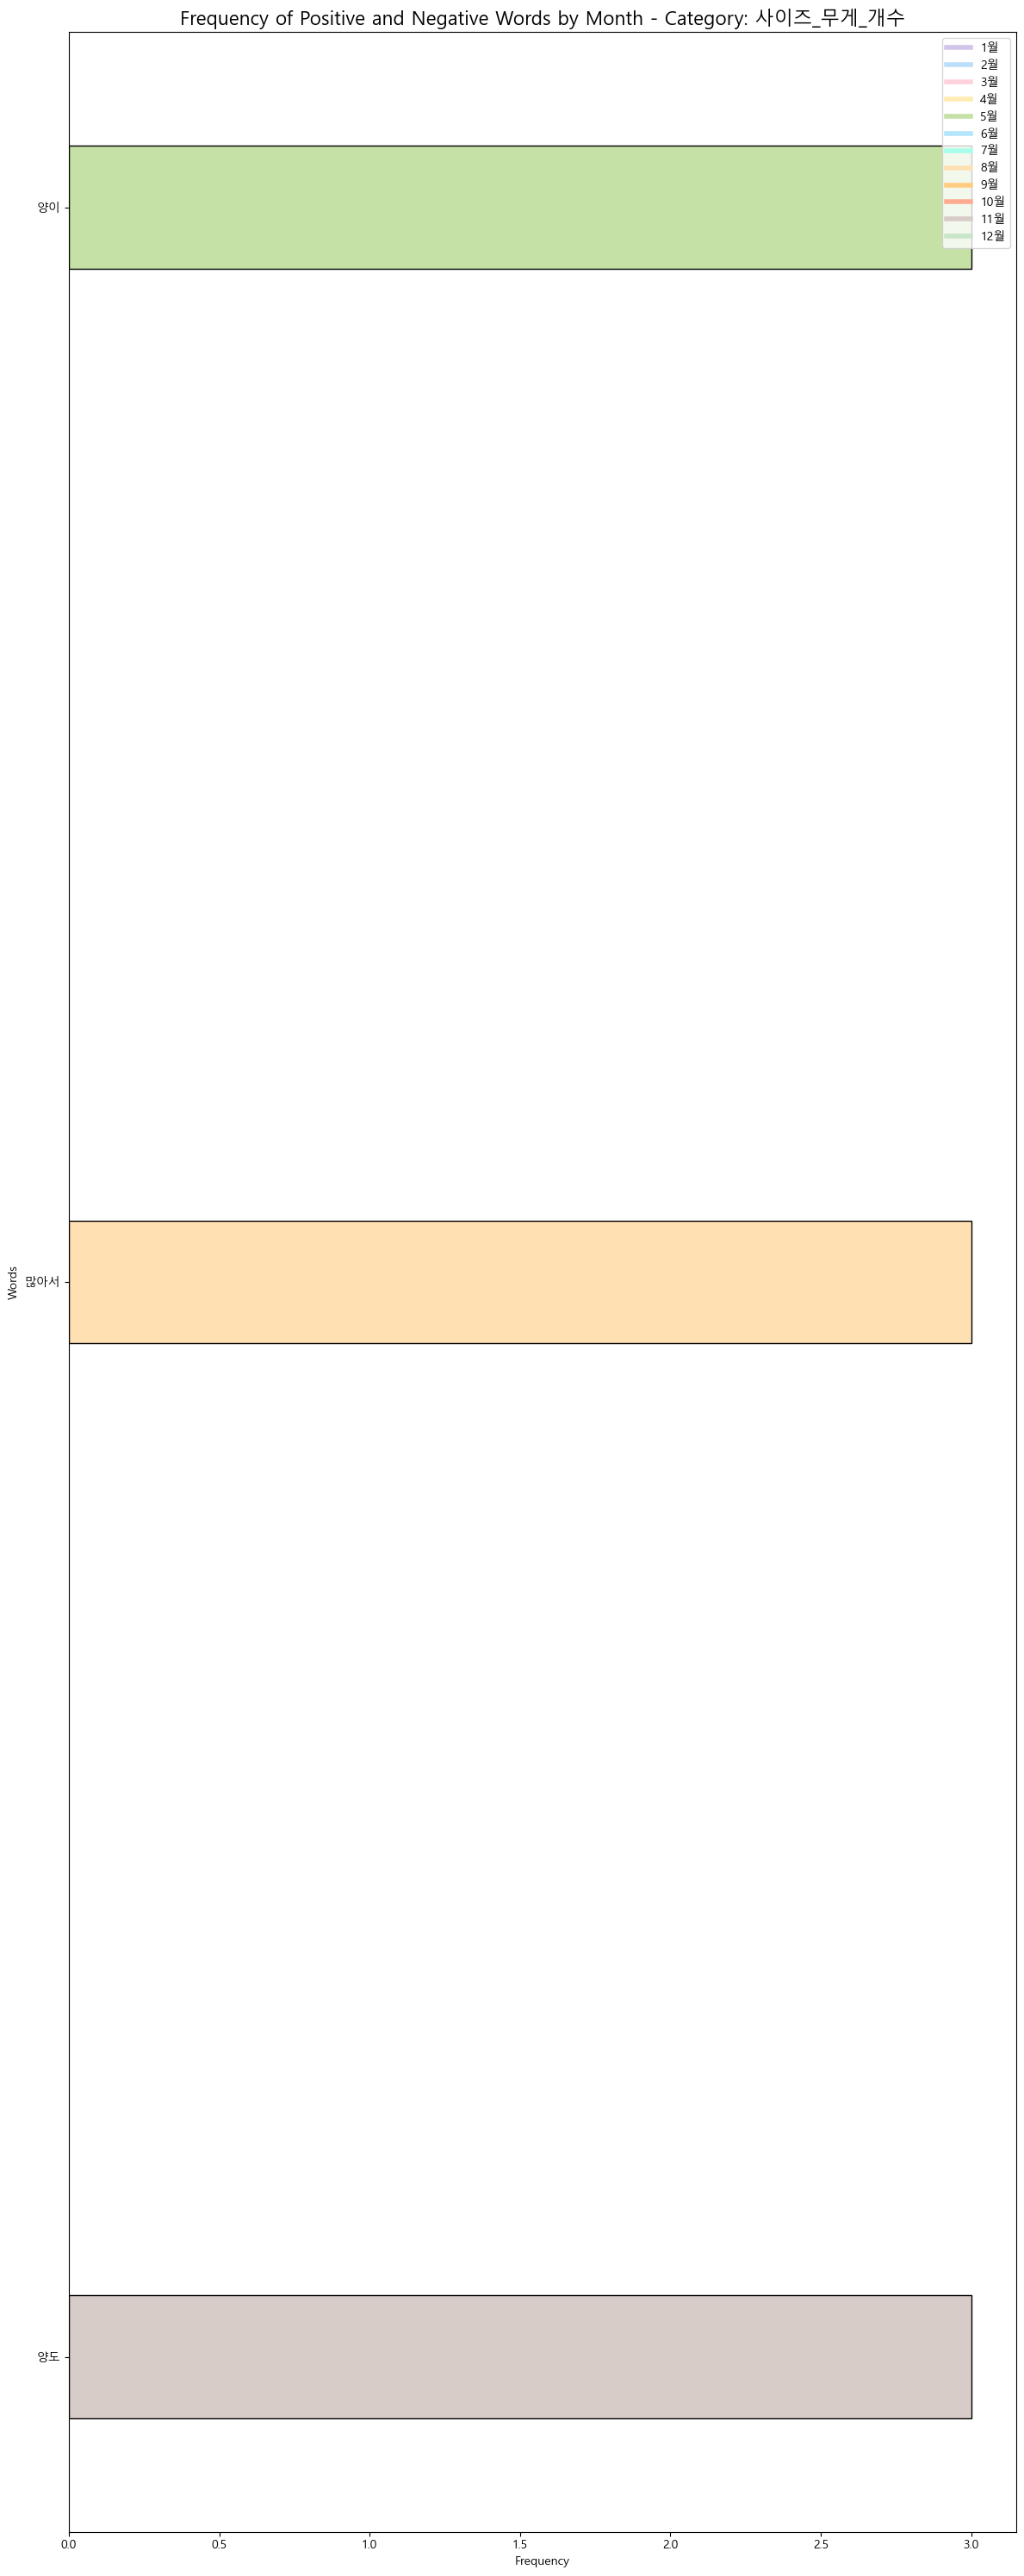

In [35]:
import matplotlib.pyplot as plt
import unicodedata
import pandas as pd
from matplotlib import font_manager, rc


# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


# Unicode 정규화 함수 정의
def normalize_text(text):
    return unicodedata.normalize('NFC', text)

# 브랜드 색상 설정 (정규화 적용 - 월별 파스텔 톤)
brand_colors = {

    normalize_text('1월'): '#D1C4E9',  # 라벤더 퍼플
    normalize_text('2월'): '#BBDEFB',  # 부드러운 하늘색
    
    # 봄 (3월, 4월, 5월)
    normalize_text('3월'): '#FFD1DC',  # 라이트 핑크
    normalize_text('4월'): '#FFECB3',  # 파스텔 옐로우
    normalize_text('5월'): '#C5E1A5',  # 라이트 그린

    # 여름 (6월, 7월, 8월)
    normalize_text('6월'): '#B3E5FC',  # 맑은 하늘색
    normalize_text('7월'): '#A7FFEB',  # 파스텔 민트
    normalize_text('8월'): '#FFE0B2',  # 연한 피치색

    # 가을 (9월, 10월, 11월)
    normalize_text('9월'): '#FFCC80',  # 따뜻한 라이트 오렌지
    normalize_text('10월'): '#FFAB91',  # 부드러운 살구색
    normalize_text('11월'): '#D7CCC8',  # 파스텔 브라운

    # 겨울 (12월, 1월, 2월)
    normalize_text('12월'): '#C8E6C9',  # 파스텔 그린

}

# 데이터 정규화 (모든 문자열 필드에 정규화 적용)
df['Brand'] = df['Brand'].apply(normalize_text)
df['Category'] = df['Category'].apply(normalize_text)
df['Sentiment'] = df['Sentiment'].apply(normalize_text)
df['Word'] = df['Word'].apply(normalize_text)

# 빈도수 5 이상인 데이터만 필터링
filtered_df = df[df['Frequency'] >= 3]

# 중복 단어 제거: 같은 브랜드 내에서 동일한 단어의 긍정/부정 빈도를 합산
filtered_df = filtered_df.groupby(['Brand', 'Category', 'Word', 'Sentiment'], as_index=False)['Frequency'].sum()

# 카테고리별로 그래프 그리기
for category in filtered_df['Category'].unique():
    # 카테고리별 데이터 필터링
    category_data = filtered_df[filtered_df['Category'] == normalize_text(category)]

    fig, ax = plt.subplots(figsize=(12, 30))
    
    ax.set_title(normalize_text(f"Frequency of Positive and Negative Words by Month - Category: {category}"), fontsize=16)

    # 단어 레이블과 위치 저장을 위한 리스트 초기화
    words = []
    y_positions = []
    offset = 0  # y축 위치 오프셋

    # 각 브랜드별로 상단부터 달바, 바이오힐보, 아벤느 순으로 정렬
    for brand in ['1월','2월','3월','4월','5월','6월','7월','8월','9월','10월','11월','12월']:
        # 브랜드별 데이터 필터링
        brand_data = category_data[category_data['Brand'] == normalize_text(brand)]

        # 긍정 단어 상위 10개와 부정 단어 상위 10개 선택
        positive_words = brand_data[brand_data['Sentiment'] == 'positive'].nlargest(10, 'Frequency')
        negative_words = brand_data[brand_data['Sentiment'] == 'negative'].nlargest(10, 'Frequency')

        # 긍정 단어와 부정 단어 결합
        combined_words = pd.concat([positive_words, negative_words]).drop_duplicates(subset=['Word'], keep='first')

        # 긍정 단어 우선 정렬, 이후 남은 부정 단어 내림차순 정렬
        sorted_words = pd.concat([
            combined_words[combined_words['Sentiment'] == 'positive'].sort_values(by='Frequency', ascending=False),
            combined_words[(combined_words['Sentiment'] == 'negative') & (~combined_words['Word'].isin(positive_words['Word']))].sort_values(by='Frequency', ascending=False)
        ])

        # 단어별로 긍정/부정 데이터를 결합하여 표시
        for _, row in sorted_words.iterrows():
            word = row['Word']
            pos_data = positive_words[positive_words['Word'] == word]
            neg_data = negative_words[negative_words['Word'] == word]

            # y축 위치 설정
            y_pos = offset
            words.append(word)
            y_positions.append(y_pos)

            # 긍정 단어가 있는 경우 막대 그리기 (오른쪽 방향)
            if not pos_data.empty:
                pos_frequency = pos_data['Frequency'].sum()
                ax.barh(y_pos, pos_frequency, height=0.8, color=brand_colors[brand], edgecolor='black')

            # 부정 단어가 있는 경우 막대 그리기 (왼쪽 방향)
            if not neg_data.empty:
                neg_frequency = neg_data['Frequency'].sum()
                ax.barh(y_pos, -neg_frequency, height=0.8, color=brand_colors[brand], edgecolor='black')

            # 다음 단어로 이동
            offset += 1

        # 브랜드 간 여백 추가
        offset += 2  # 각 브랜드 사이에 여백을 추가

    # y축 레이블 설정 및 축 반전
    ax.set_yticks(y_positions)
    ax.set_yticklabels(words, fontsize=10)
    plt.gca().invert_yaxis()  # y축을 반전시켜 긍정 단어가 상단에 위치하도록 설정

    # 축 및 레이블 설정
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')
    
    ax.axvline(0, color='black', linewidth=0.5)  # 중앙 기준선 추가

    # 범례 추가 (브랜드별 색상만 표시)
    brand_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in brand_colors.values()]
    brand_labels = list(brand_colors.keys())
    ax.legend(brand_handles, brand_labels, loc="upper right")

    plt.tight_layout()
    plt.show()


# 피부타입

In [2]:
import json
import os
import re
import pandas as pd

folder_path = r"\Users\kyn03\OneDrive\바탕 화면\project_file\이탈\워드클라우드_json\피부타입"

# 제거할 불용어 리스트 정의
stopwords = ["있어요", "합니다", "입니다", "같아요", "있는", "않고","맞는", "뿌리면","뿌리고","뿌리는","뭐가","좋은","좋아요","좋고","뿌려주면","뿌리기",
             "않아요","좋아서","않아서","하고","좋습니다","거","구매했어요","아니라","하고","정말","많은","뿌려주고","좋았어요", "뿌려주기", "뿌려도",
             "안되고","있습니다","줄","샀어요","구매해서","사서","샀습니다","피부에","피부가","꽤","가격이","가격은","100","피부에","피부","후","해서",
             "가격도","구매했습니다","얼굴에", "가격에","300", "없고","없이","피부에는","넘"]  # 필요에 따라 불용어 추가

# 데이터를 담을 딕셔너리 생성
data = {}
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        filename = filename.replace(" ", "")  # 파일 이름에서 공백 제거
        path = os.path.join(folder_path, filename)

        with open(path, "r", encoding="utf-8") as file:
            # 파일 이름에서 브랜드, 카테고리, 감정 추출
            match = re.match(r"^[가-힣]+_([가-힣]+)_((?:[\w가-힣]+_?)+)_(positive|negative).*\.json$", filename)
            if match:
                brand = match.group(1)       # 첫 번째 그룹: 브랜드명
                category = match.group(2)    # 두 번째 그룹: 속성명 (다중 언더스코어 포함 가능)
                sentiment = match.group(3)   # 세 번째 그룹: 긍정/부정

                # JSON 파일에서 단어 데이터를 읽어와서 리스트로 저장
                words = json.load(file)
                for word, count in words.items():
                    # 불용어 필터링
                    if word not in stopwords:
                        data.setdefault((brand, category, sentiment), []).append((word, count))
            else:
                print(f"파일명 형식이 맞지 않음: {filename}")

# 데이터를 DataFrame으로 변환
df = pd.DataFrame(columns=["Brand", "Category", "Sentiment", "Word", "Frequency"])

# 데이터프레임에 데이터 추가
rows = []
for (brand, category, sentiment), words in data.items():
    # 빈도수가 높은 순서대로 정렬
    sorted_words = sorted(words, key=lambda x: x[1], reverse=True)
    for word, count in sorted_words:
        rows.append({
            "Brand": brand,
            "Category": category,
            "Sentiment": sentiment,
            "Word": word,
            "Frequency": count
        })

# DataFrame에 데이터를 추가
df = pd.DataFrame(rows)

# Frequency를 숫자형으로 변환
df['Frequency'] = pd.to_numeric(df['Frequency'], errors='coerce')

# 결과 출력
print(df)

     Brand  Category Sentiment    Word  Frequency
0       건성        가격  negative    비싸지만          2
1       건성        가격  negative     정가에          1
2       건성        가격  negative  비싸보인다규          1
3       건성        가격  negative    가격대가          1
4       건성        가격  negative      행사          1
...    ...       ...       ...     ...        ...
9055    지성  효과_성능_기능  positive      치면          1
9056    지성  효과_성능_기능  positive       달          1
9057    지성  효과_성능_기능  positive   스며들어서          1
9058    지성  효과_성능_기능  positive    수분유지          1
9059    지성  효과_성능_기능  positive       할          1

[9060 rows x 5 columns]


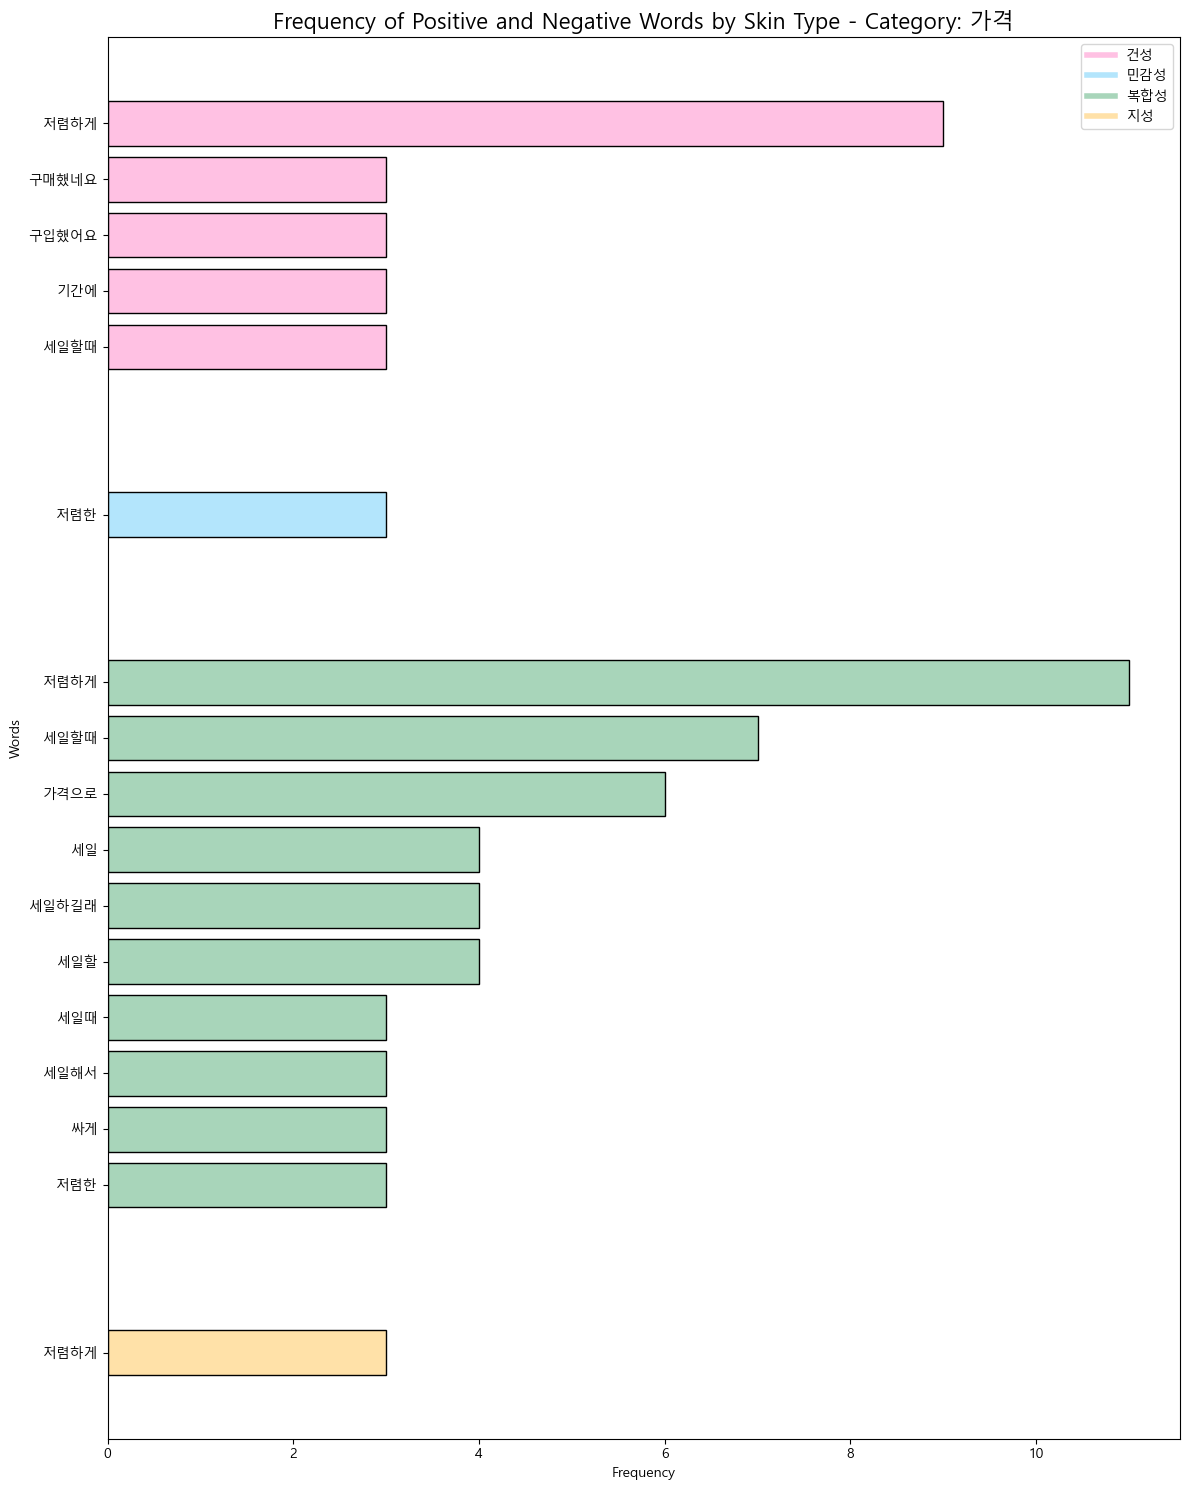

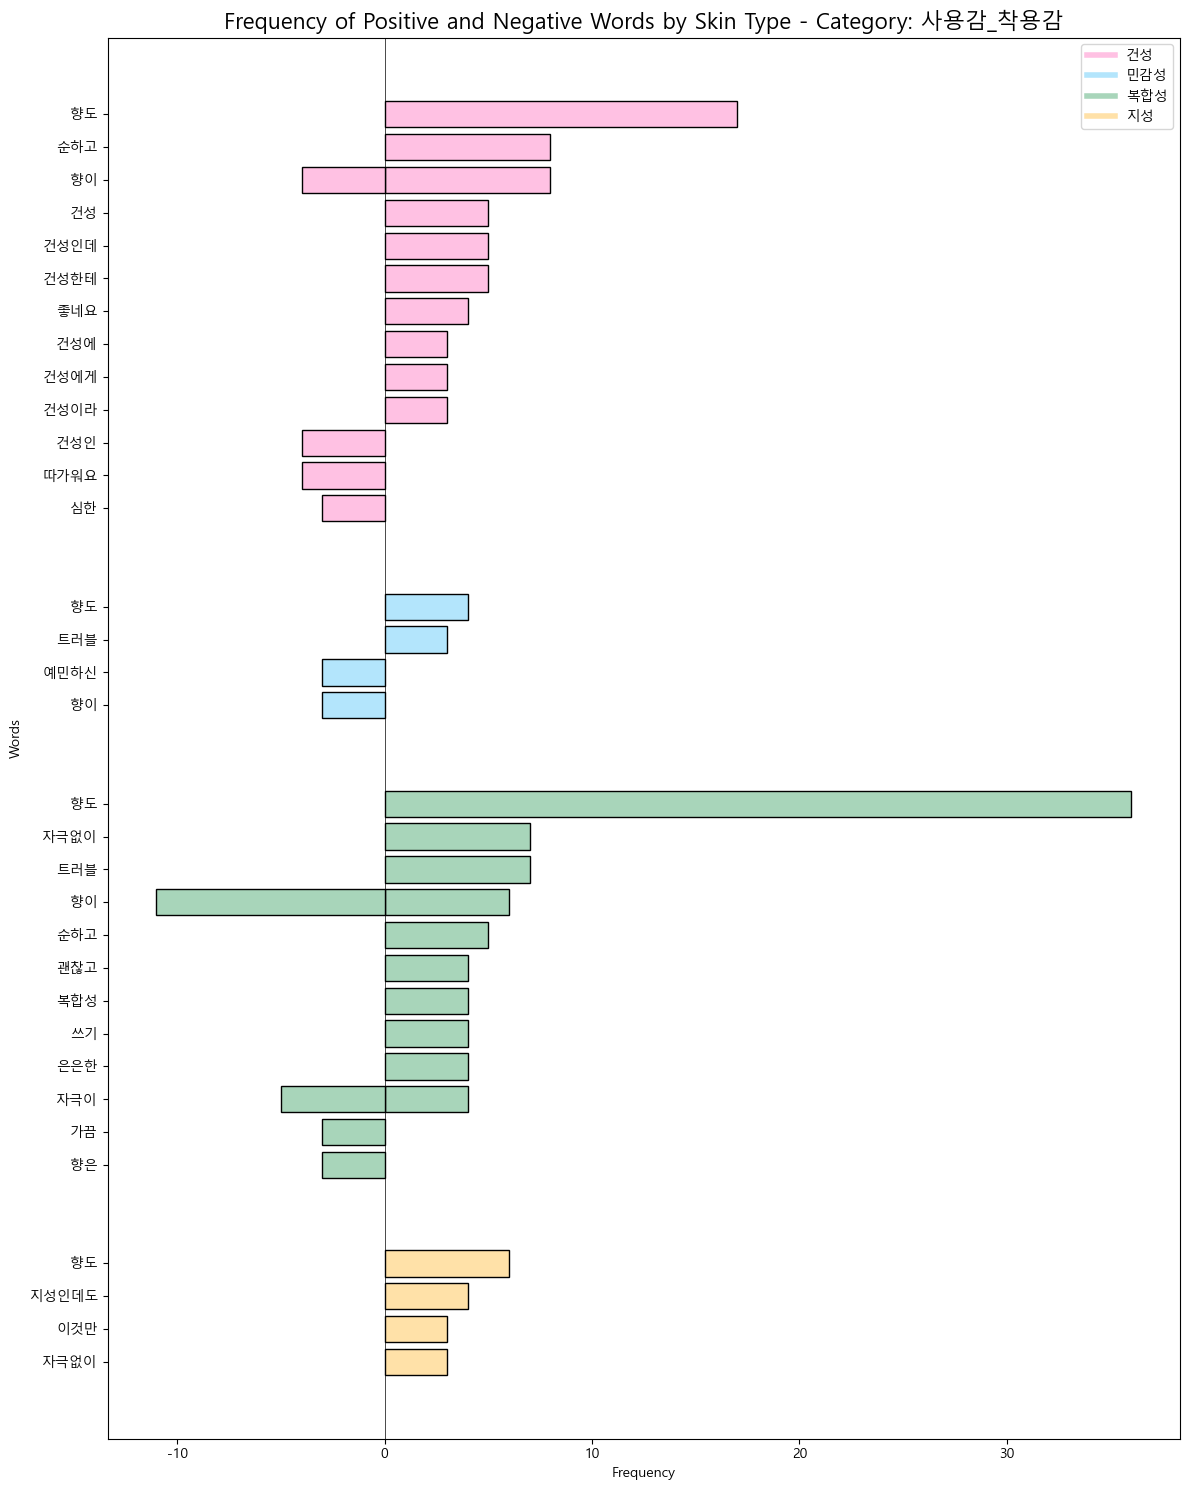

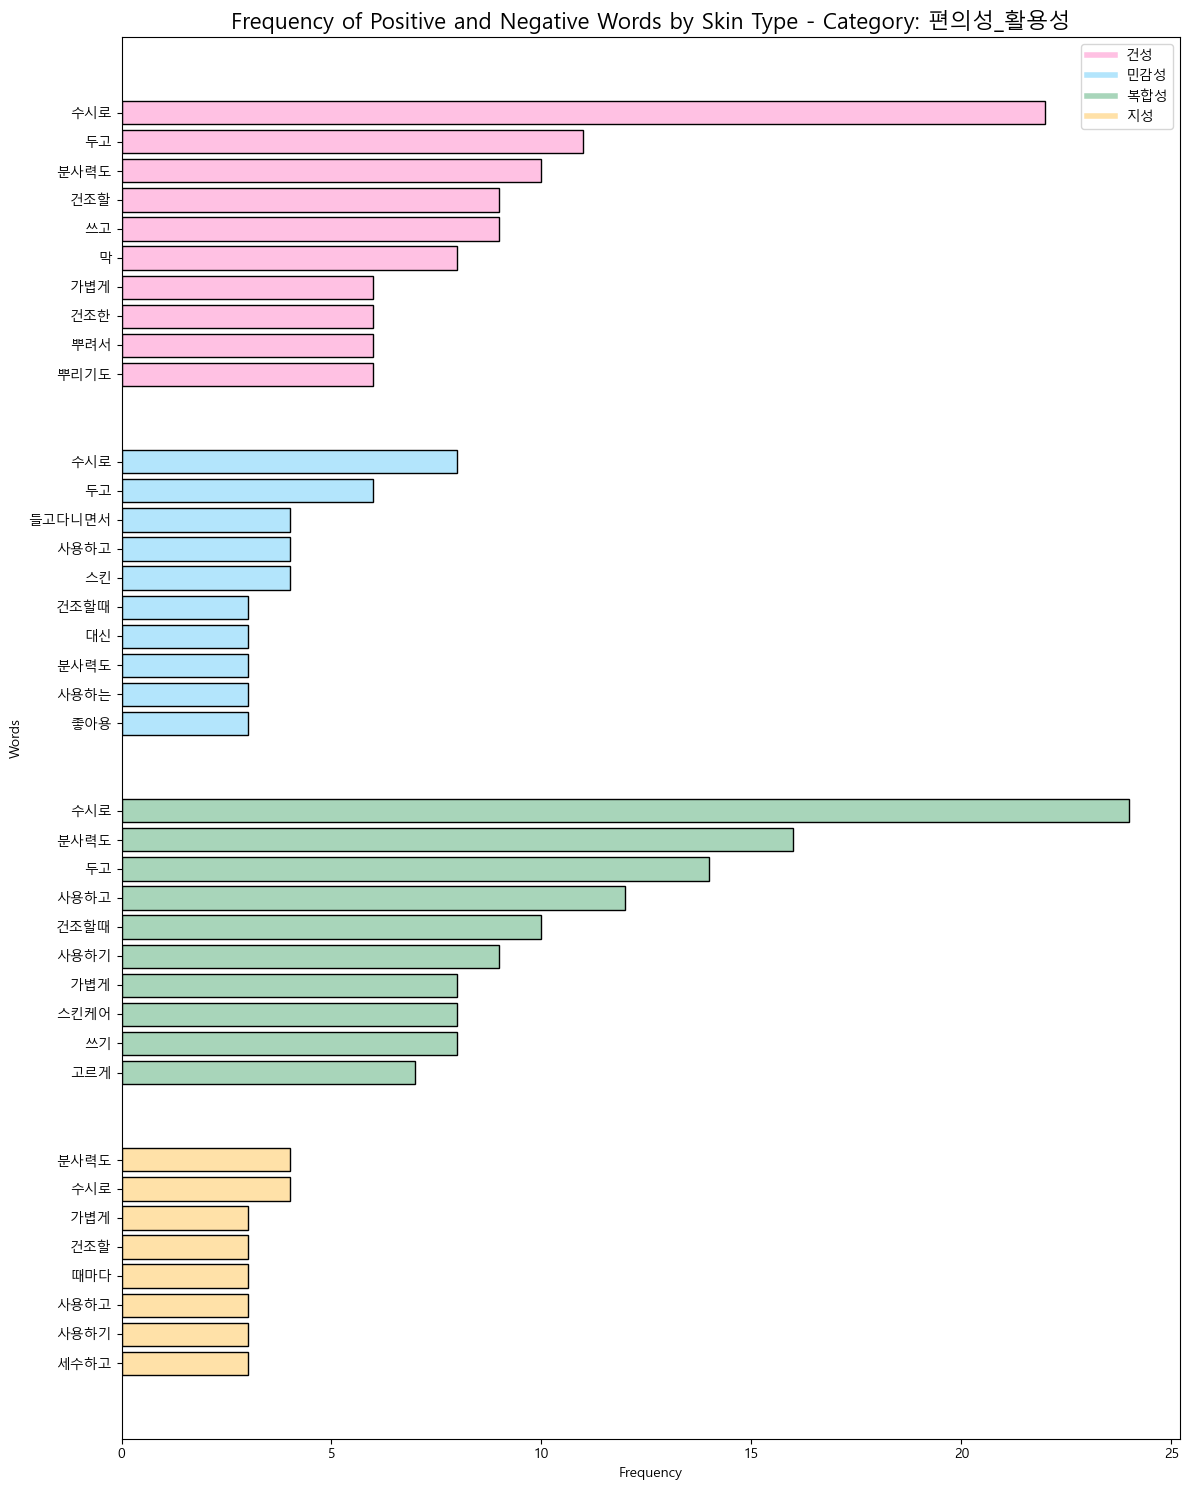

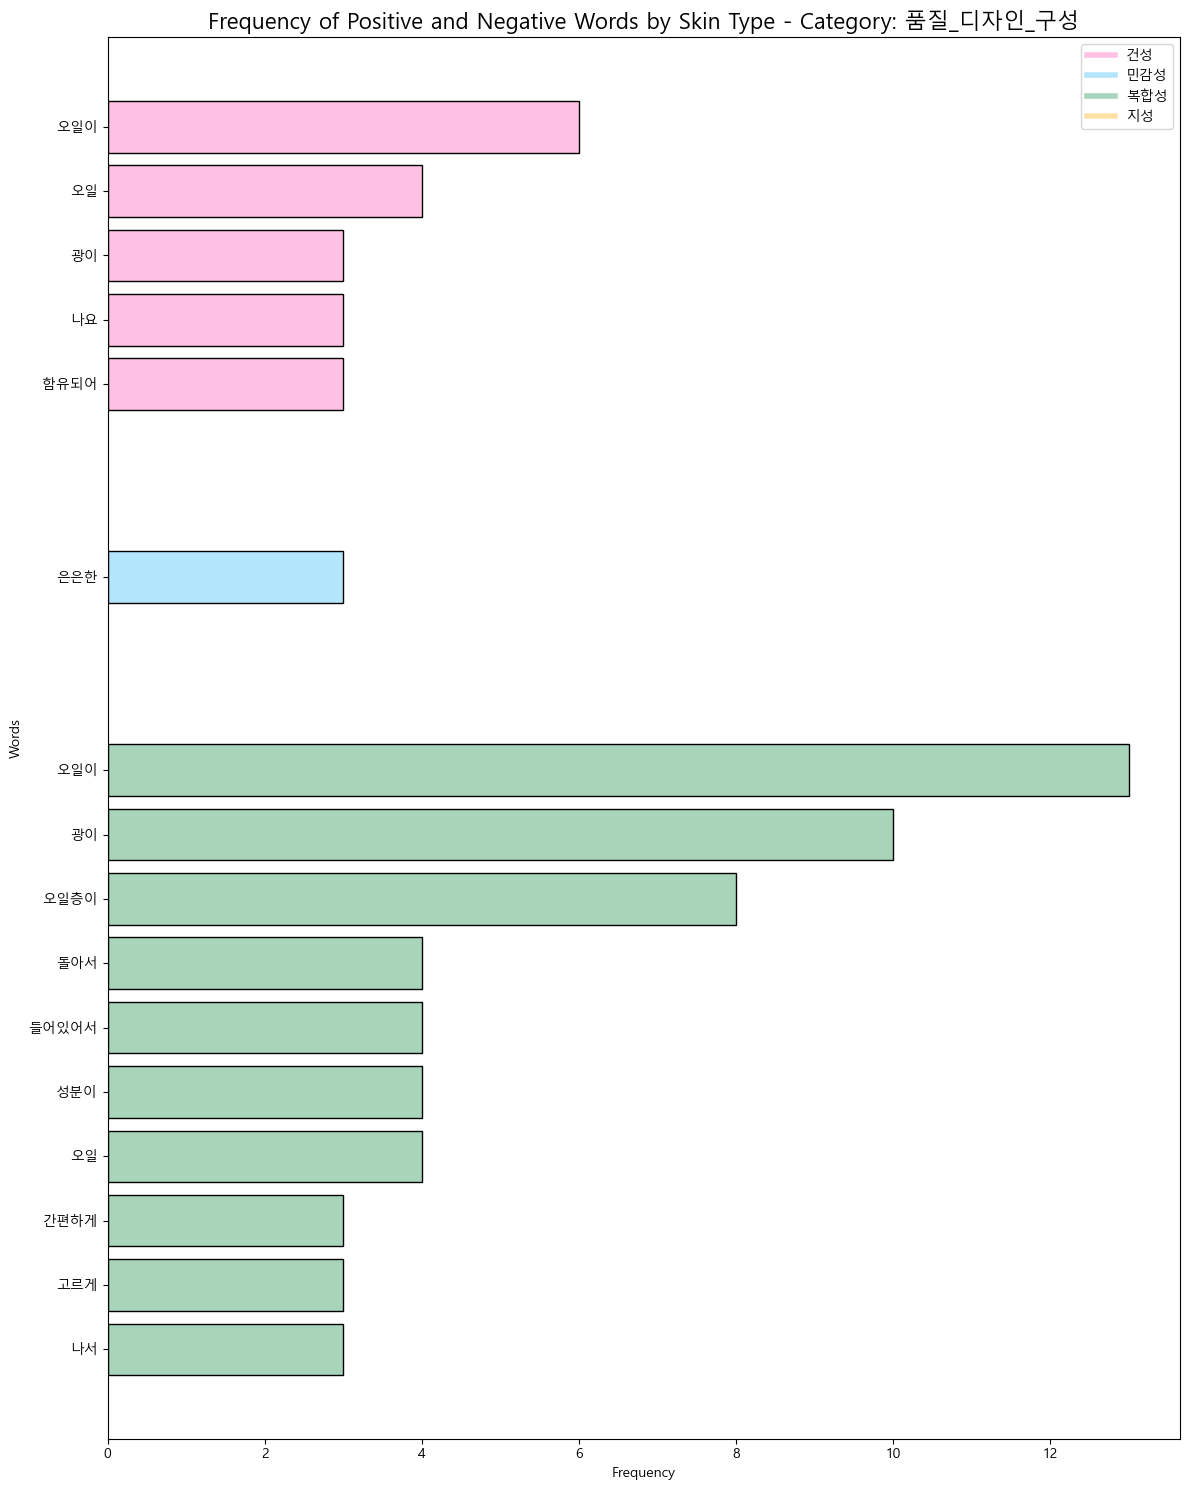

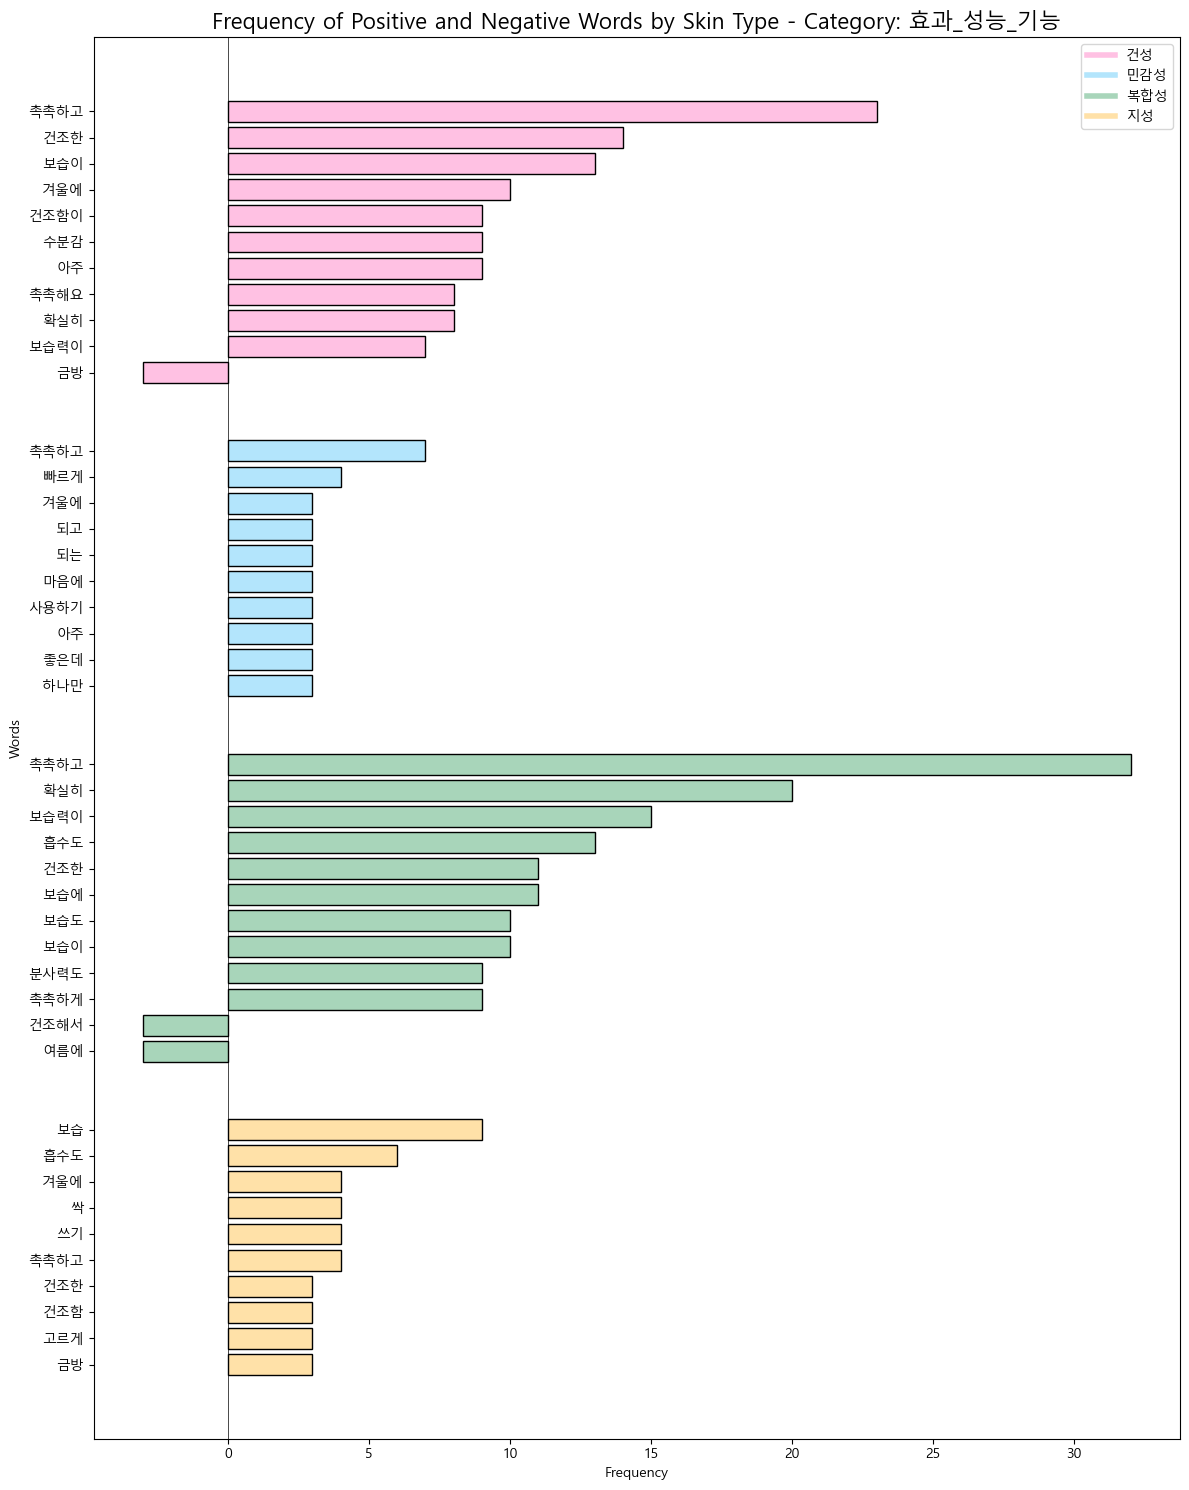

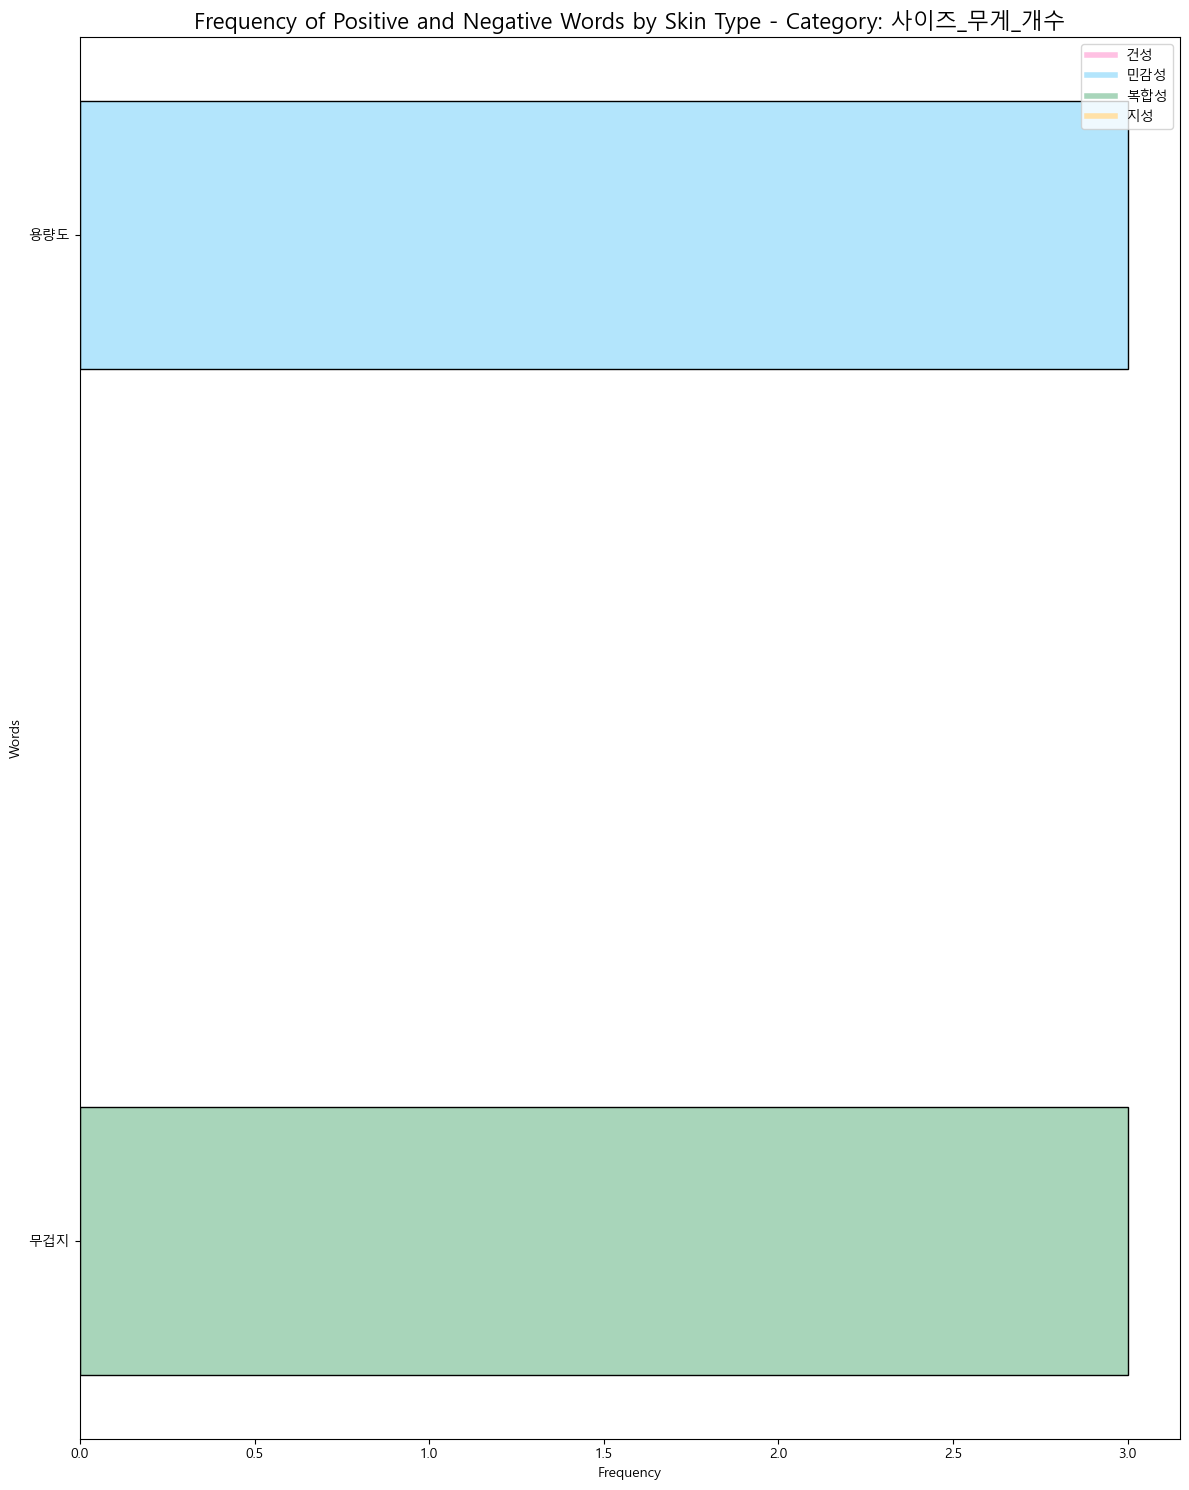

In [3]:
import matplotlib.pyplot as plt
import unicodedata
import pandas as pd
from matplotlib import font_manager, rc


# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 윈도우의 경우
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


# Unicode 정규화 함수 정의
def normalize_text(text):
    return unicodedata.normalize('NFC', text)

# 브랜드 색상 설정 (정규화 적용 - 피부 타입별 파스텔 톤)
brand_colors = {
    normalize_text('건성'): '#FFC1E3',  # 부드러운 로즈 핑크 (건성의 포근하고 부드러운 느낌)
    normalize_text('민감성'): '#B3E5FC',  # 차분한 파스텔 블루 (민감성을 위한 진정 효과)
    normalize_text('복합성'): '#A8D5BA',  # 싱그러운 라이트 민트 (균형 잡힌 느낌)
    normalize_text('지성'): '#FFE1A8',  # 따뜻한 파스텔 코랄 (활기와 생기)
}


# 데이터 정규화 (모든 문자열 필드에 정규화 적용)
df['Brand'] = df['Brand'].apply(normalize_text)
df['Category'] = df['Category'].apply(normalize_text)
df['Sentiment'] = df['Sentiment'].apply(normalize_text)
df['Word'] = df['Word'].apply(normalize_text)

# 빈도수 5 이상인 데이터만 필터링
filtered_df = df[df['Frequency'] >= 3]

# 중복 단어 제거: 같은 브랜드 내에서 동일한 단어의 긍정/부정 빈도를 합산
filtered_df = filtered_df.groupby(['Brand', 'Category', 'Word', 'Sentiment'], as_index=False)['Frequency'].sum()

# 카테고리별로 그래프 그리기
for category in filtered_df['Category'].unique():
    # 카테고리별 데이터 필터링
    category_data = filtered_df[filtered_df['Category'] == normalize_text(category)]

    fig, ax = plt.subplots(figsize=(12, 15))
    
    ax.set_title(normalize_text(f"Frequency of Positive and Negative Words by Skin Type - Category: {category}"), fontsize=16)

    # 단어 레이블과 위치 저장을 위한 리스트 초기화
    words = []
    y_positions = []
    offset = 0  # y축 위치 오프셋

    # 각 브랜드별로 상단부터 달바, 바이오힐보, 아벤느 순으로 정렬
    for brand in ['건성','민감성','복합성','지성']:
        # 브랜드별 데이터 필터링
        brand_data = category_data[category_data['Brand'] == normalize_text(brand)]

        # 긍정 단어 상위 10개와 부정 단어 상위 10개 선택
        positive_words = brand_data[brand_data['Sentiment'] == 'positive'].nlargest(10, 'Frequency')
        negative_words = brand_data[brand_data['Sentiment'] == 'negative'].nlargest(10, 'Frequency')

        # 긍정 단어와 부정 단어 결합
        combined_words = pd.concat([positive_words, negative_words]).drop_duplicates(subset=['Word'], keep='first')

        # 긍정 단어 우선 정렬, 이후 남은 부정 단어 내림차순 정렬
        sorted_words = pd.concat([
            combined_words[combined_words['Sentiment'] == 'positive'].sort_values(by='Frequency', ascending=False),
            combined_words[(combined_words['Sentiment'] == 'negative') & (~combined_words['Word'].isin(positive_words['Word']))].sort_values(by='Frequency', ascending=False)
        ])

        # 단어별로 긍정/부정 데이터를 결합하여 표시
        for _, row in sorted_words.iterrows():
            word = row['Word']
            pos_data = positive_words[positive_words['Word'] == word]
            neg_data = negative_words[negative_words['Word'] == word]

            # y축 위치 설정
            y_pos = offset
            words.append(word)
            y_positions.append(y_pos)

            # 긍정 단어가 있는 경우 막대 그리기 (오른쪽 방향)
            if not pos_data.empty:
                pos_frequency = pos_data['Frequency'].sum()
                ax.barh(y_pos, pos_frequency, height=0.8, color=brand_colors[brand], edgecolor='black')

            # 부정 단어가 있는 경우 막대 그리기 (왼쪽 방향)
            if not neg_data.empty:
                neg_frequency = neg_data['Frequency'].sum()
                ax.barh(y_pos, -neg_frequency, height=0.8, color=brand_colors[brand], edgecolor='black')

            # 다음 단어로 이동
            offset += 1

        # 브랜드 간 여백 추가
        offset += 2  # 각 브랜드 사이에 여백을 추가

    # y축 레이블 설정 및 축 반전
    ax.set_yticks(y_positions)
    ax.set_yticklabels(words, fontsize=10)
    plt.gca().invert_yaxis()  # y축을 반전시켜 긍정 단어가 상단에 위치하도록 설정

    # 축 및 레이블 설정
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')
    
    ax.axvline(0, color='black', linewidth=0.5)  # 중앙 기준선 추가

    # 범례 추가 (브랜드별 색상만 표시)
    brand_handles = [plt.Line2D([0], [0], color=color, lw=4) for color in brand_colors.values()]
    brand_labels = list(brand_colors.keys())
    ax.legend(brand_handles, brand_labels, loc="upper right")

    plt.tight_layout()
    plt.show()
